In [56]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import pytz as pytz
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.simulator as sim
import pyPIPS.radarmodule as pyPIPSradar
import pyPIPS.PIPS as pips
import pyPIPS.pips_io as pips_io
import pyPIPS.parsivel_qc as pqc
import pyPIPS.parsivel_params as pp
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909', '033116'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis
casedate = '033116'

# Import the file containing the dictionaries needed to gather the radar, disdrometer, and model data.
sys.path.append('/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/configs/2016_IOP3')

from PIPSsim_1km_dicts import *

init_radar_dict = init_radar_dict[casedate]
init_dis_dict = init_dis_dict[casedate]
init_model_dict = init_model_dict[casedate]

In [3]:
# Now go ahead and read in the sweeps for the desired case
radar_dict = sim.read_sweeps(init_radar_dict)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_233553.663_to_20160331_234010.581_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:35:53 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_223343.424_to_20160331_223746.038_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:33:43 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_232035.774_to_20160331_232438.497_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:20:35 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_225416.507_to_20160331_225824.478_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:54:16 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_231525.783_to_20160331_231933.619_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:15:25 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_225928.203_to_20160331_230336.351_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:59:28 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_231009.612_to_20160331_231422.770_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 23:10:09 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_223849.284_to_20160331_224244.646_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 22:38:49 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_222409.899_to_20160331_222745.586_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:24:09 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_220855.137_to_20160331_221221.493_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:08:55 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_230443.929_to_20160331_230904.369_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.8129883
Time of sweep =  2016-03-31 23:04:43 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_220034.035_to_20160331_220342.729_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:00:34 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_224910.491_to_20160331_225313.332_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:49:10 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_233044.114_to_20160331_233446.376_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:30:44 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_232540.010_to_20160331_232942.705_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 23:25:40 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_221324.459_to_20160331_221637.372_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:13:24 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_220444.462_to_20160331_220752.822_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:04:44 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_222848.491_to_20160331_223242.346_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:28:48 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_221946.379_to_20160331_222307.878_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:19:46 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_224349.896_to_20160331_224806.980_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:43:49 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


310316 221203
2016-03-31 22:12:00
2016 3 31 22 12 0
2016-03-31 22:12:03 2016-03-31 22:12:00
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0
310316 220133
2016-03-31 22:01:30
2016 3 31 22 1 30
2016-03-31 22:01:33 2016-03-31 22:01:30
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0
310316 222503
2016-03-31 22:25:00
2016 3 31 22 25 0
2016-03-31 22:25:03 2016-03-31 22:25:00
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0
310316 214823
2016-03-31 21:48:20
2016 3 31 21 48 20
2016-03-31 21:48:23 2016-03-31 21:48:20
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Requested D

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/metpy/xarray.py:435: MetpyDeprecationWarning: The get_wind_components function was deprecated in version 0.9. This function has been renamed wind_components.
  return func(*args, **kwargs)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/metpy/calc/basic.py:797: RuntimeWarning: All-NaN slice encountered
  if np.greater(np.nanmax(np.abs(value)), max_radians):
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/metpy/plots/_mpl.py:331: MatplotlibDeprecationWarning: 
The is_math_text function was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  clean_line, ismath = self.is_math_text(line)


i, sweeptime =  2016-03-31 22:04:44
i, sweeptime =  2016-03-31 22:08:55
i, sweeptime =  2016-03-31 22:13:24
i, sweeptime =  2016-03-31 22:19:46
i, sweeptime =  2016-03-31 22:24:09
i, sweeptime =  2016-03-31 22:28:48
i, sweeptime =  2016-03-31 22:33:43
i, sweeptime =  2016-03-31 22:38:49
i, sweeptime =  2016-03-31 22:43:49
i, sweeptime =  2016-03-31 22:49:10
i, sweeptime =  2016-03-31 22:54:16
i, sweeptime =  2016-03-31 22:59:28
i, sweeptime =  2016-03-31 23:04:43
i, sweeptime =  2016-03-31 23:10:09
i, sweeptime =  2016-03-31 23:15:25
i, sweeptime =  2016-03-31 23:20:35
i, sweeptime =  2016-03-31 23:25:40
i, sweeptime =  2016-03-31 23:30:44
i, sweeptime =  2016-03-31 23:35:53


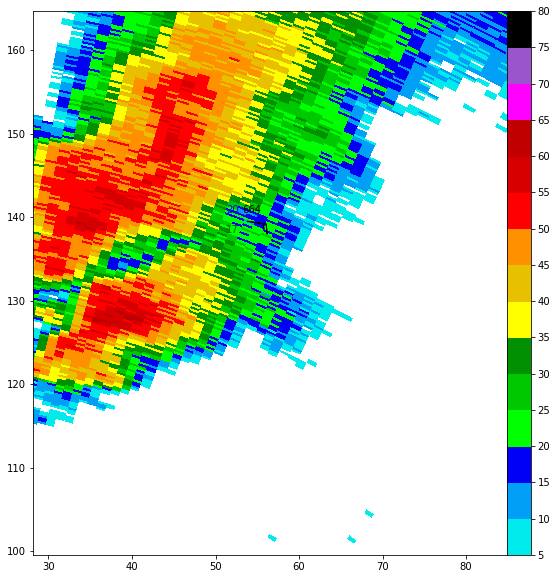

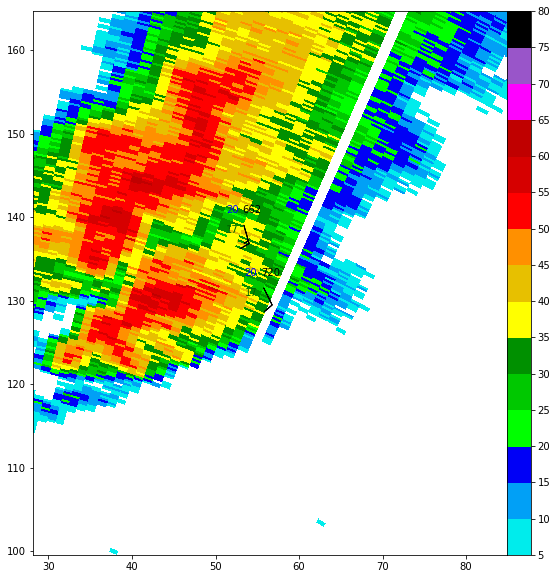

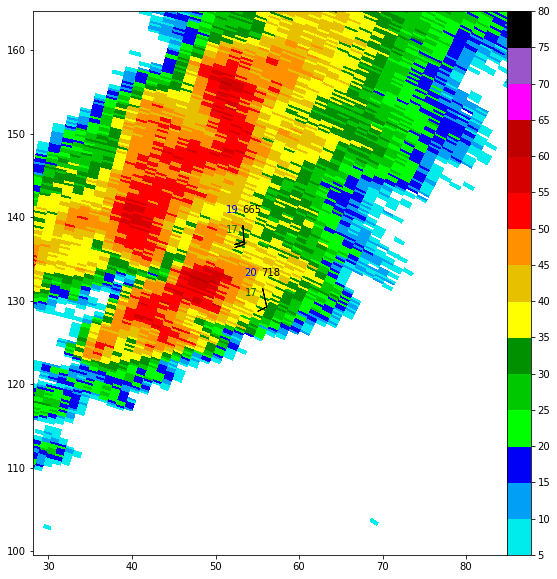

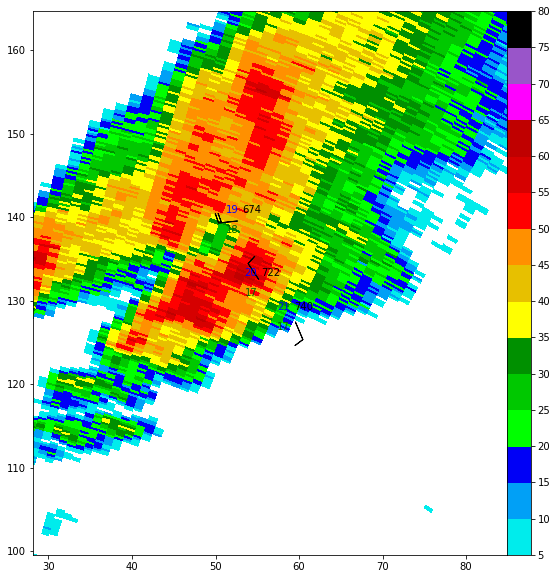

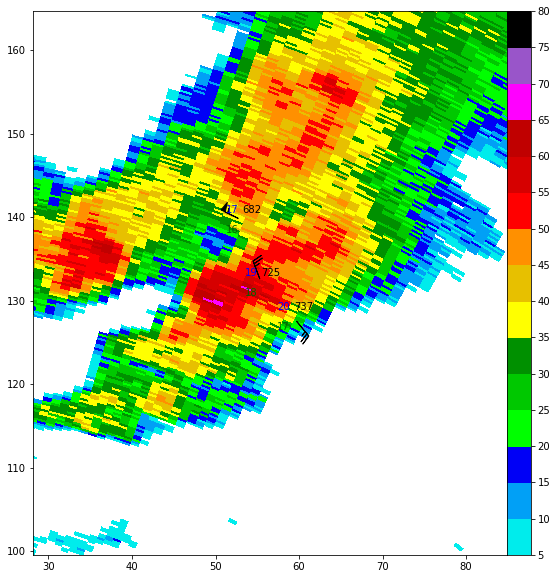

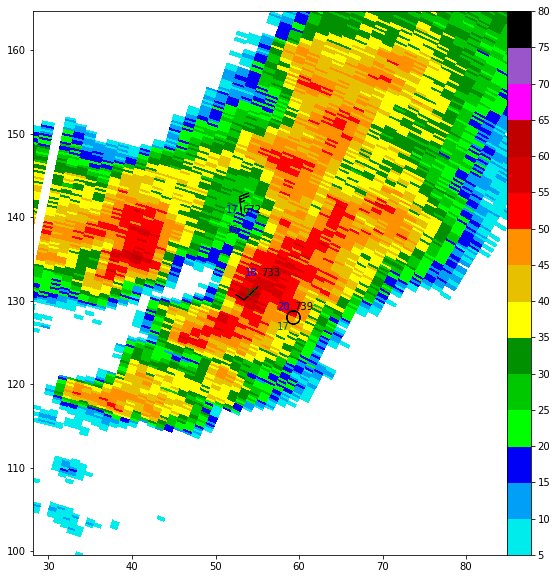

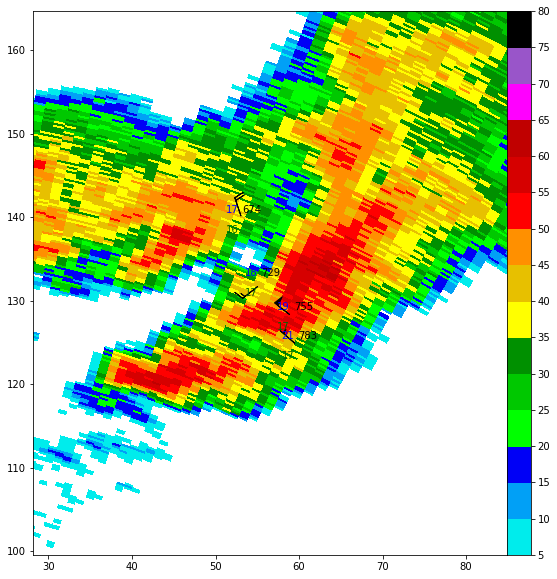

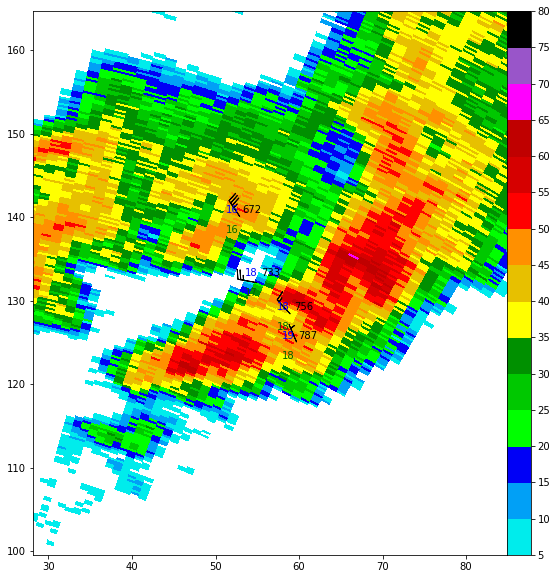

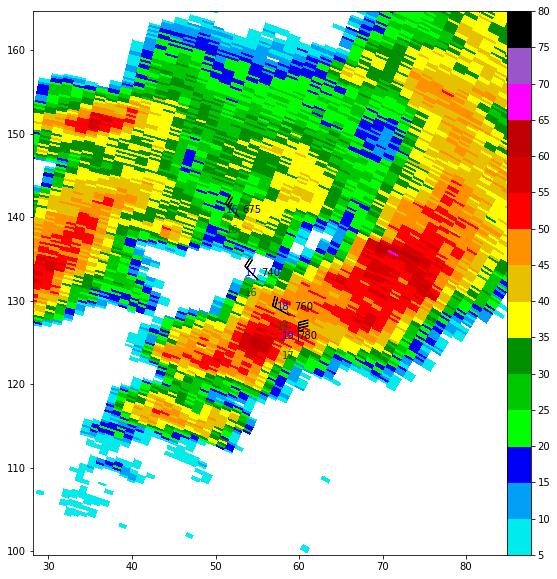

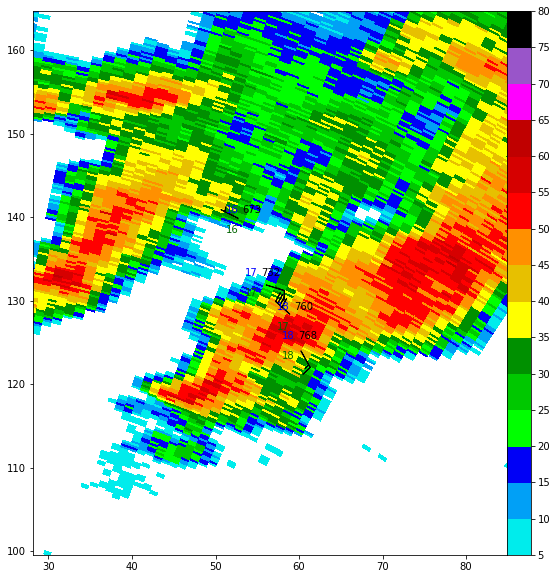

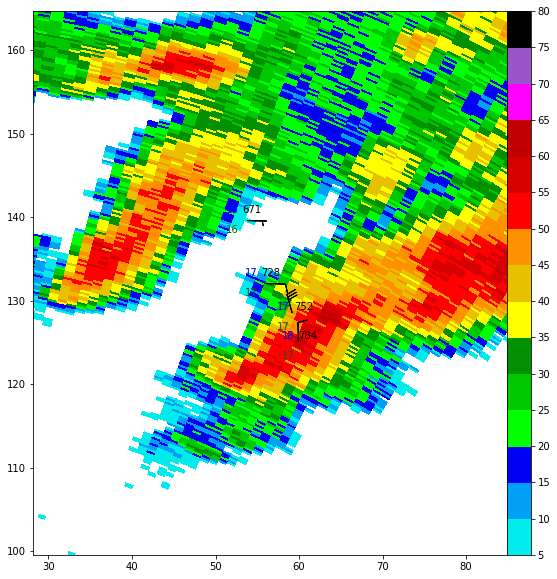

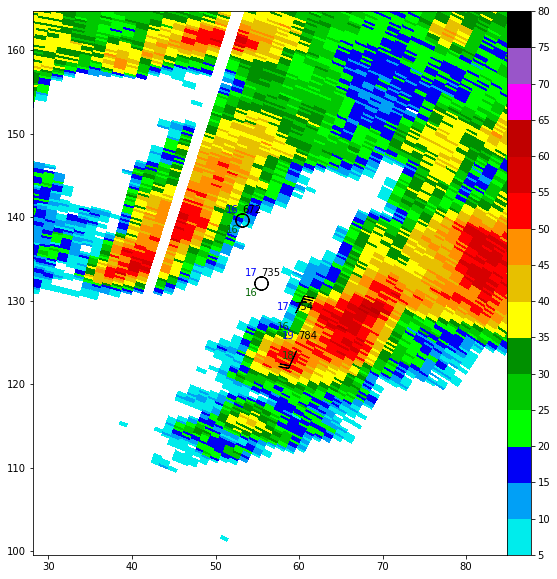

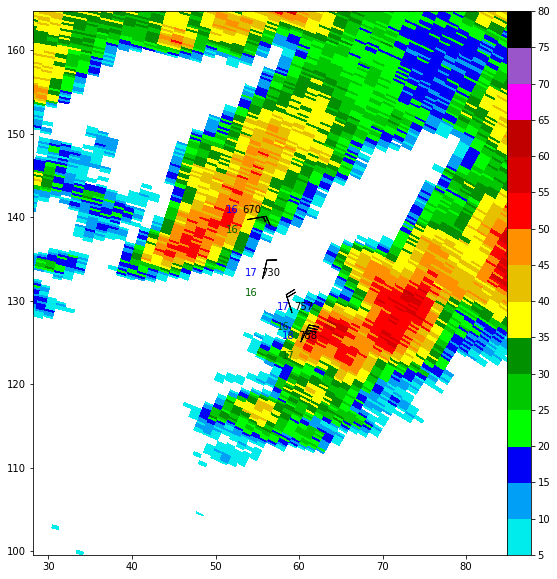

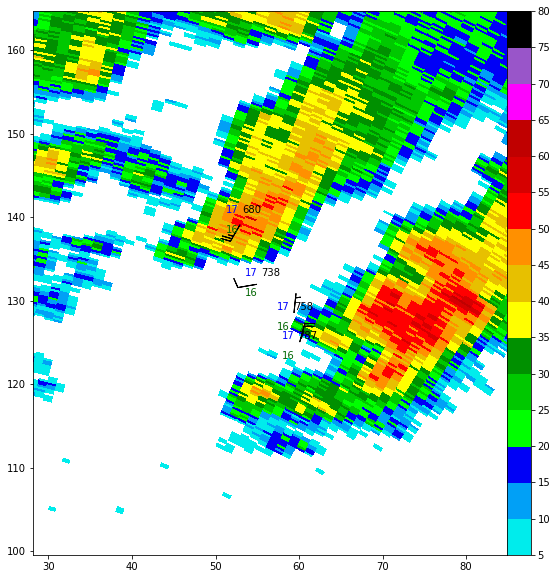

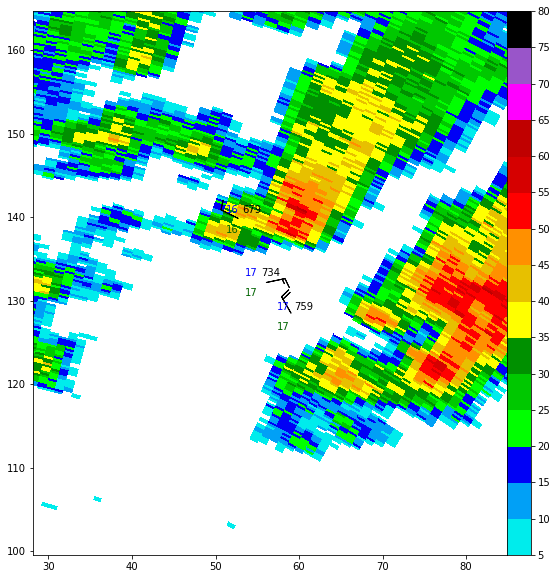

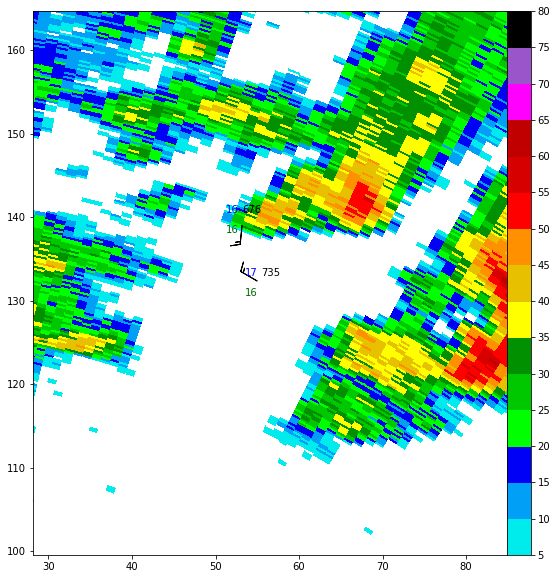

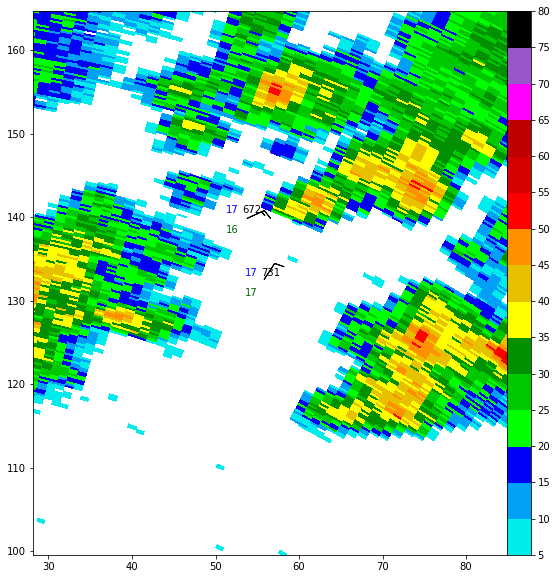

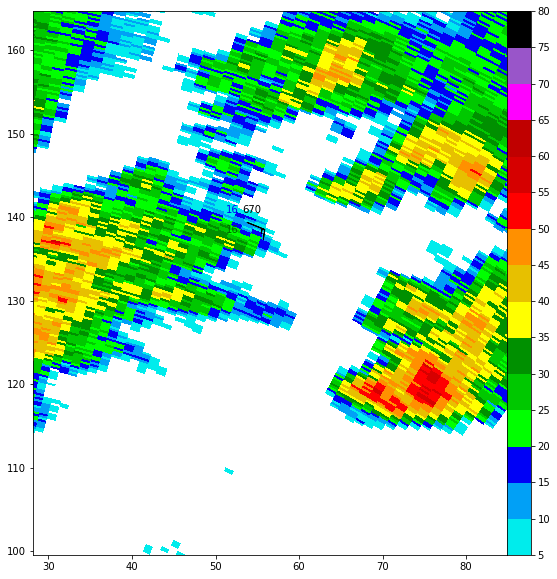

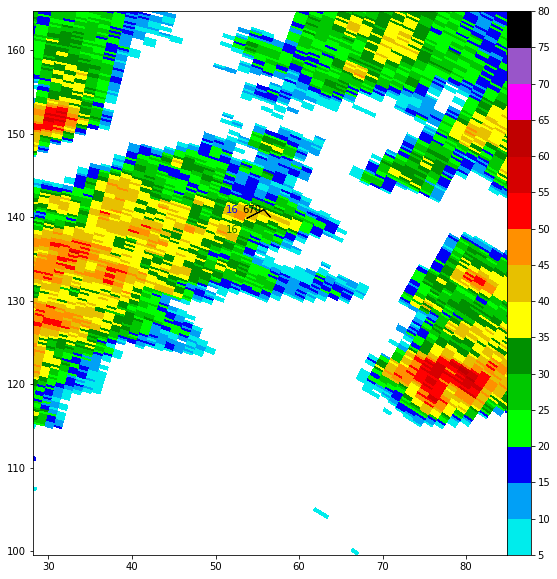

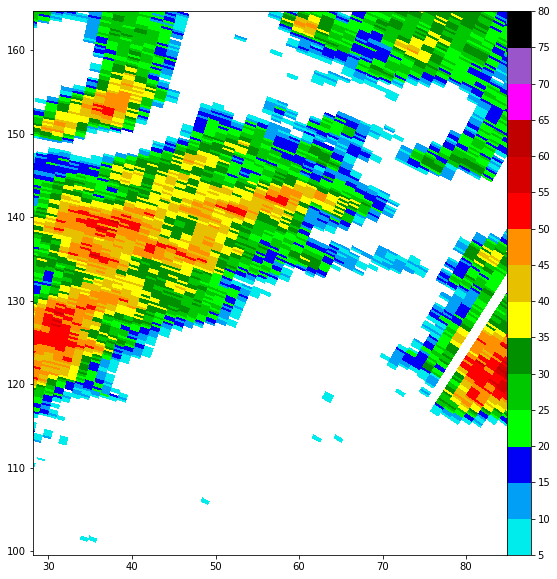

In [221]:
# Go ahead and read in the conventional data at the sweeptimes and plot them:
# %matplotlib notebook
plotdir = '/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/plots'
radlims = [0.0, 250000., 0., 360.]
plotlims = [-1, -1, -1, -1]
ovrmap = False # Currently not working
ovrdis = False
dis_name_list = None
dxy_list = None
fields_D_list = None
deg2rad = np.pi / 180.

# Read time series
dis_dict_at_radar = sim.read_convdata_at_sweeptimes(init_dis_dict, radar_dict)

# Find disdrometer lat/lons and convert them to cartesian coordinates relative to radar lat/lon

dis_dict = sim.get_dis_locs_relative_to_radar(init_dis_dict, radar_dict)

dxlist = [i[0] for i in dis_dict['dradloclist']]
dylist = [i[1] for i in dis_dict['dradloclist']]

# Set plotting limits to center on the disdrometer locations 
if plotlims[0] == -1:
    Dxmin = min(dxlist)
    Dxmax = max(dxlist)
    Dymin = min(dylist)
    Dymax = max(dylist)
    plotlims = [Dxmin - 25000., Dxmax + 25000., Dymin - 25000., Dymax + 25000.]

# Extract stuff from radar dictionary
sweeptimelist = radar_dict['sweeptimelist']
radarsweeplist = radar_dict['radarsweeplist']
outfieldnames = radar_dict['outfieldnameslist'][0] # Just need first entry

# Extract stuff from disdrometer dictionary
templist = dis_dict_at_radar['convdata_at_sweeptimes']['temp']
dewpointlist = dis_dict_at_radar['convdata_at_sweeptimes']['dewpoint']
pressurelist = dis_dict_at_radar['convdata_at_sweeptimes']['pressure']
windspdavgveclist = dis_dict_at_radar['convdata_at_sweeptimes']['windspdavgvec']
winddiravgveclist = dis_dict_at_radar['convdata_at_sweeptimes']['winddiravgvec']


for i, sweeptime in enumerate(sweeptimelist):
    print("i, sweeptime = ", sweeptime)
    figlist, gridlist = pyPIPSradar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[i], ovrmap, 
                                                    ovrdis, dis_name_list, dxy_list, fields_D_list)
    ax = gridlist[0][0]
    
    for j, Dx, Dy in zip(range(len(dxlist)), dxlist, dylist):
        stationplot = StationPlot(ax, [Dx], [Dy])
        stationplot.plot_parameter('NW', [templist[j][i]], color='blue')
        stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
        stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
        u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
        stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))

    figlist[0].canvas.draw()
    figlist[0].set_size_inches(10., 10., forward = True)
    figname = 'PIPS_station_{}.png'.format(sweeptime.strftime('%Y%m%d%H%M%S'))
    figpath = os.path.join(plotdir, figname)
    plt.savefig(figpath, dpi=300, bbox_inches='tight')

In [223]:
# Now do the same for the model output
# First set up some stuff

def get_ARPS_member_dir_and_prefix(member, cycle):
    """
    Gets the proper form for the subdirectory and file prefix name given a member number
    and cycle type (either 'posterior' or 'prior'). member number 0 is interpreted as the mean. 
    """
    if member == 0:
        if cycle in 'posterior':
            member_dir = 'ENamean'
            member_prefix = 'enmean'
        elif cycle in 'prior':
            member_dir = 'ENfmean'
            member_prefix = 'efmean'
    else:
        if cycle in 'posterior':
            member_dir = 'EN{:03d}'.format(int(member))
            member_prefix = 'ena{:03d}'.format(int(member))
        elif cycle in 'prior':
            member_dir = 'ENF{:03d}'.format(int(member))
            member_prefix = 'enf{:03d}'.format(int(member))
    
    return member_dir, member_prefix

modelname = 'ARPS'
microphys = 'ZVD'

# From desired start and end times (UTC) get a range of datetimes and corresponding range of times in
# seconds since model initial time
timestamp_model_init = init_model_dict['timestamp_model_init']  # Start time of model corresponding to 0 s
datetime_model_init = datetime.strptime(timestamp_model_init, '%Y%m%d%H%M%S')

timestamp_start = init_model_dict['timestamp_model_start']  # Start time of desired time window
timestamp_stop = init_model_dict['timestamp_model_stop']  # Stop time of desired time window
datetime_start = datetime.strptime(timestamp_start, '%Y%m%d%H%M%S')
datetime_stop = datetime.strptime(timestamp_stop, '%Y%m%d%H%M%S')
tintv = init_model_dict['model_dt']  # Interval in seconds for model output
tintv_mean = init_model_dict['model_dt_mean'] # Interval in seconds for ensemble mean analysis

datetime_range = CRMutils.get_datetime_range(datetime_start, datetime_stop, tintv)
trange = CRMutils.modeltimes_from_datetimes(datetime_range, datetime_start=datetime_model_init)

datetime_range_mean = CRMutils.get_datetime_range(datetime_start, datetime_stop, tintv_mean)
trange_mean = CRMutils.modeltimes_from_datetimes(datetime_range_mean, datetime_start=datetime_model_init)

#basedir = '/Volumes/scr_fast/Projects/VORTEXSE/simulations/ARPS/2016_IOP3/3DVAR/1km0331163DVARCA00005min180_3km030015min540'
fileformat = init_model_dict['fileformat']
expname = '1km453x453_newse'
basedir = init_model_dict['basedirname']
member = 13 # 0 is for ensemble mean
cycle = 'posterior'
member_dir, member_prefix = get_ARPS_member_dir_and_prefix(member, cycle)
member_absdir = os.path.join(basedir, expname, member_dir)
trailer = ''
nproc_x = 15
nproc_y = 6

if member == 0:
    model_trange_sec = trange_mean
    model_datetime_range = datetime_range_mean
else:
    model_trange_sec = trange
    model_datetime_range = datetime_range
    
model_dict = init_model_dict.copy()

model_dict['trange_member'] = trange
model_dict['trange_mean'] = trange_mean
model_dict['datetime_range_member'] = datetime_range
model_dict['datetime_range_mean'] = datetime_range_mean


if member == 0:
    model_dict['trange'] = trange_mean
    model_dict['datetime_range'] = datetime_range_mean
else:
    model_dict['trange'] = trange
    model_dict['datetime_range'] = datetime_range
    
print(model_datetime_range)

[datetime.datetime(2016, 3, 31, 22, 0), datetime.datetime(2016, 3, 31, 22, 1), datetime.datetime(2016, 3, 31, 22, 2), datetime.datetime(2016, 3, 31, 22, 3), datetime.datetime(2016, 3, 31, 22, 4), datetime.datetime(2016, 3, 31, 22, 5), datetime.datetime(2016, 3, 31, 22, 6), datetime.datetime(2016, 3, 31, 22, 7), datetime.datetime(2016, 3, 31, 22, 8), datetime.datetime(2016, 3, 31, 22, 9), datetime.datetime(2016, 3, 31, 22, 10), datetime.datetime(2016, 3, 31, 22, 11), datetime.datetime(2016, 3, 31, 22, 12), datetime.datetime(2016, 3, 31, 22, 13), datetime.datetime(2016, 3, 31, 22, 14), datetime.datetime(2016, 3, 31, 22, 15), datetime.datetime(2016, 3, 31, 22, 16), datetime.datetime(2016, 3, 31, 22, 17), datetime.datetime(2016, 3, 31, 22, 18), datetime.datetime(2016, 3, 31, 22, 19), datetime.datetime(2016, 3, 31, 22, 20), datetime.datetime(2016, 3, 31, 22, 21), datetime.datetime(2016, 3, 31, 22, 22), datetime.datetime(2016, 3, 31, 22, 23), datetime.datetime(2016, 3, 31, 22, 24), datetime.

In [8]:
# Load the ARPS grid
# Get file path for grdbas file (note that call to read_grid handles the reading of the individual patches)
# If the grdbas file doesn't exist, fall back to a history file
grdbas_path = arps_read.get_file_path(member_absdir, member_prefix, fileformat, filetype='grdbas')

patch_x = 1
patch_y = 1
grdbas_path_test = arps_read.add_patch_number(grdbas_path, patch_x, patch_y)

if not os.path.exists(grdbas_path_test):
    print("grdbas file doesn't exist, trying a history file!")
    grdbas_path = arps_read.get_file_path(member_absdir, member_prefix, fileformat, time=model_trange_sec[0], 
                                          filetype='history')
    grdbas_path_test = arps_read.add_patch_number(grdbas_path, patch_x, patch_y)

    print(grdbas_path_test)
    print(os.path.exists(grdbas_path_test))

# Read in grid information
grid_dict = arps_read.readarpsgrid(grdbas_path, nproc_x=nproc_x, nproc_y=nproc_y)
print(grid_dict.keys())

# Get map projection information and create a Basemap instance
# TODO: convert to use cartopy!

ctrlat, ctrlon, trulat1, trulat2, trulon = arps_read.readarpsmap(grdbas_path, nproc_x=nproc_x, nproc_y=nproc_y)

dx = grid_dict['dx']
dy = grid_dict['dy']
nx = grid_dict['nx']
ny = grid_dict['ny']

mapwidth = nx * dx
mapheight = ny * dy

bgmap = Basemap(projection='lcc', width=mapwidth, height=mapheight, lat_1=trulat1,
                lat_2=trulat2, lat_0=ctrlat, lon_0=ctrlon, resolution='h',
                area_thresh=10., suppress_ticks=False)



dict_keys(['nx', 'ny', 'nz', 'dx', 'dy', 'dz', 'x', 'y', 'z', 'zp', 'xs', 'ys', 'zs', 'zpagl', 'zsagl'])


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [220]:
# Put the basemap instance into the grid_dict
grid_dict['bgmap'] = bgmap

# Find coordinates of PIPS stations in the model
dis_dict = sim.get_dis_locs_arps_real_grid(dis_dict, grid_dict)


coord_array = np.array(dis_dict['dmodcrdlist'])
print(dis_dict['dgeoloclist'])

print(coord_array) 
print(coord_array.shape) 
print(coord_array[0]) 
# coord_array = coord_array.T

[(35.046499999999995, -87.67749219783126, 254.11713832319492), (35.084130703422055, -87.7198528728348, 275.80548162230673), (35.015666666666675, -87.67168627067865, 226.55306760453303), (35.1515, -87.74416666666664, 325.88117263843645)]
[[226.22825433 253.40098553]
 [222.37480154 257.58480521]
 [226.75691376 249.97353499]
 [220.16784265 265.07492488]]
(4, 2)
[226.22825433 253.40098553]


[226.2282543262902, 222.37480154110668, 226.75691376130987, 220.1678426462494]
[253.40098552587978, 257.58480521031026, 249.97353498544854, 265.074924876145]
[226728.2543262902, 222874.8015411067, 227256.91376130987, 220667.8426462494]
[253900.98552587978, 258084.80521031027, 250473.53498544852, 265574.924876145]
[195667.8426462494, 252256.91376130987, 225473.53498544852, 290574.924876145]
197 254 226 293
310316 221203
2016-03-31 22:12:00
2016 3 31 22 12 0
2016-03-31 22:12:03 2016-03-31 22:12:00
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0
310316 220133
2016-03-31 22:01:30
2016 3 31 22 1 30
2016-03-31 22:01:33 2016-03-31 22:01:30
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0
310316 222503
2016-03-

Loading time  14820.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf014820
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var dict (inside retrieve_variables):  dict_keys([])
needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  14880.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf014880
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var dict (inside retrieve_variables):  dict_keys([])
needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Loading time  15660.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf015660
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var dict (inside retrieve_variables):  dict_keys([])
needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  15720.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf015720
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var dict (inside retrieve_variables):  dict_keys([])
needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91

needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  16620.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf016620
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var dict (inside retrieve_variables):  dict_keys([])
needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  16680.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf016680
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var

needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  17580.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf017580
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var dict (inside retrieve_variables):  dict_keys([])
needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  17640.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf017640
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var

needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  18540.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf018540
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var dict (inside retrieve_variables):  dict_keys([])
needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  18600.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf018600
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var

needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  19500.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf019500
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var dict (inside retrieve_variables):  dict_keys([])
needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  19560.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN013/ena013.hdf019560
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var

needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)


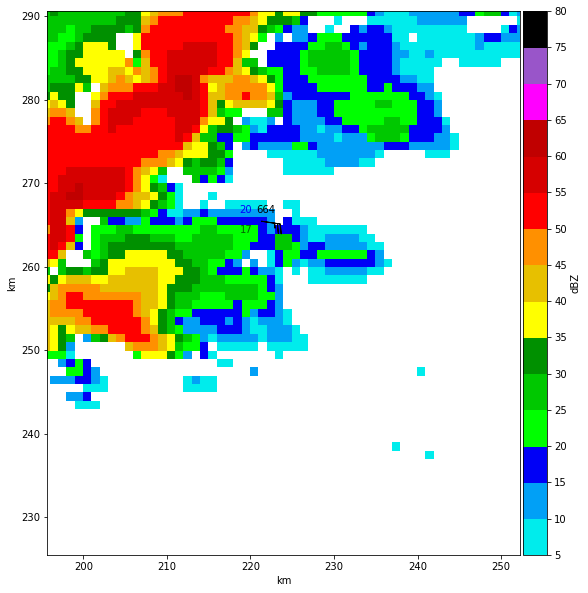

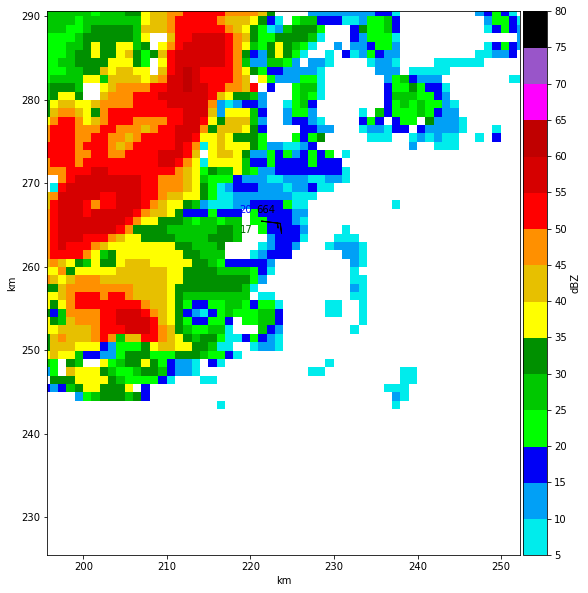

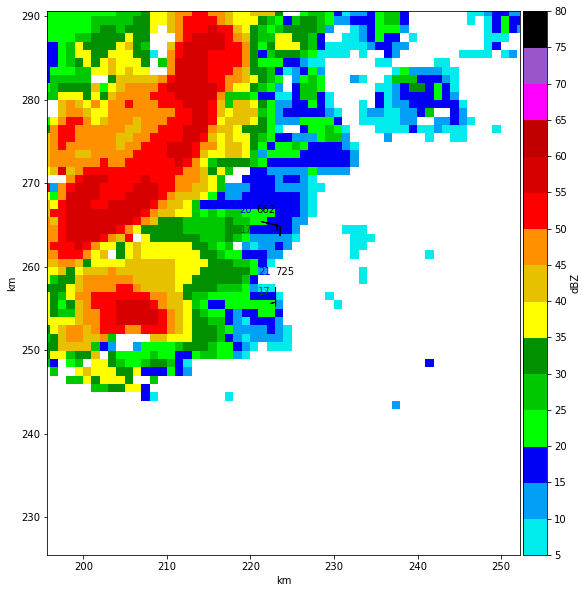

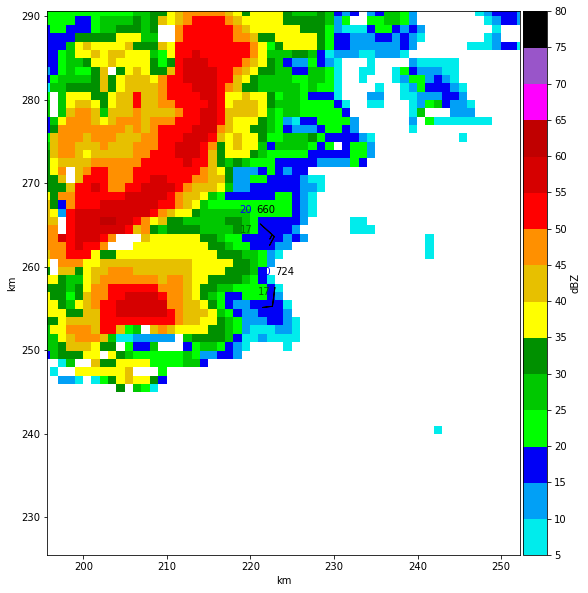

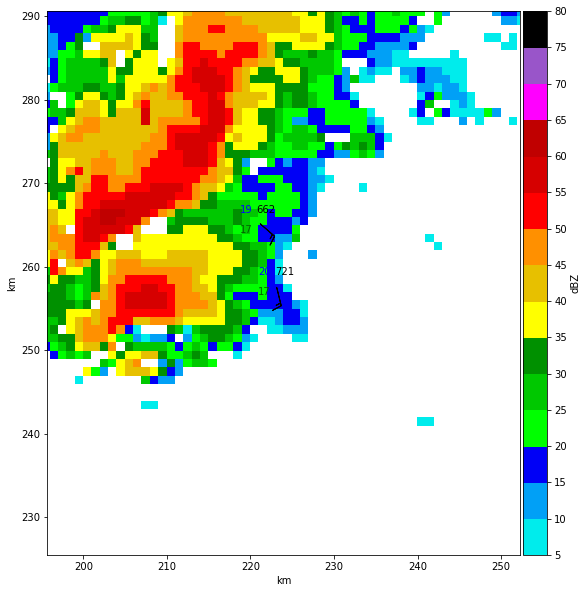

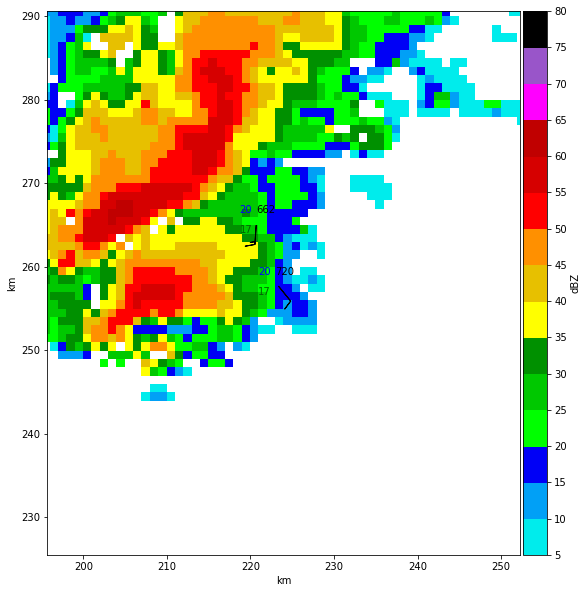

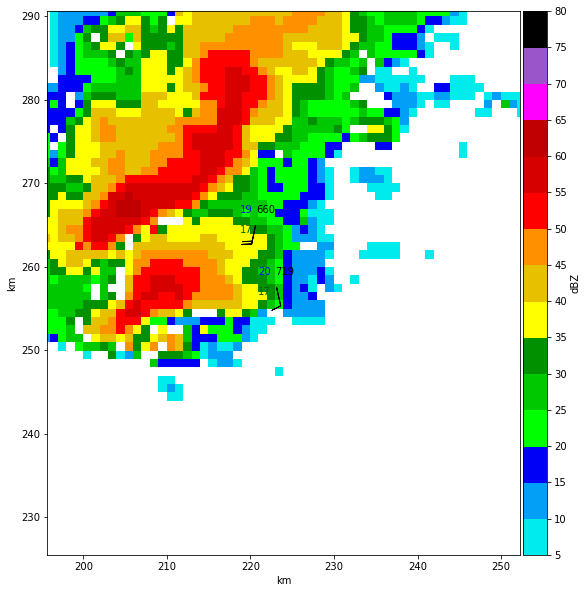

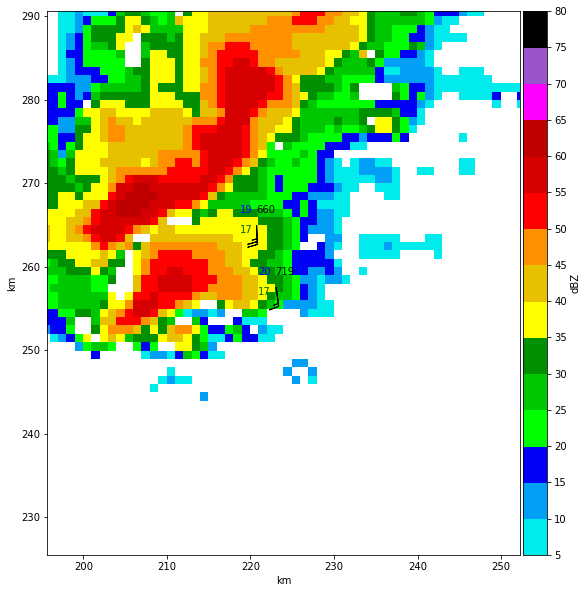

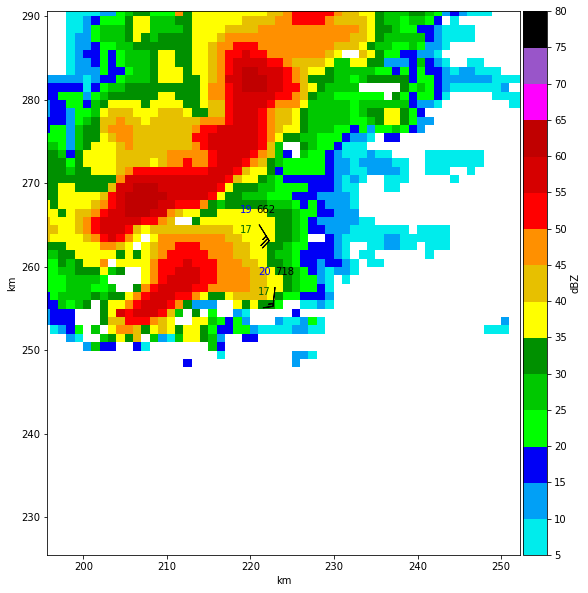

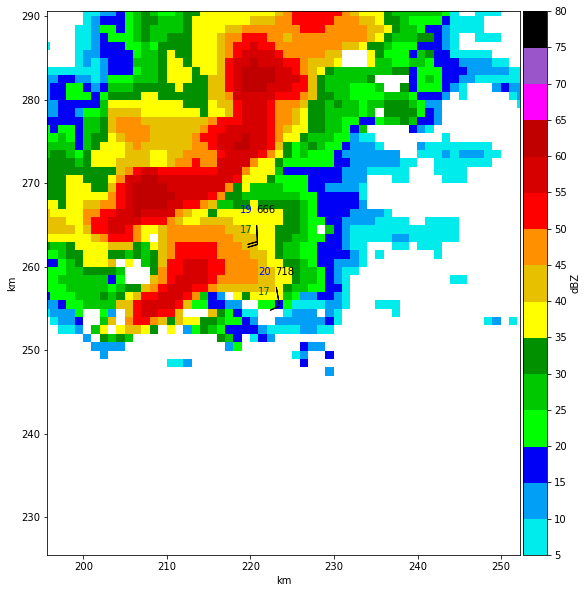

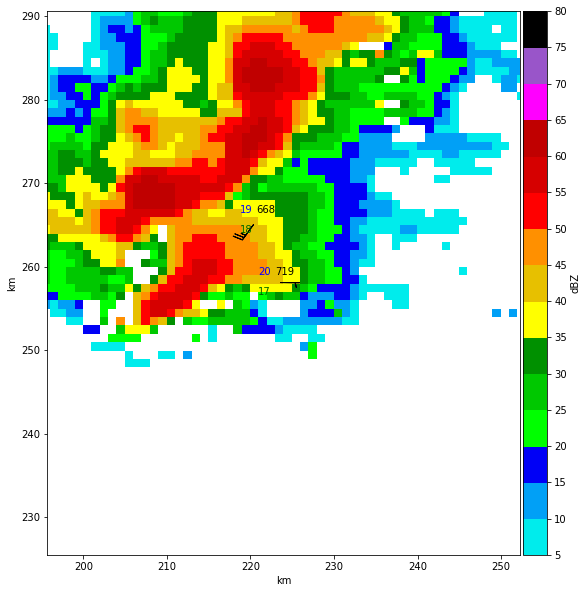

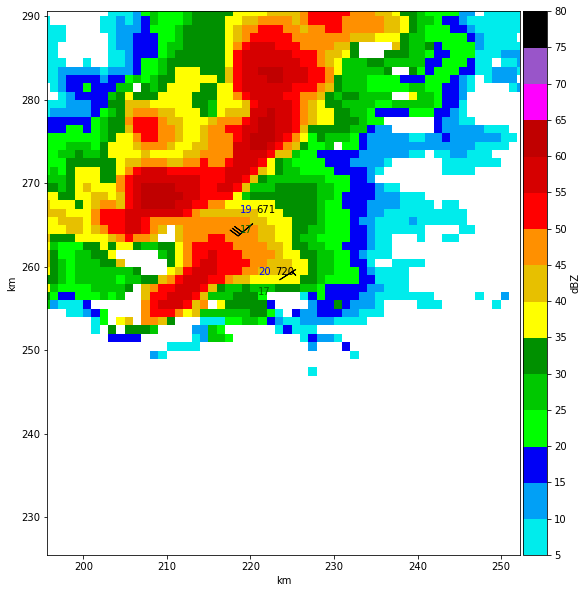

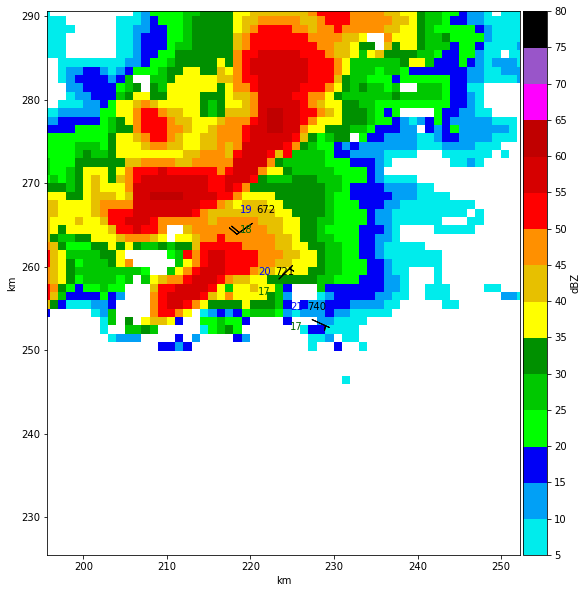

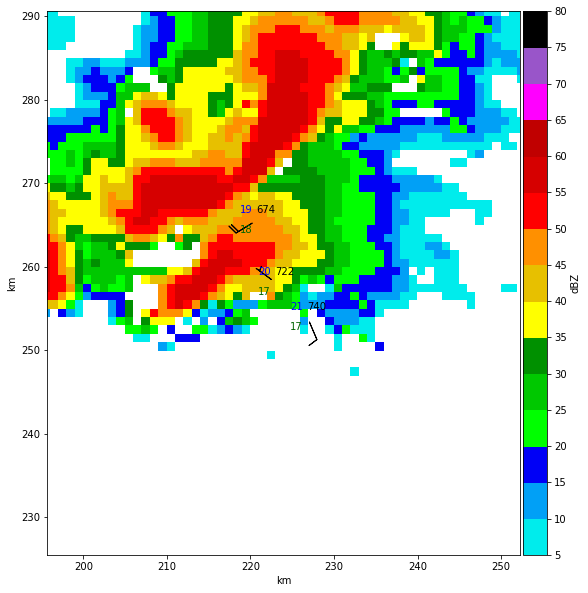

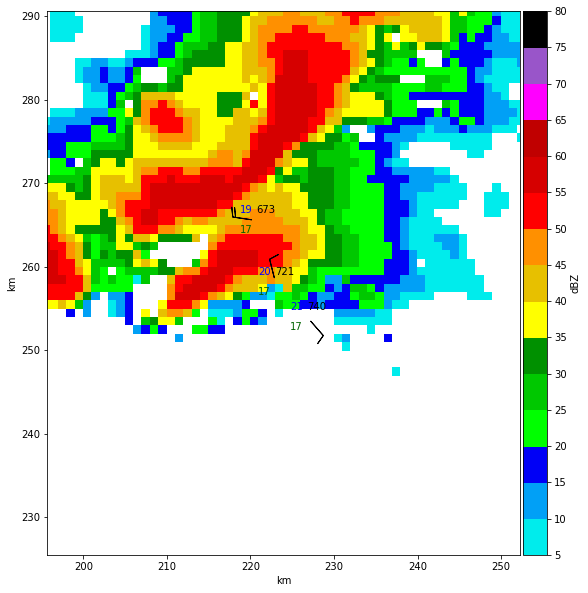

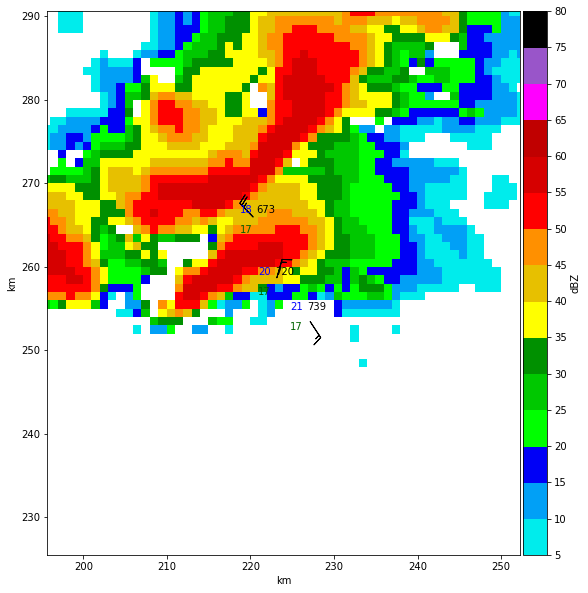

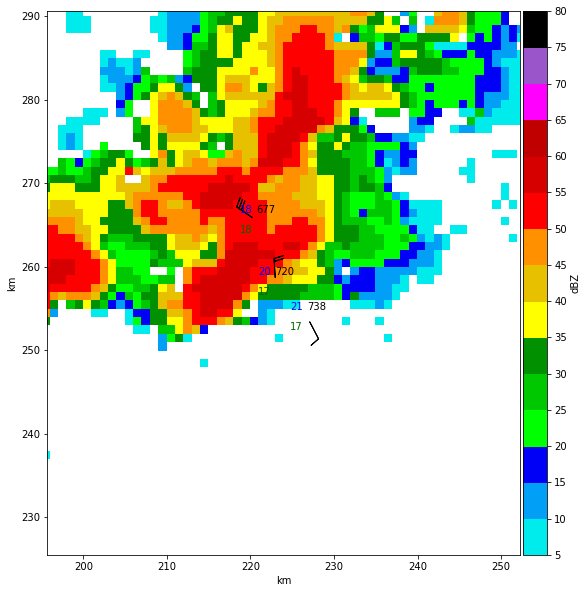

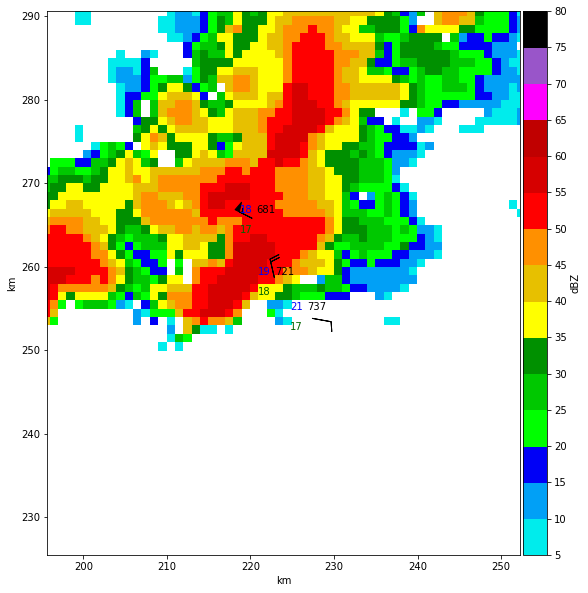

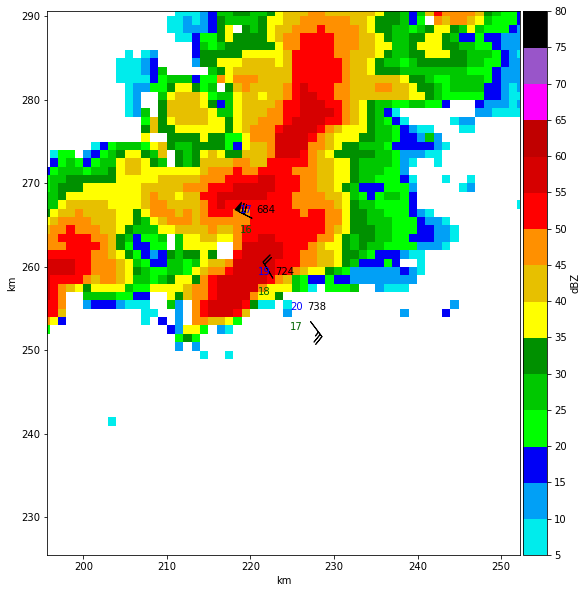

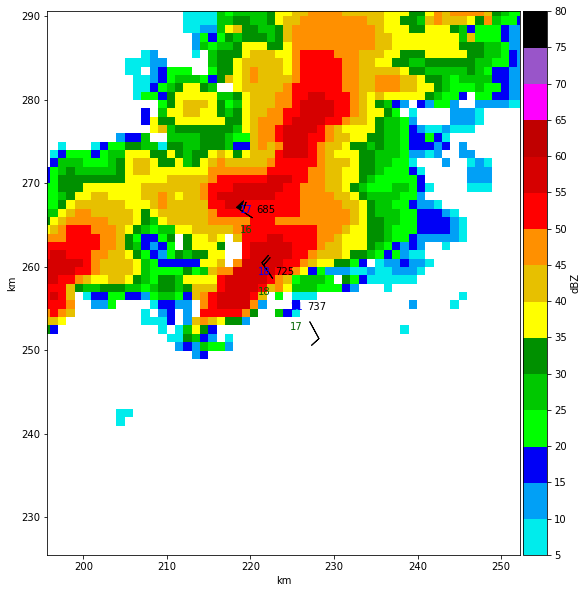

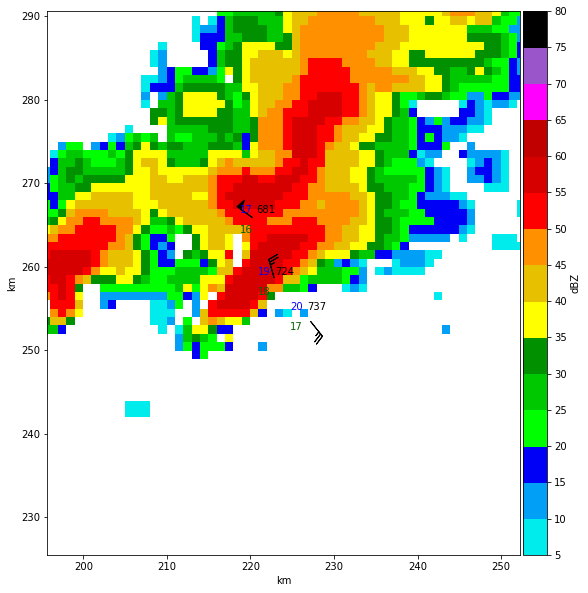

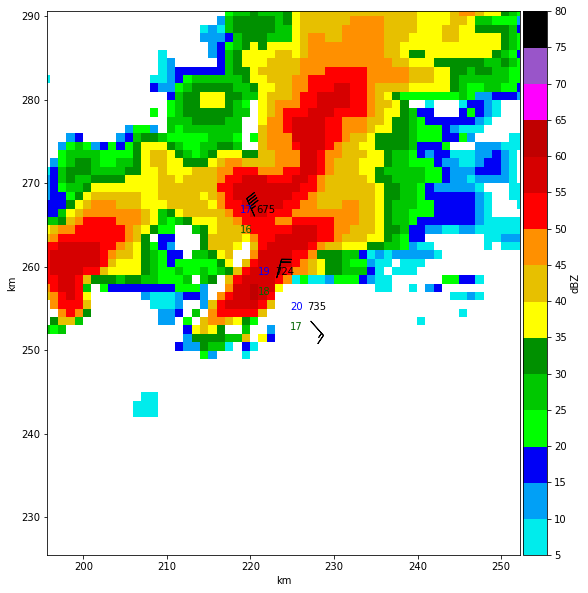

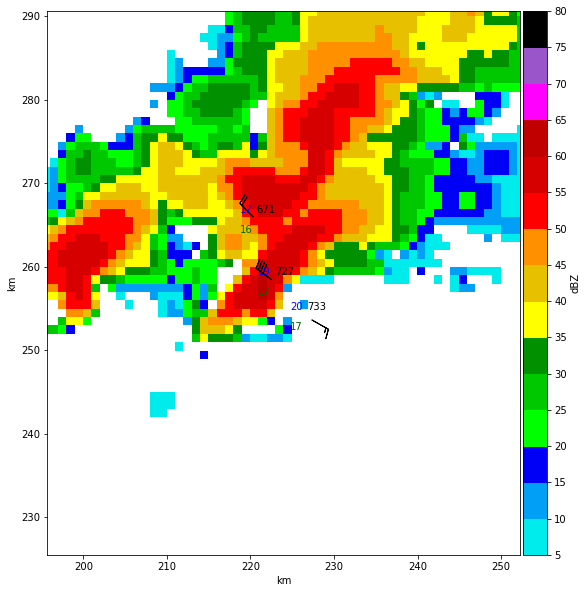

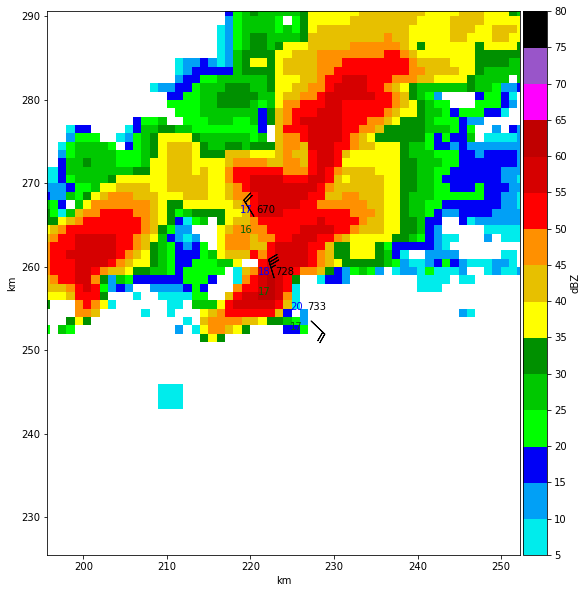

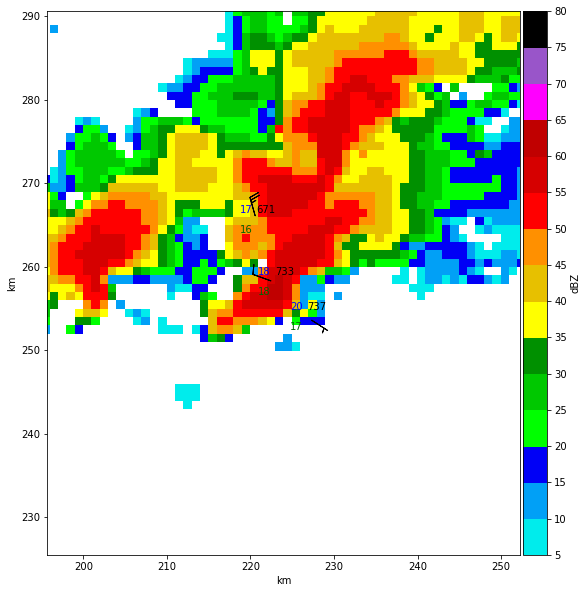

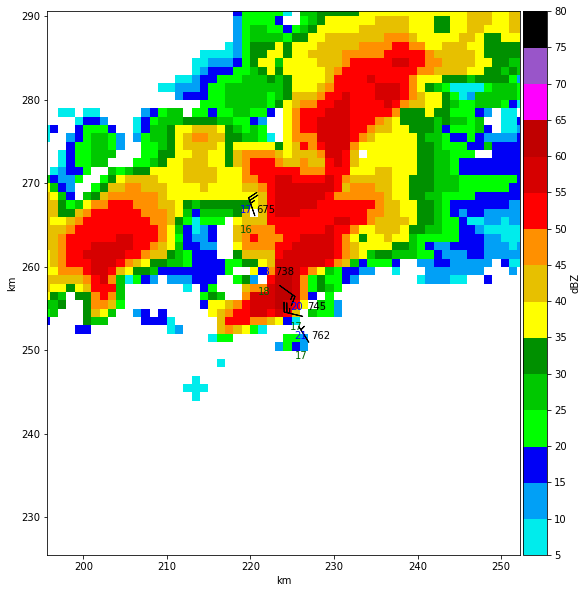

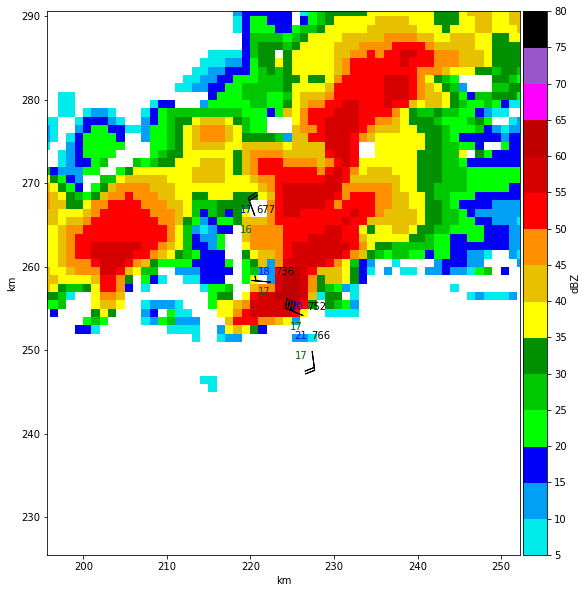

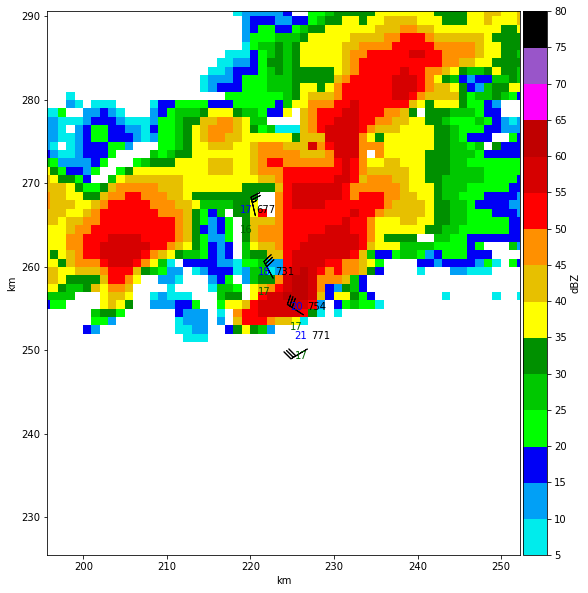

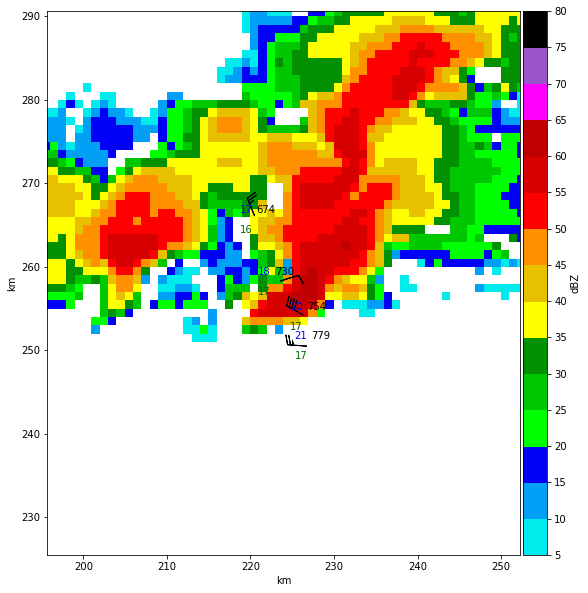

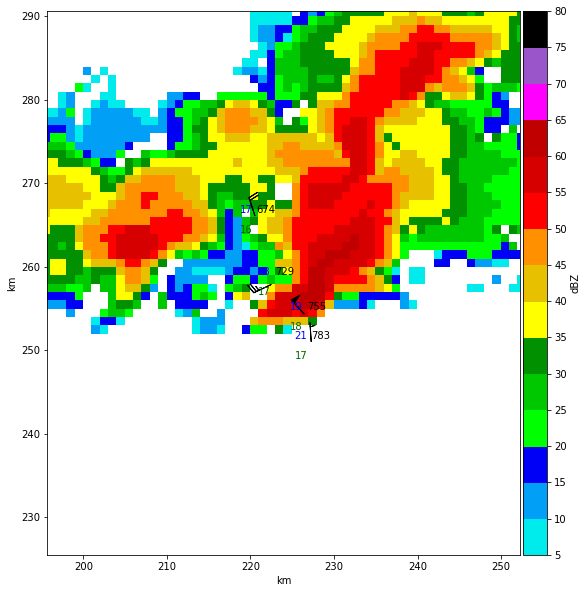

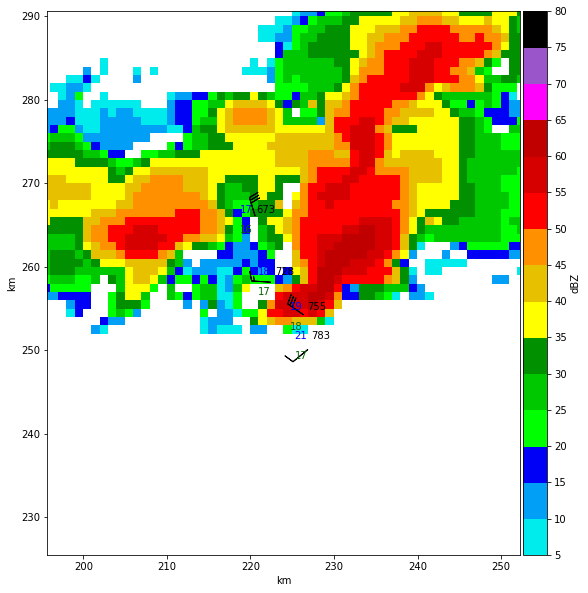

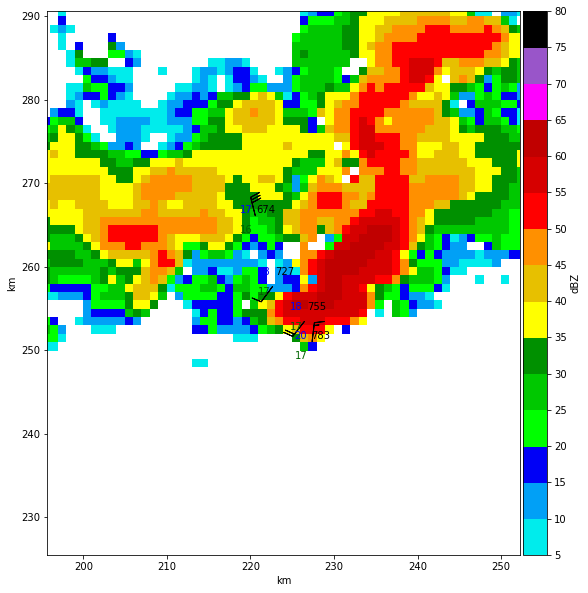

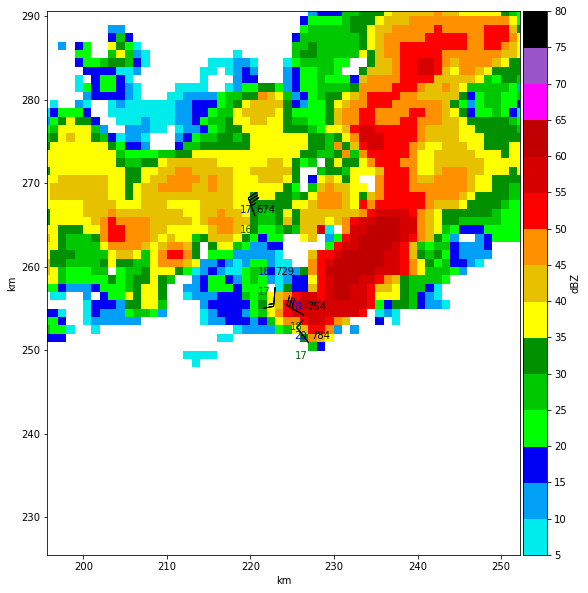

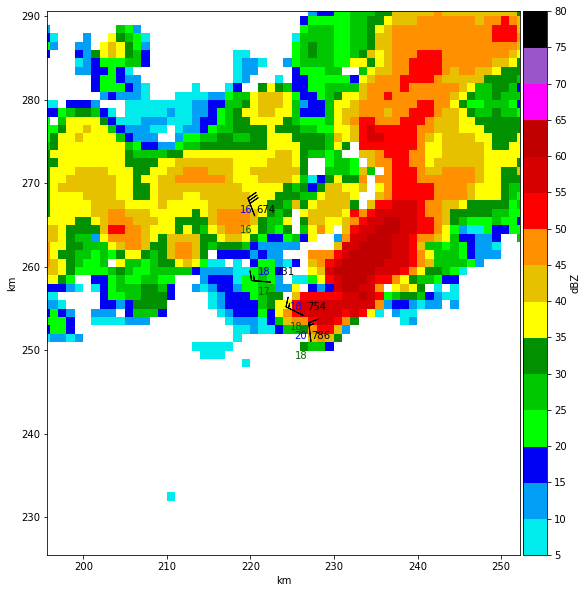

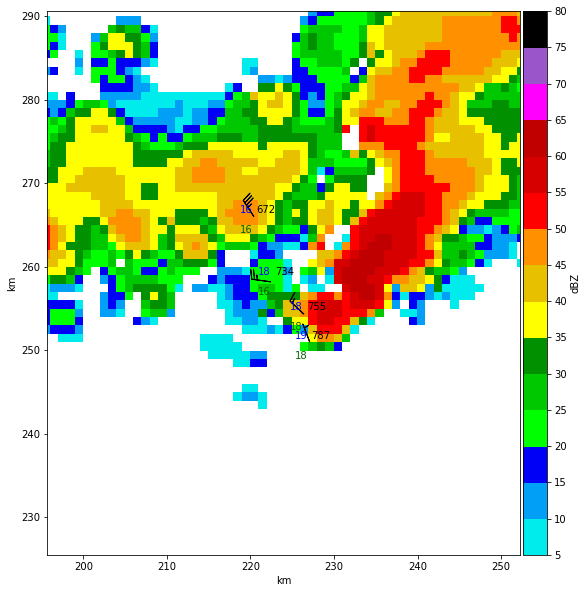

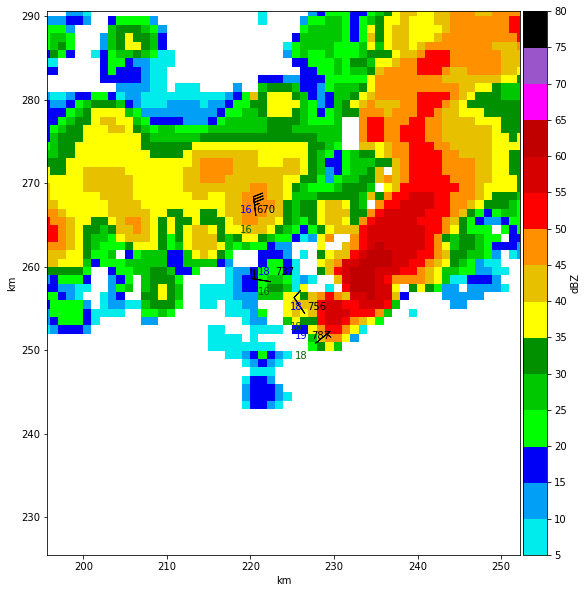

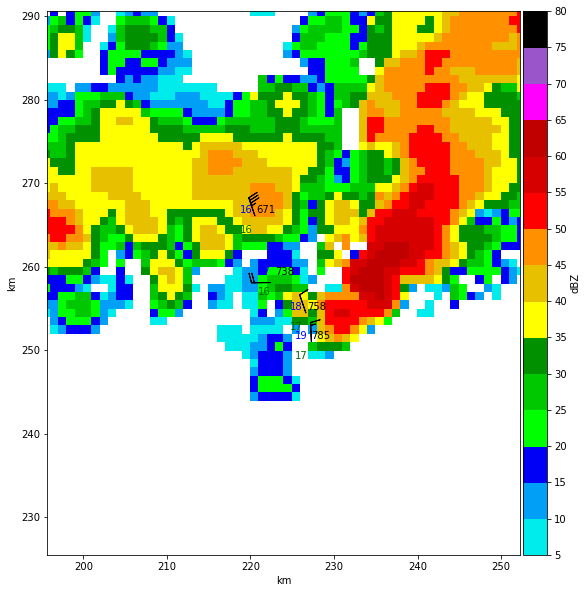

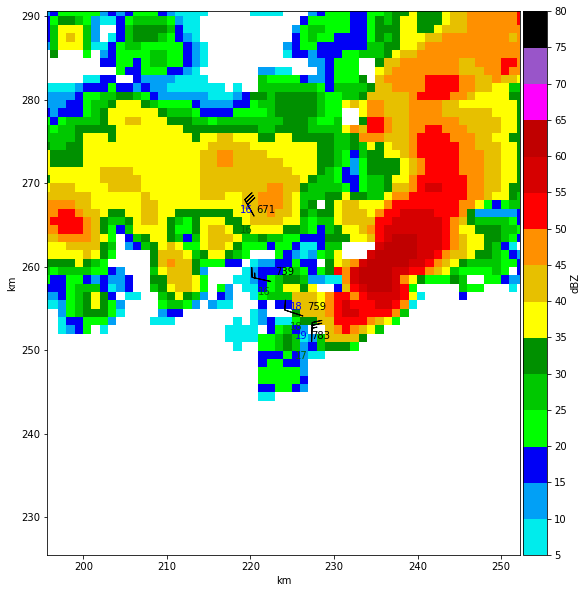

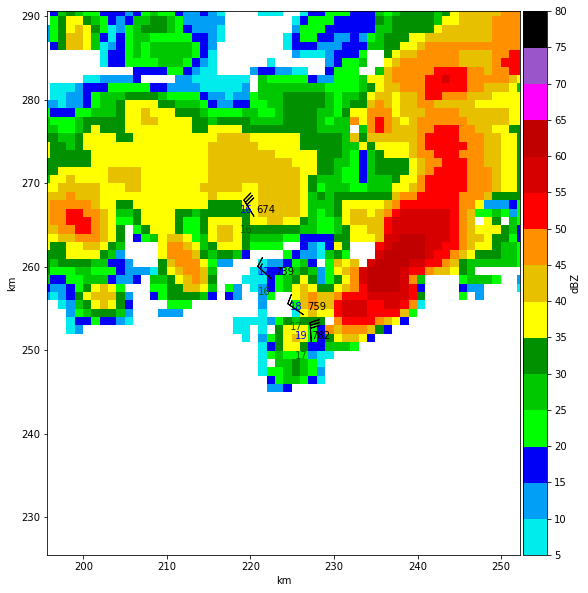

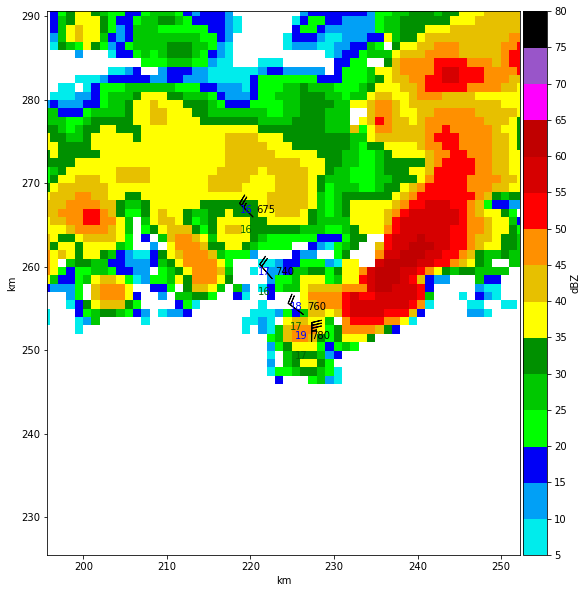

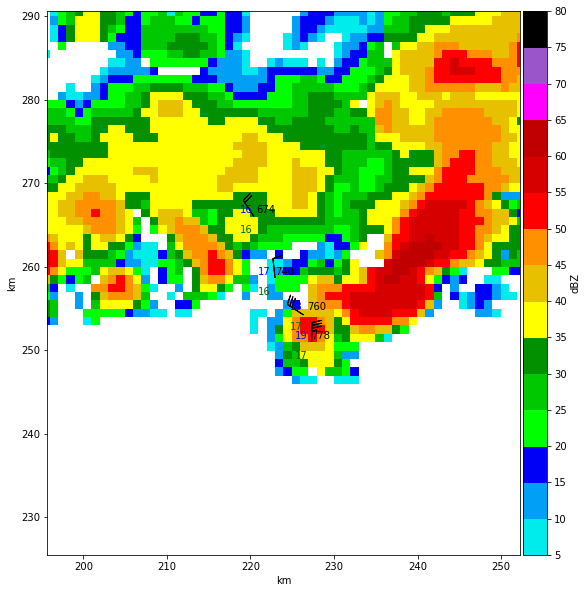

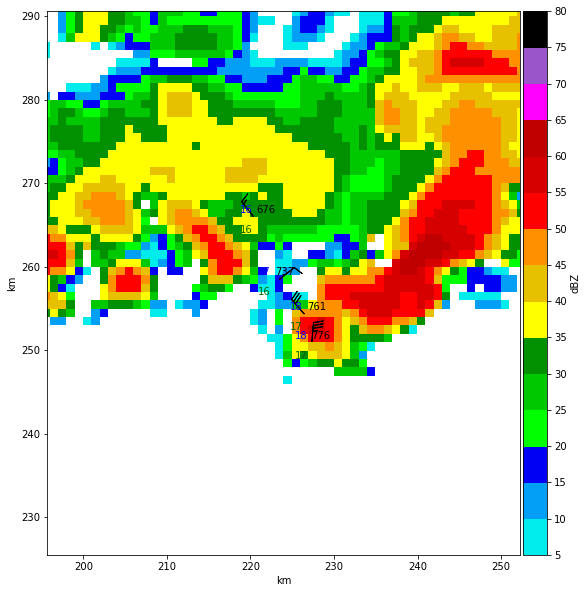

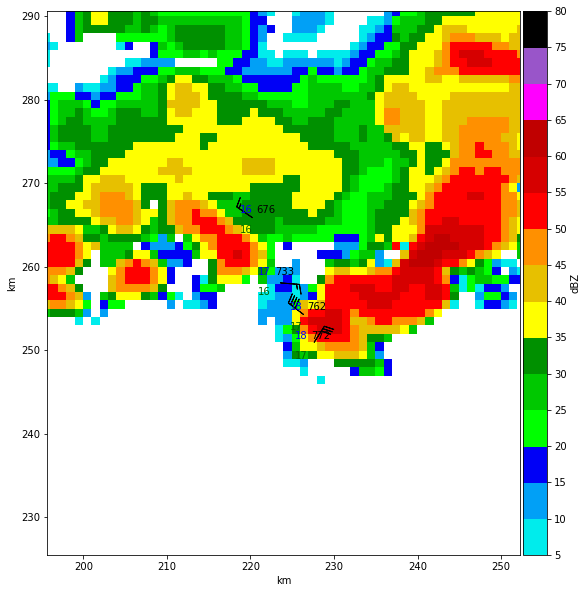

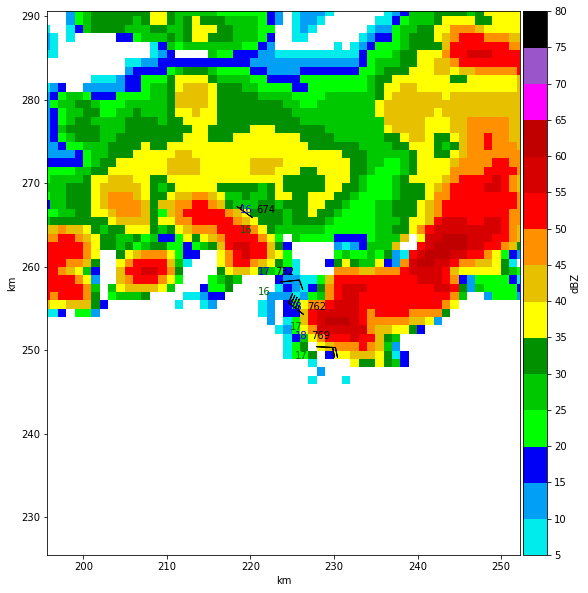

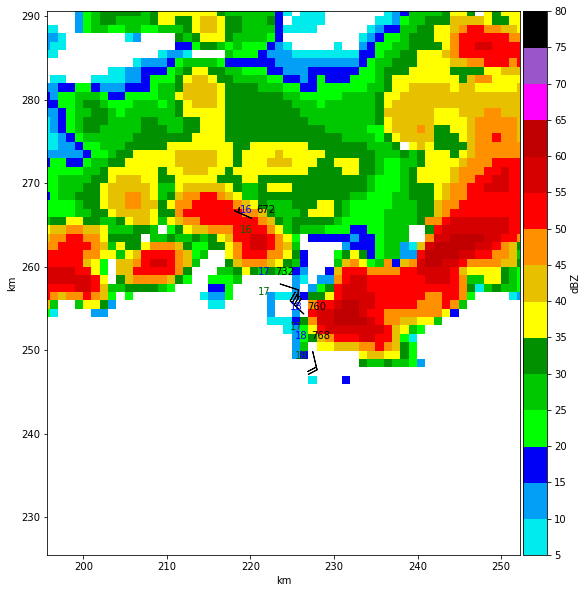

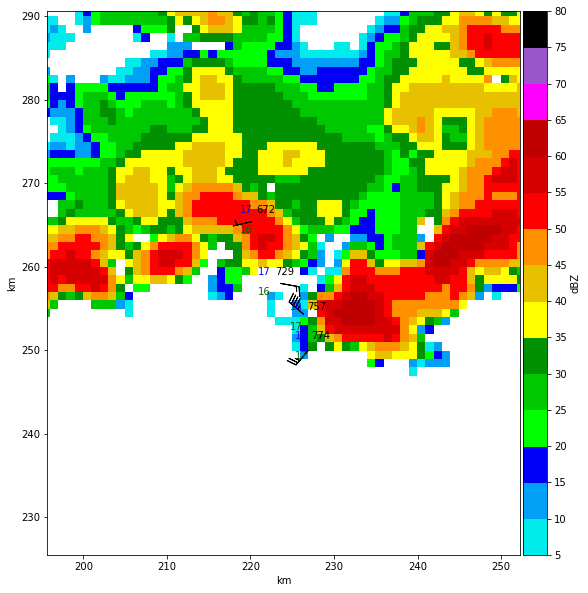

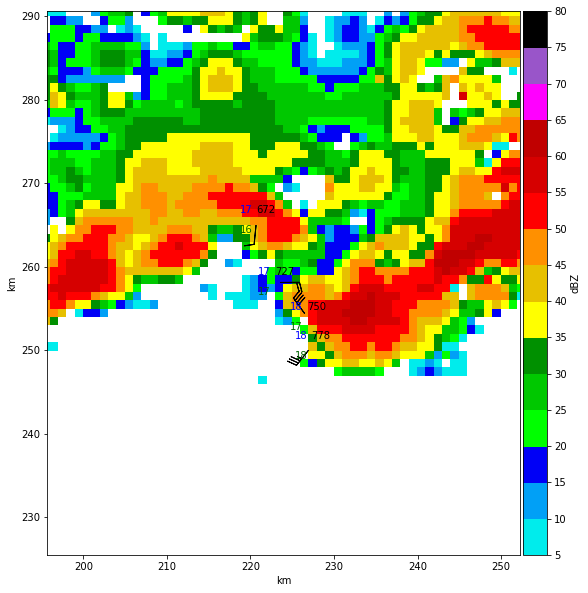

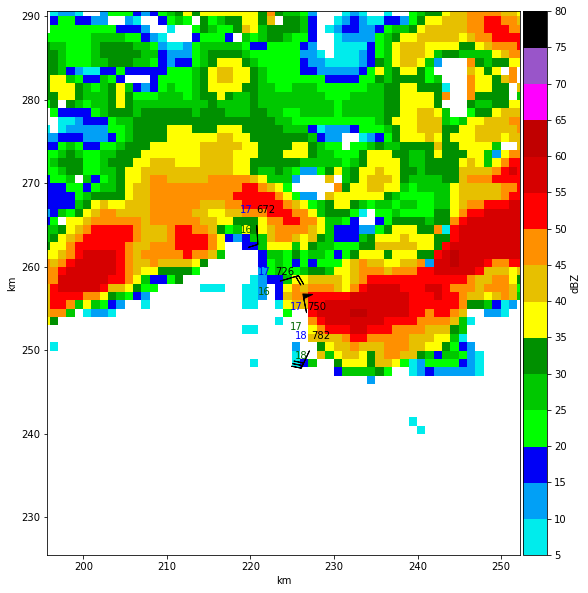

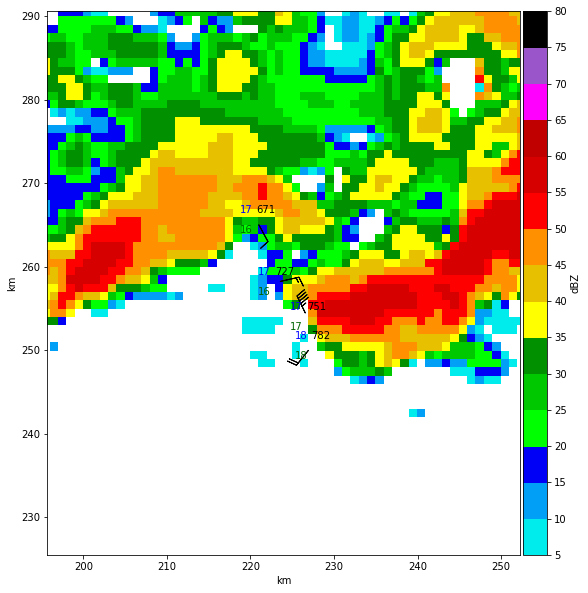

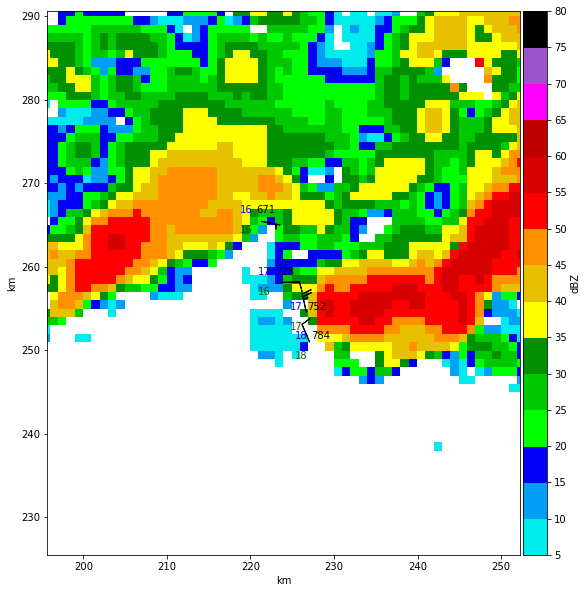

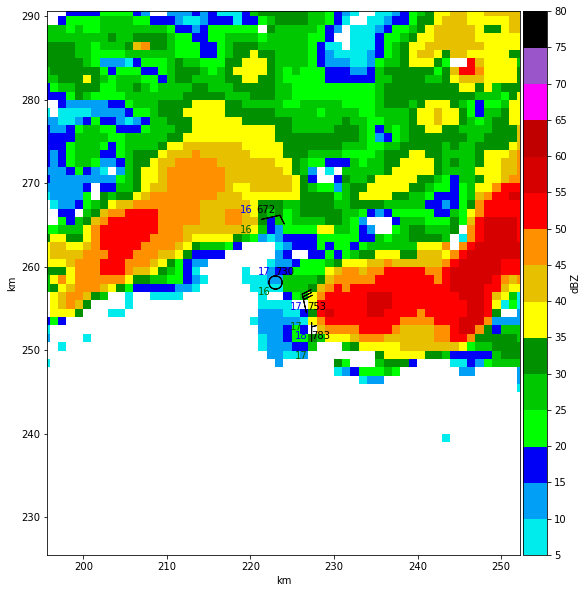

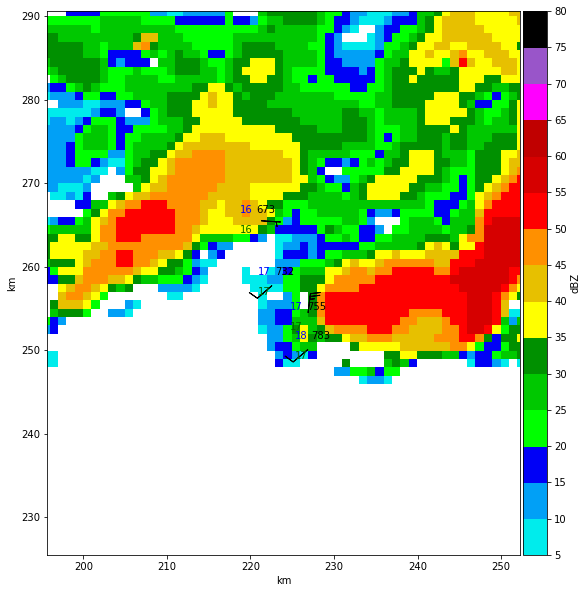

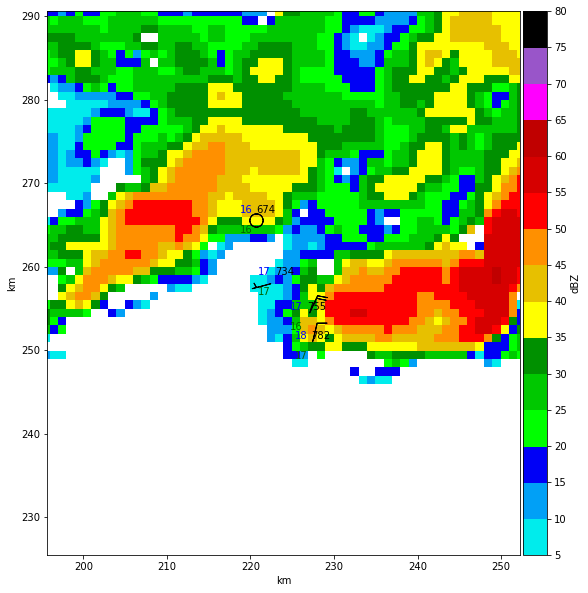

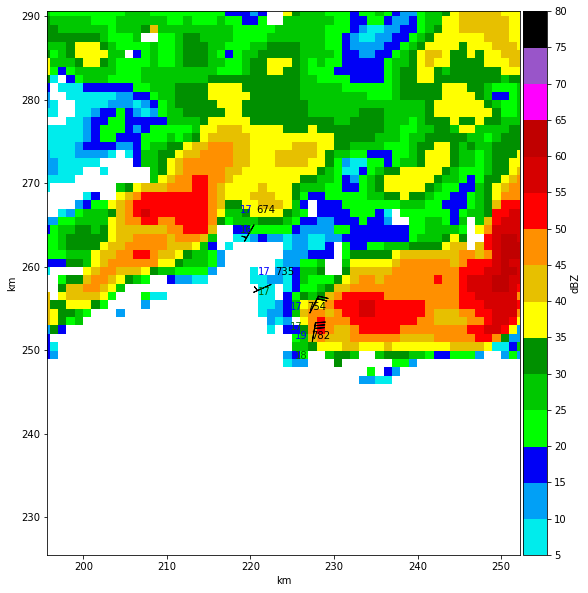

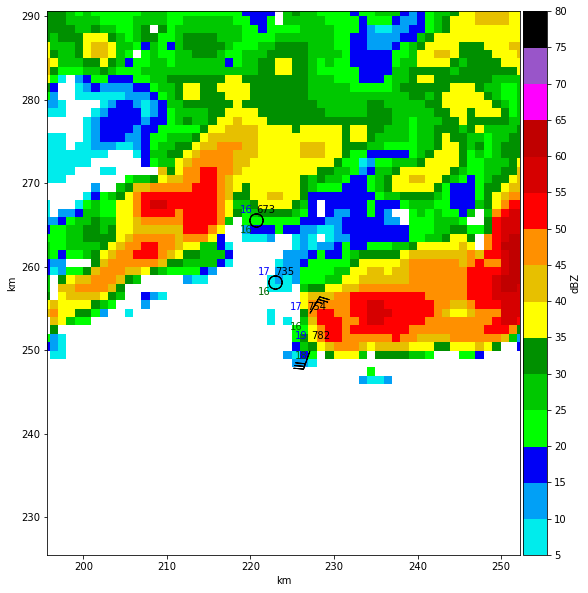

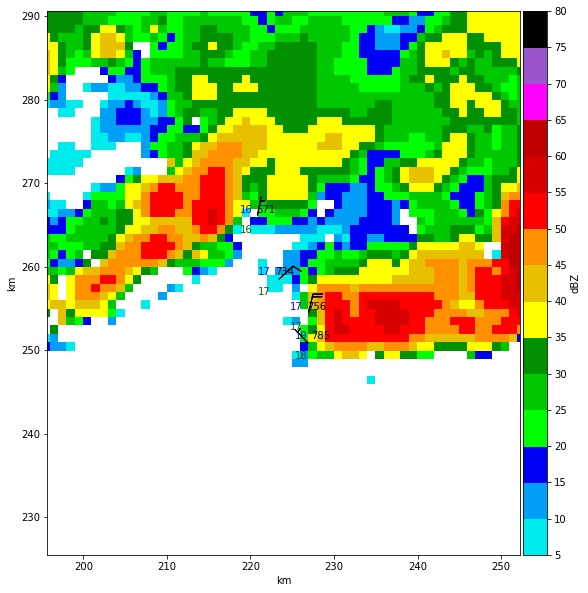

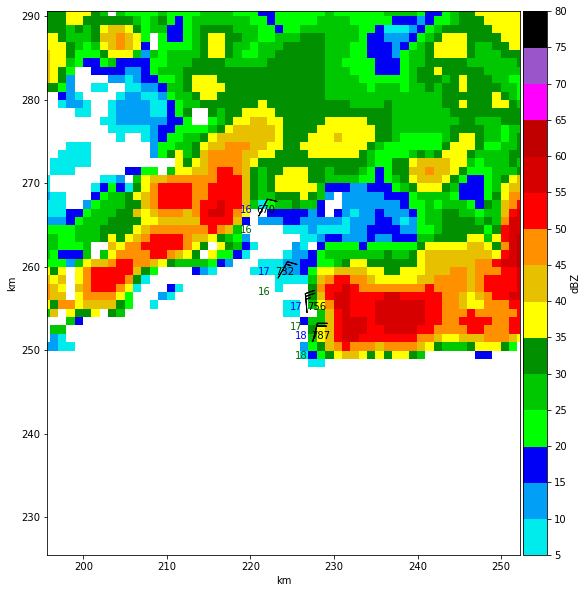

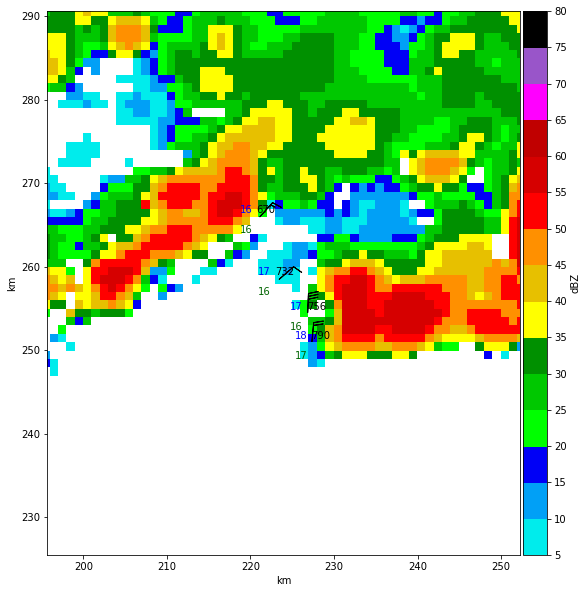

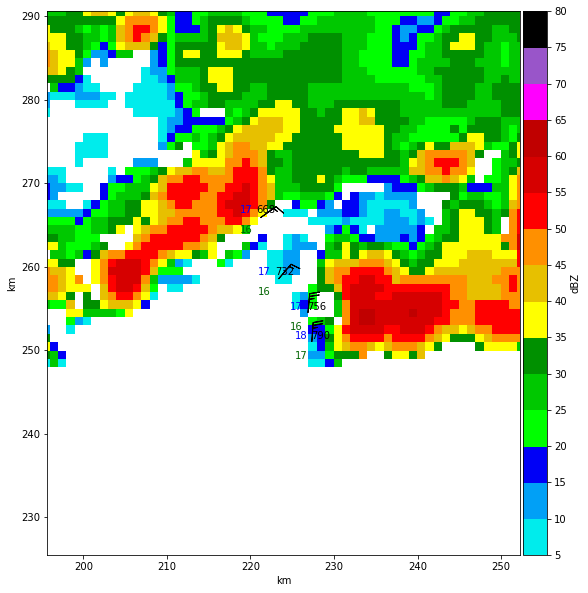

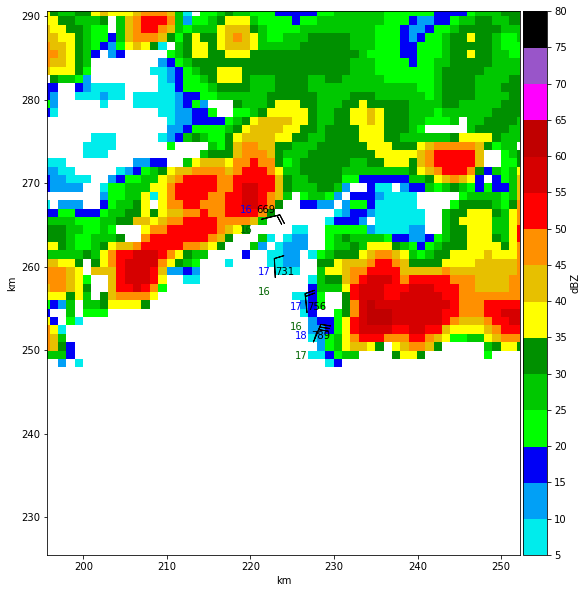

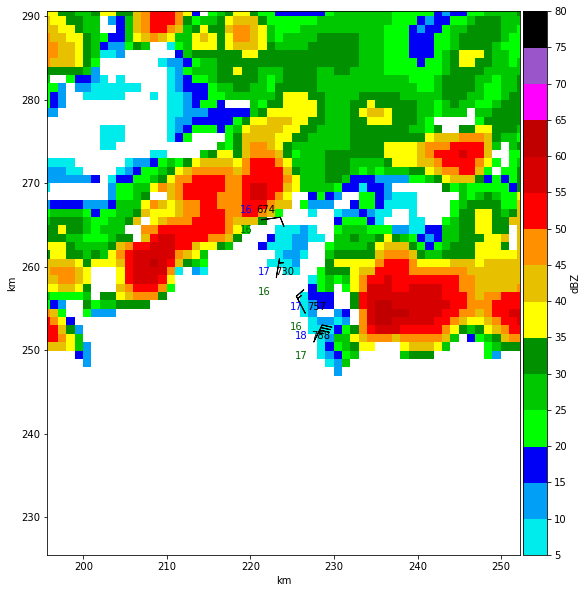

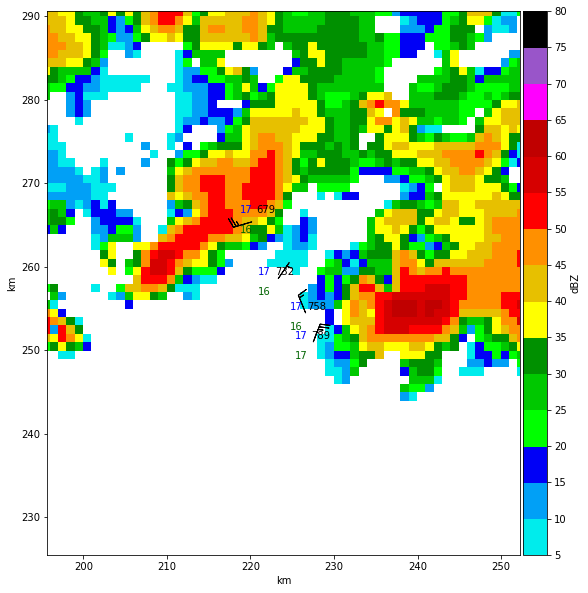

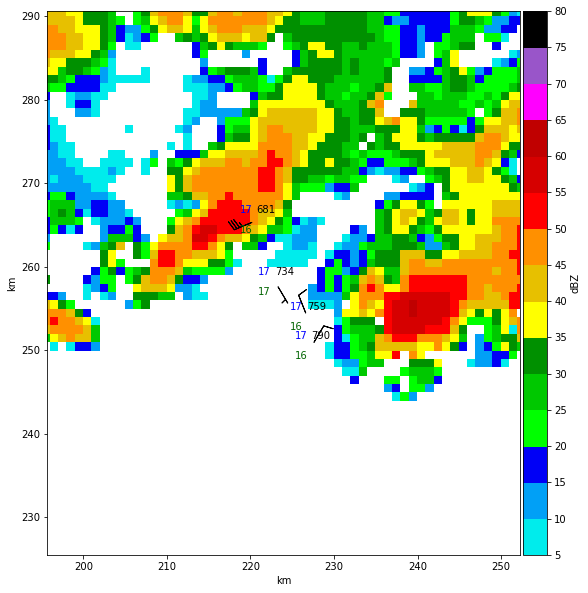

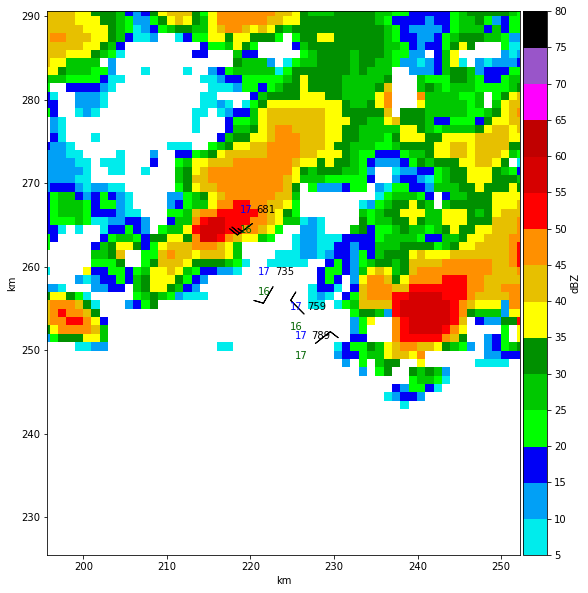

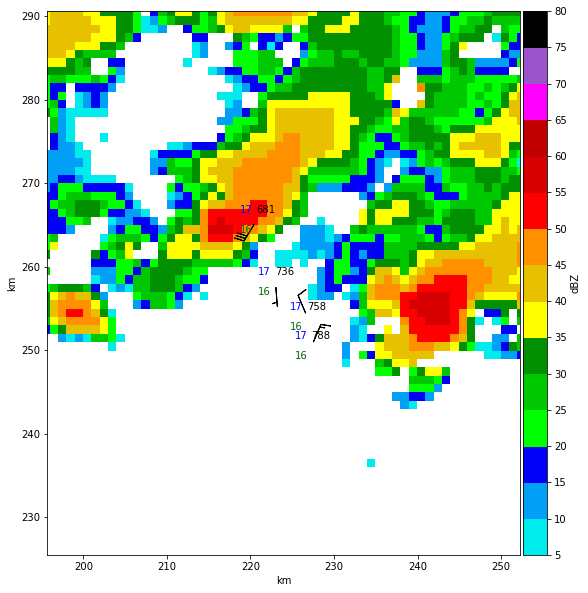

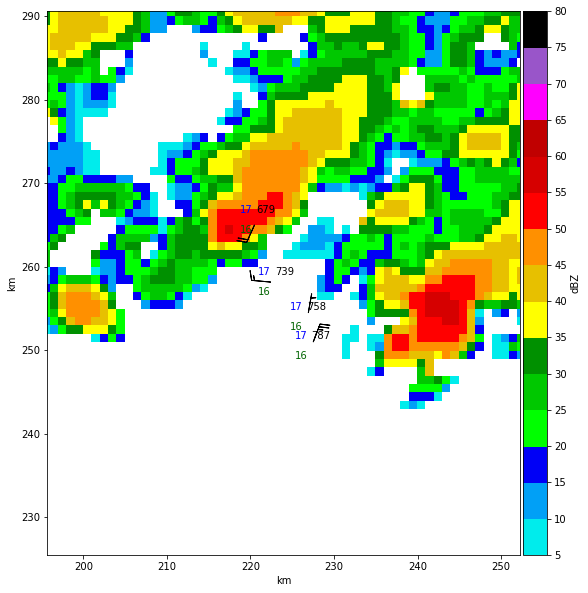

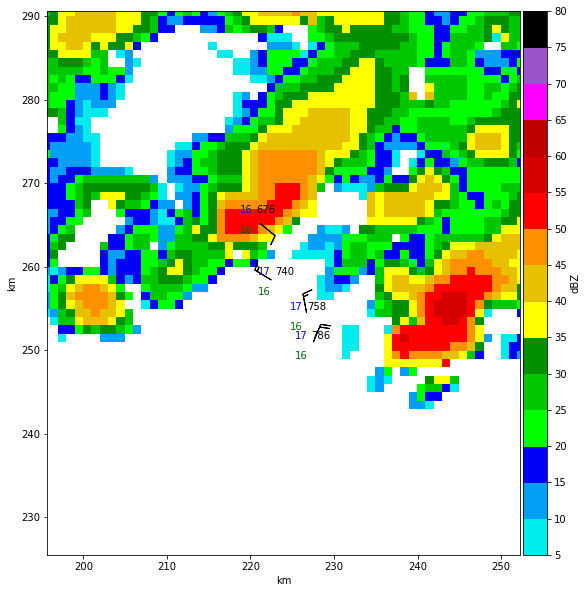

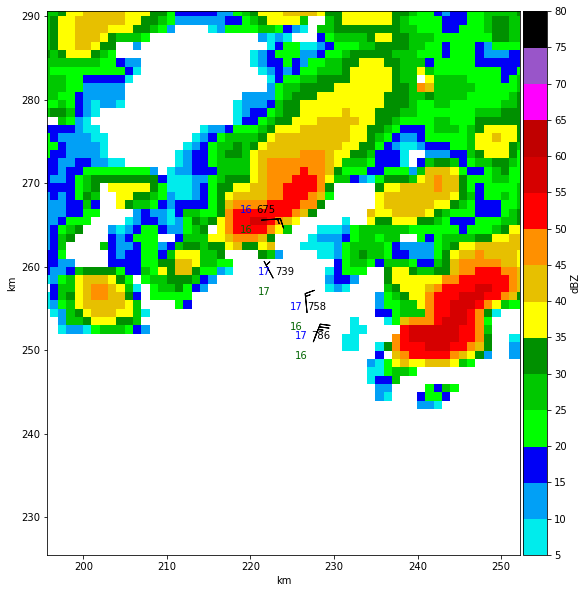

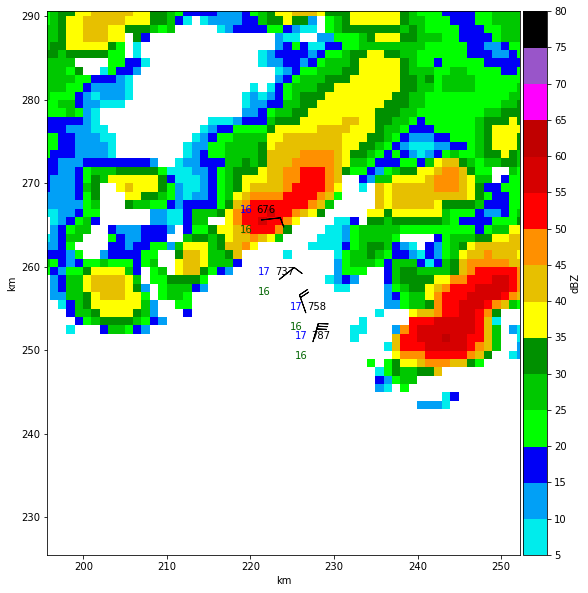

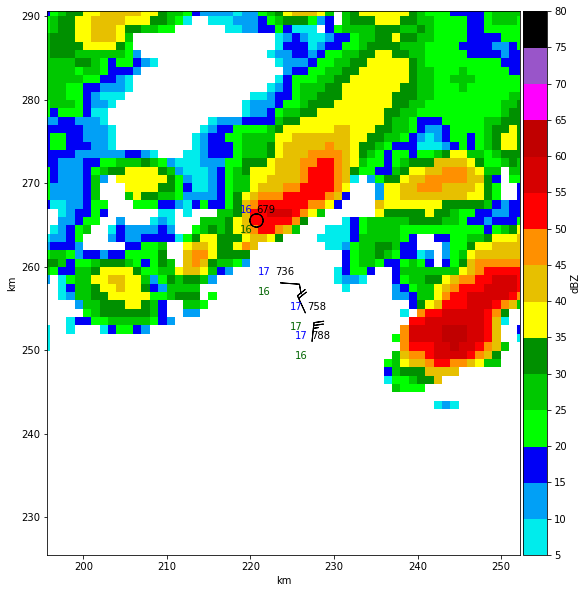

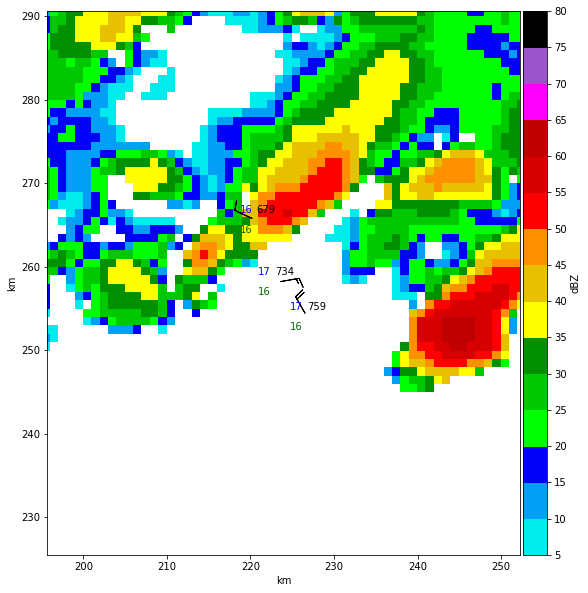

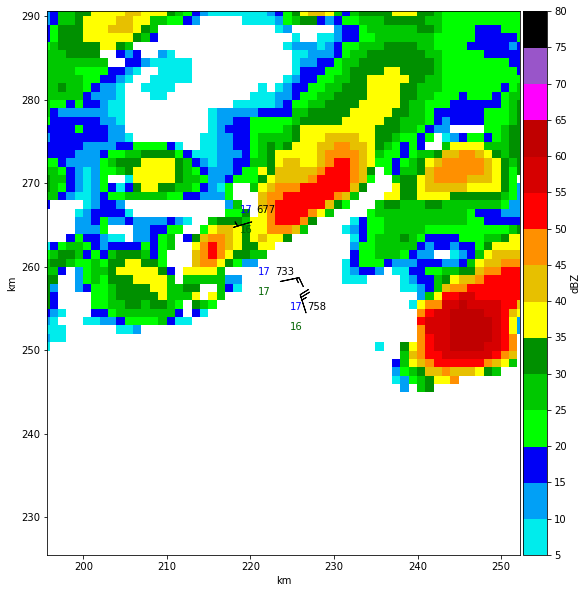

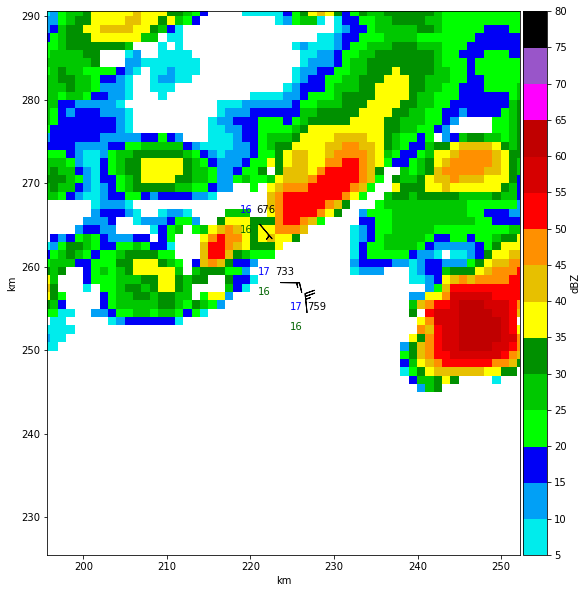

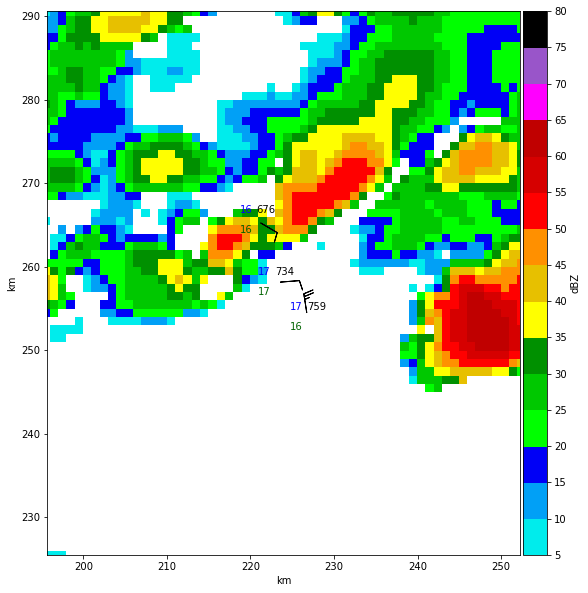

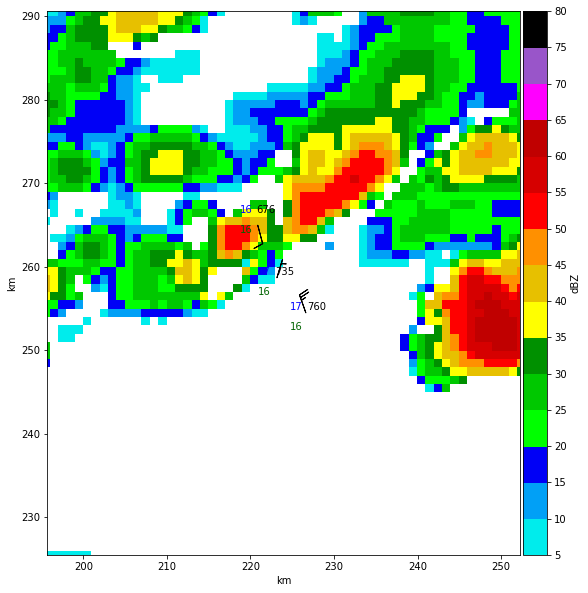

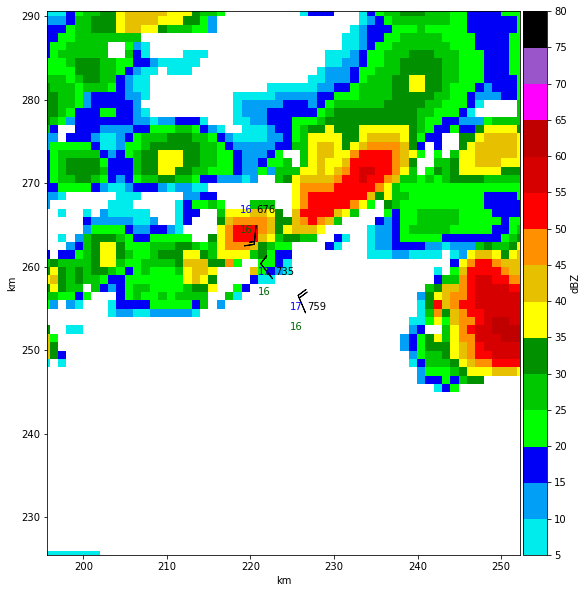

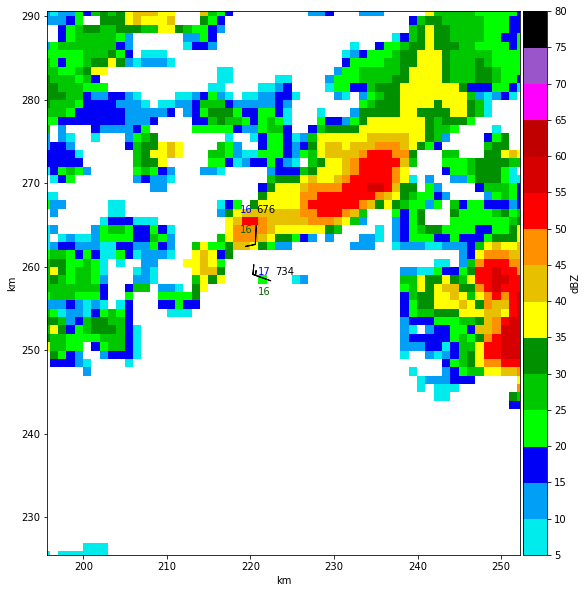

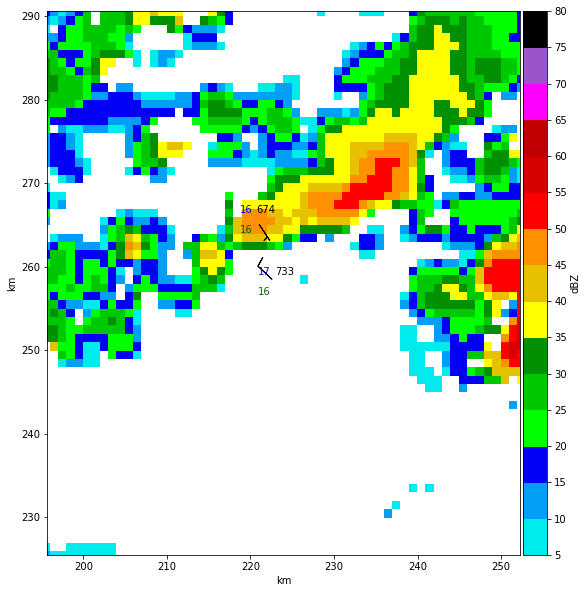

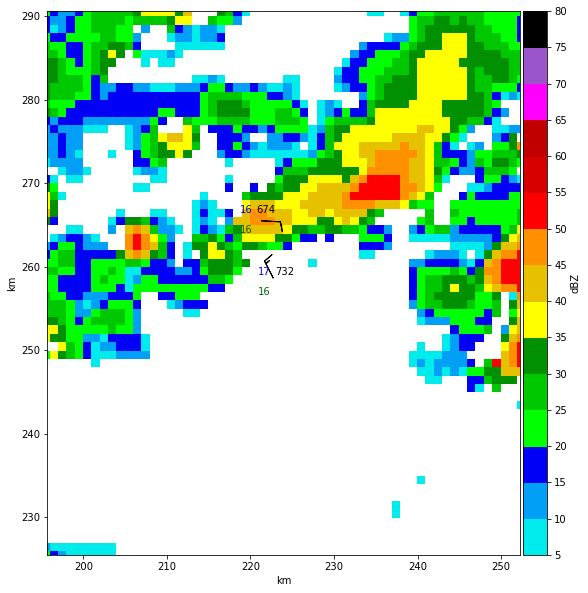

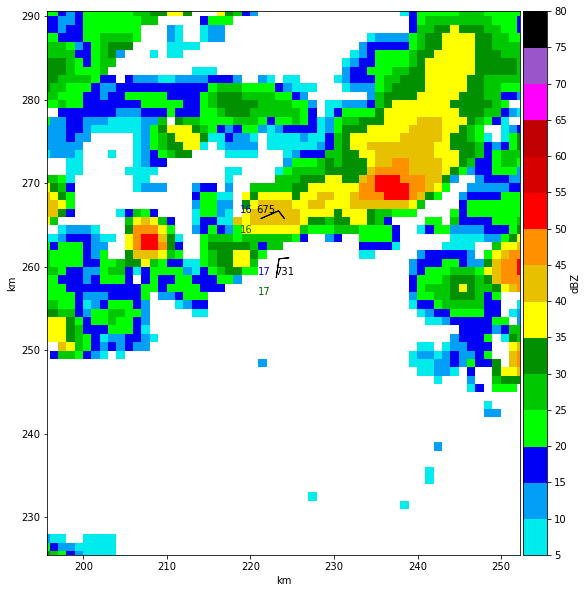

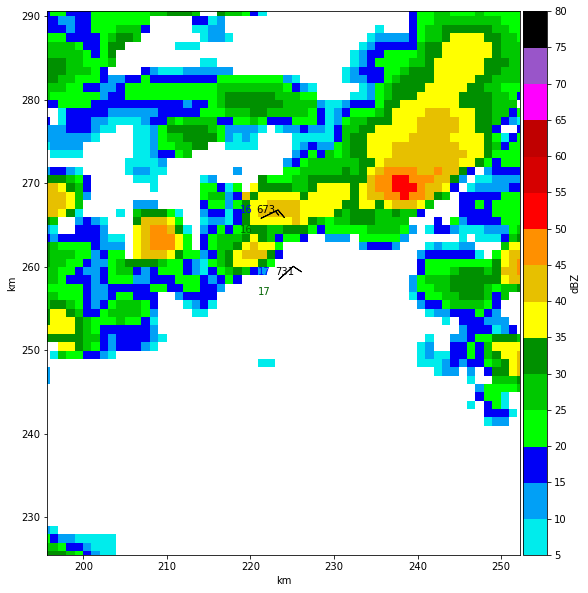

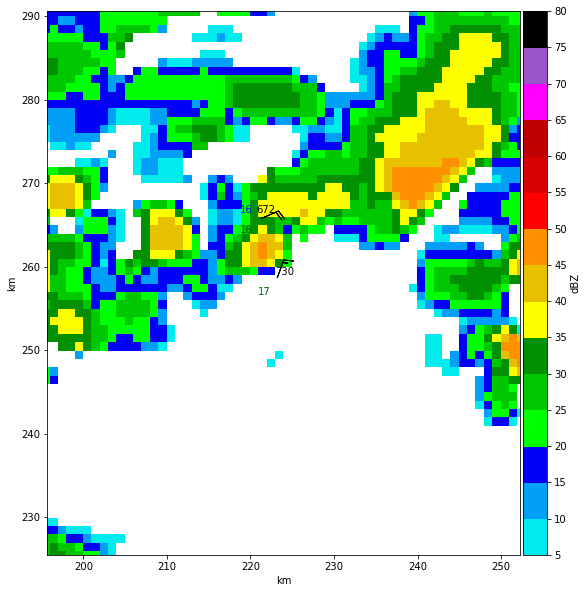

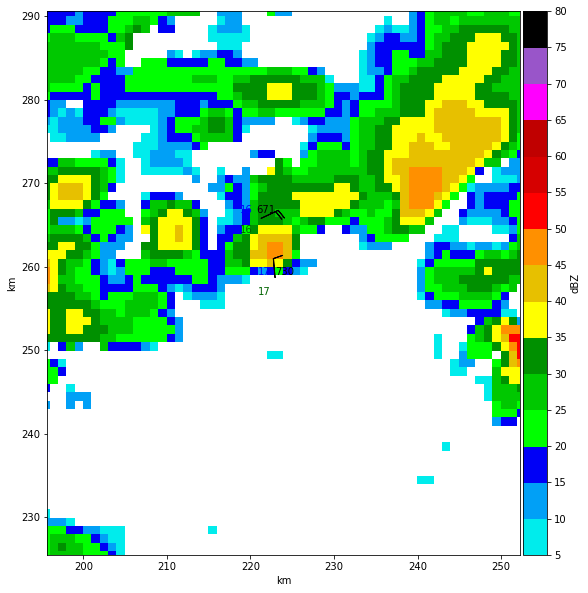

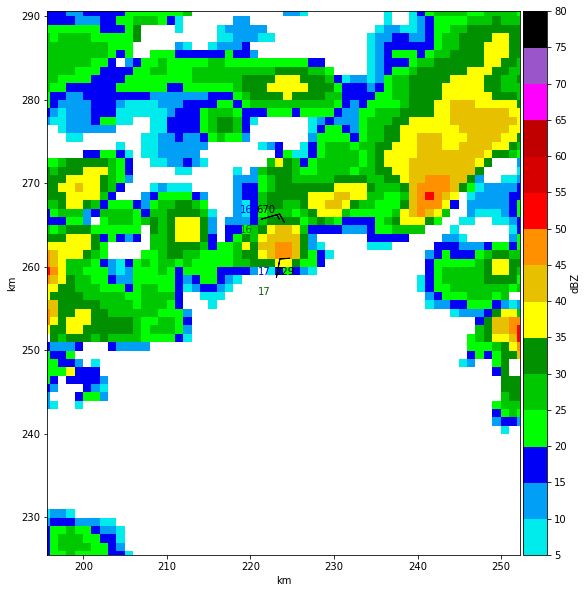

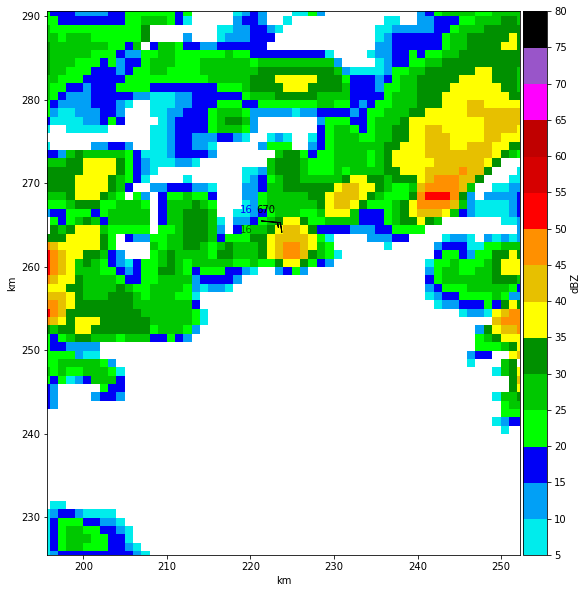

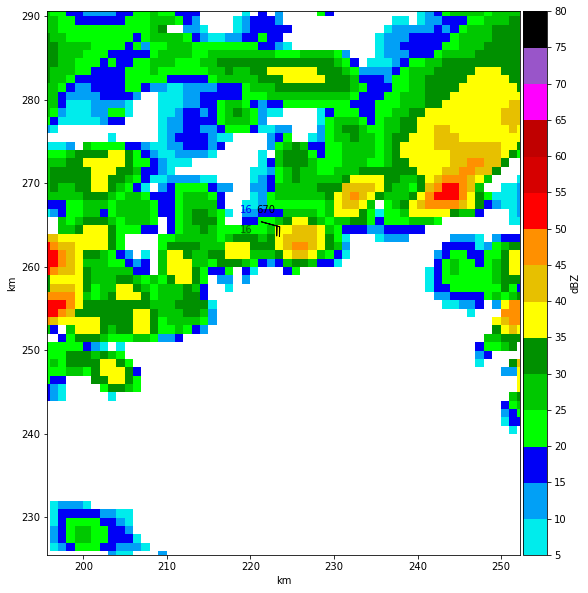

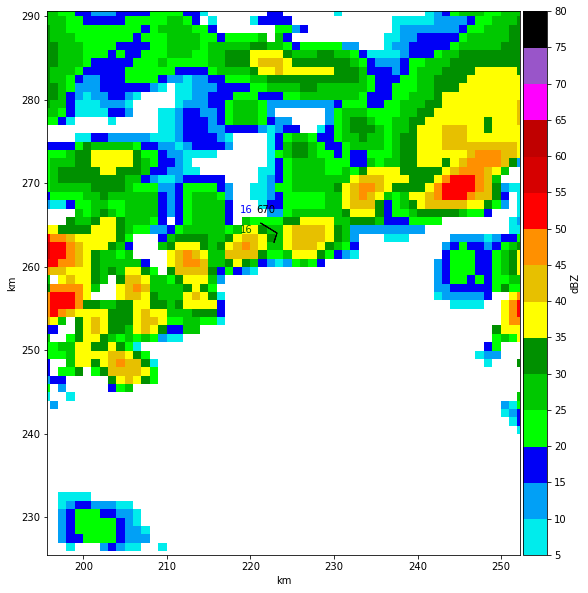

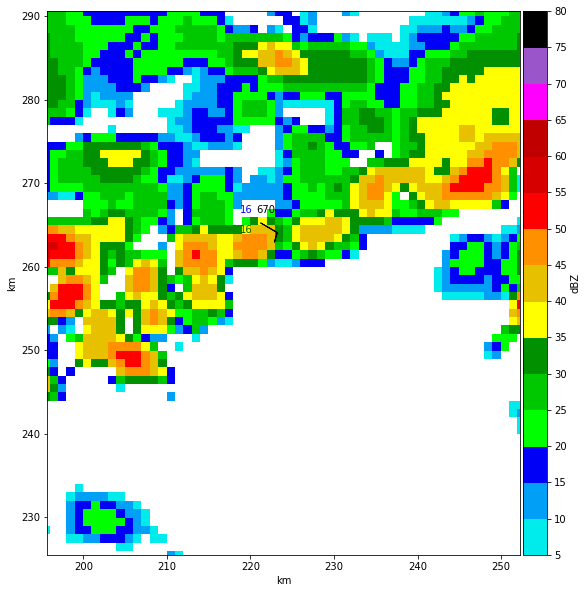

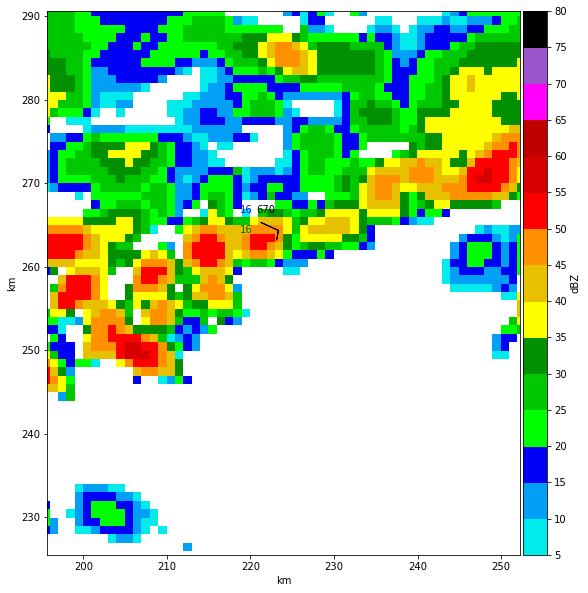

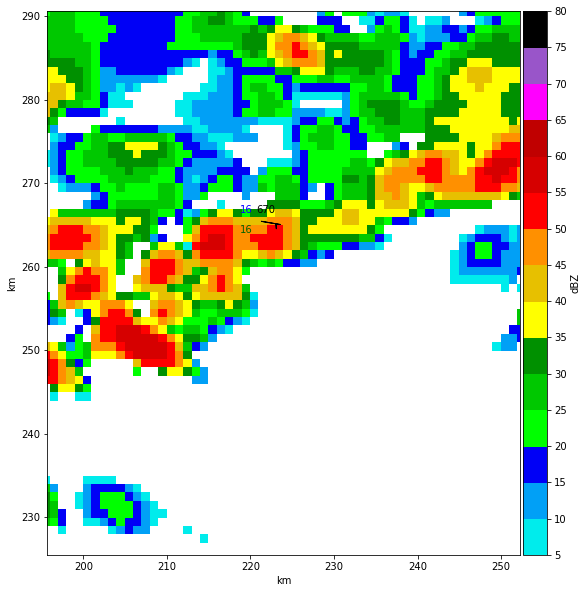

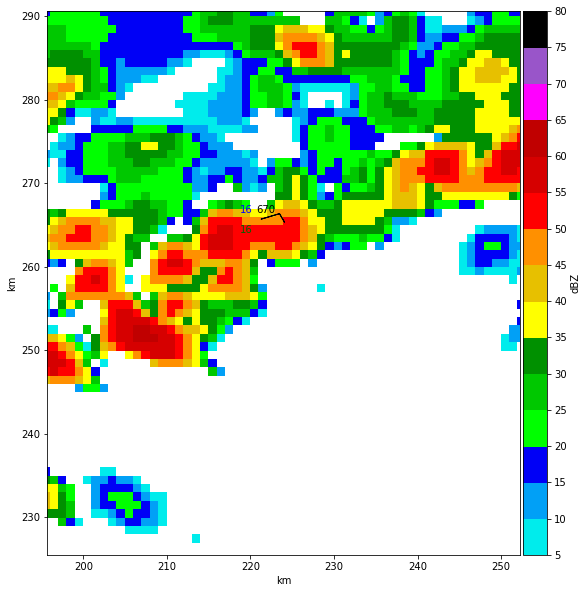

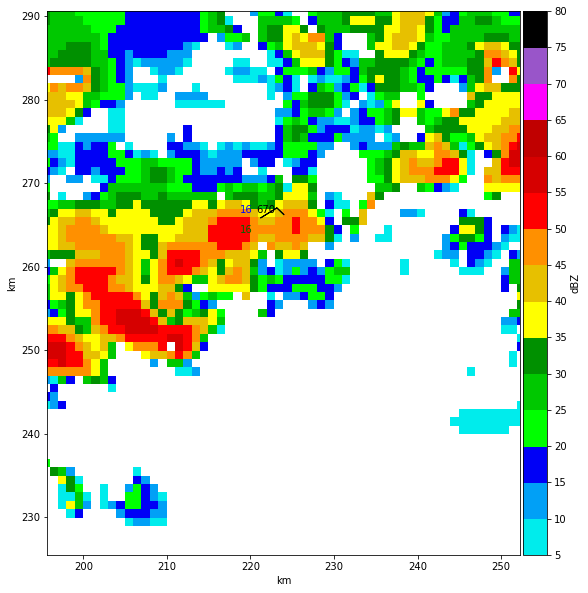

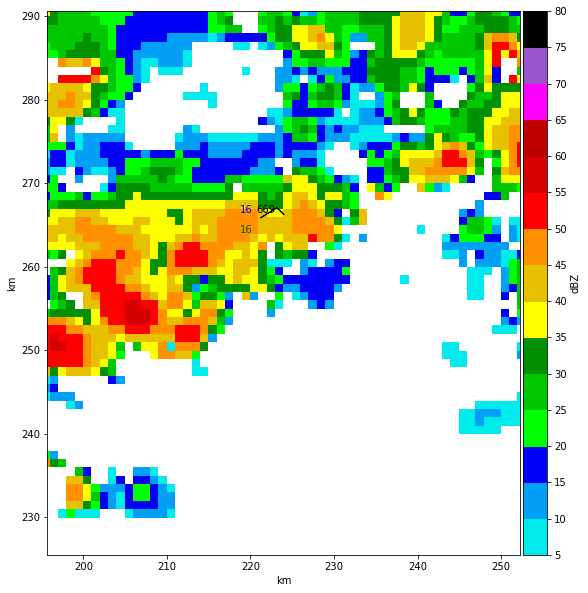

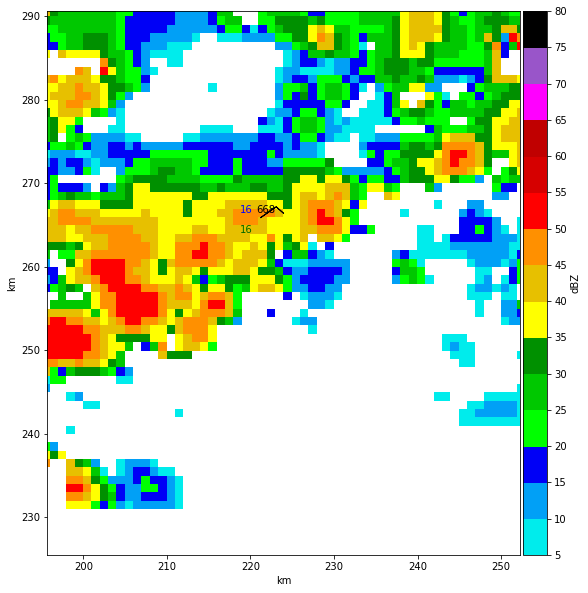

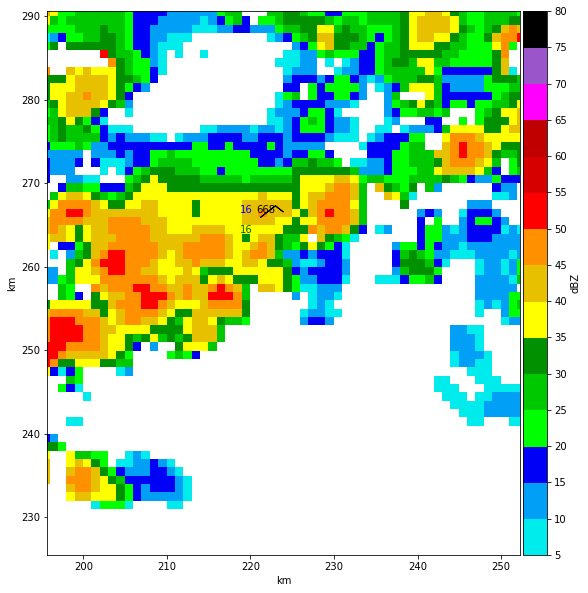

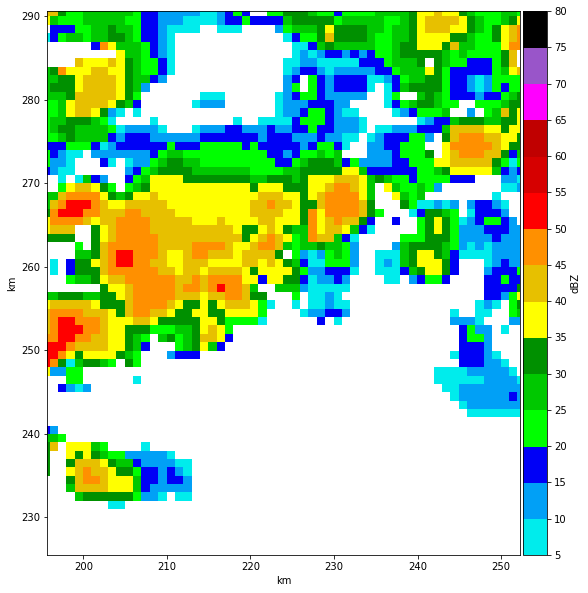

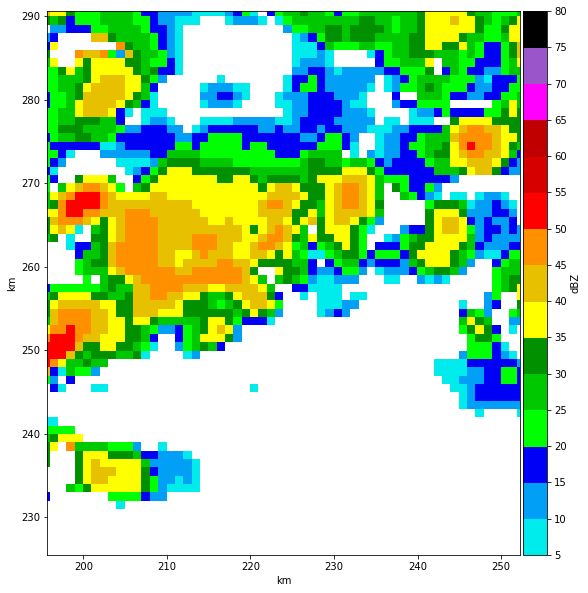

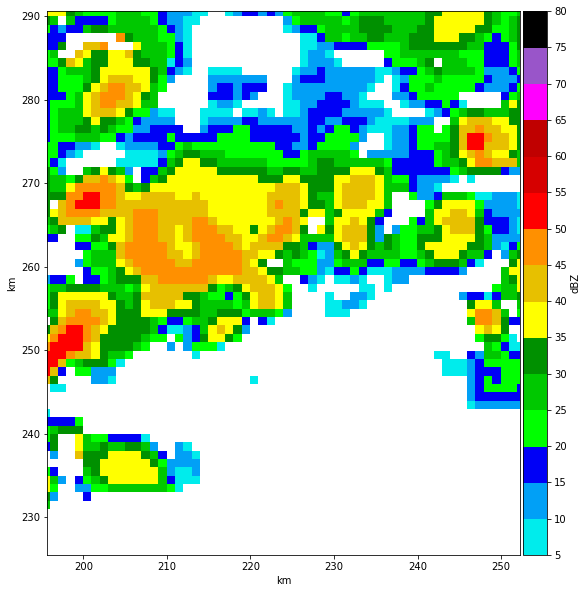

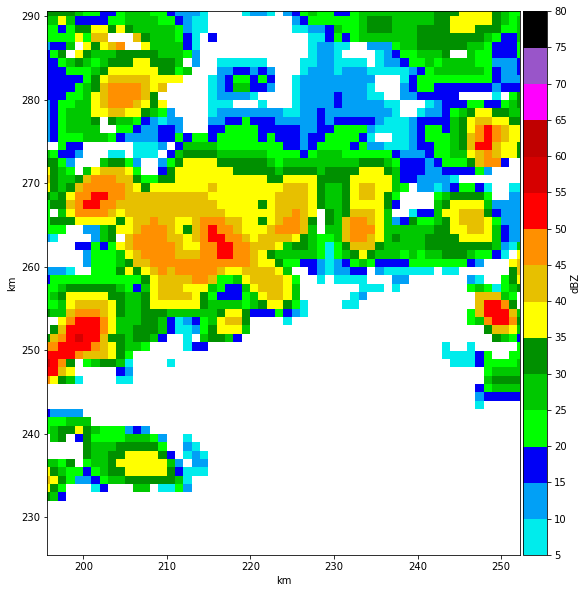

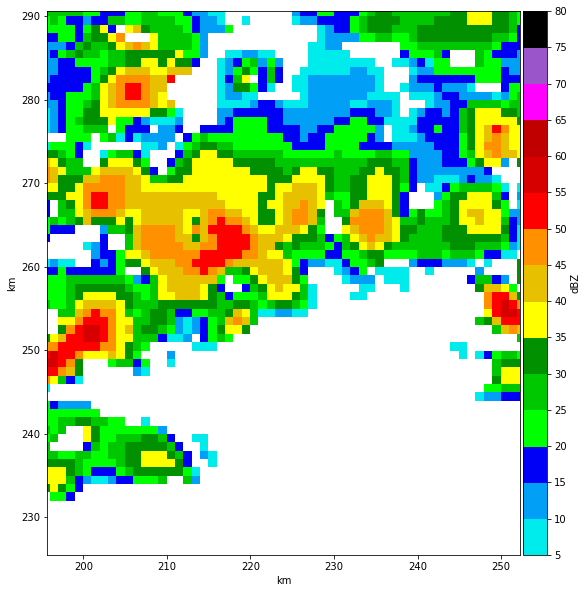

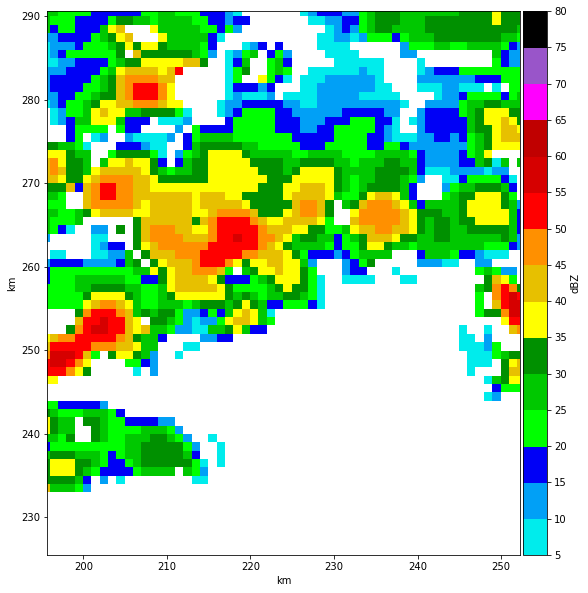

In [224]:
# Plot the PIPS station models on the ARPS model grid, similar to what was done with the radar sweep files
dilist = [i[0] for i in dis_dict['dmodcrdlist']]
djlist = [i[1] for i in dis_dict['dmodcrdlist']]

print(dilist)
print(djlist)

dxlist = [i[0] for i in dis_dict['dmodloclist']]
dylist = [i[1] for i in dis_dict['dmodloclist']]

print(dxlist)
print(dylist)

xc = grid_dict['xs']
yc = grid_dict['ys']
xe = grid_dict['x']
ye = grid_dict['y']

xckm = xc / 1000.
yckm = yc / 1000.
xekm = xe / 1000.
yekm = ye / 1000.

# Set plotting limits to center on the disdrometer locations 

Dxmin = min(dxlist)
Dxmax = max(dxlist)
Dymin = min(dylist)
Dymax = max(dylist)
plotlims = [Dxmin - 25000., Dxmax + 25000., Dymin - 25000., Dymax + 25000.]

ibgn = np.searchsorted(xc, plotlims[0])
iend = np.searchsorted(xc, plotlims[1]) + 1
jbgn = np.searchsorted(yc, plotlims[2])
jend = np.searchsorted(yc, plotlims[3]) + 1

print(plotlims)
print(ibgn, iend, jbgn, jend)

plotvar_dict = {
    'xcplt': xckm,
    'ycplt': yckm,
    'xeplt': xekm,
    'yeplt': yekm,
}

plotparam_dict = {
    'cmap': pyPIPSradar.cmapdBZ,
    'fieldlevels': np.arange(5.0, 85.0, 5.0),
    'clvls': matplotlib.ticker.MultipleLocator(base=5.0),
    'clabel': r'dBZ',
    'cformat': None,
}

plotparam_dict['norm'] = matplotlib.colors.BoundaryNorm(plotparam_dict['fieldlevels'], 
                                                        plotparam_dict['cmap'].N)

axesparam_dict = {
    'axis_ticks': (10000., 10000.),
    'axis_names': ('x', 'y')
}

plotlim_dict = {
    'x': (plotlims[0], plotlims[1]),
    'y': (plotlims[2], plotlims[3])
}

plotvar_name = 'dBZmod'


dis_dict_at_model = sim.read_convdata_at_modeltimes(init_dis_dict, model_dict)

# Extract stuff from disdrometer dictionary
templist = dis_dict_at_model['convdata_at_modeltimes']['temp']
dewpointlist = dis_dict_at_model['convdata_at_modeltimes']['dewpoint']
pressurelist = dis_dict_at_model['convdata_at_modeltimes']['pressure']
windspdavgveclist = dis_dict_at_model['convdata_at_modeltimes']['windspdavgvec']
winddiravgveclist = dis_dict_at_model['convdata_at_modeltimes']['winddiravgvec']

print(templist)

for i, time in enumerate(model_trange_sec):
    print("Loading time ", time) 
    filepath = arps_read.get_file_path(member_absdir, member_prefix, fileformat, time=time, filetype='history')
    print(filepath)
    
    var_read_dict = {}
    var_read_dict = pycaps_fields.get_fields(var_read_dict, field_names=[plotvar_name], path_grdbas=grdbas_path, 
                                             path_hdf=filepath, ibgn=ibgn, jbgn=jbgn, iend=iend, jend=jend, 
                                             klvls=[2], multipatch=True, grid_dict=grid_dict, 
                                             ignore_existing_vars=True, nproc_x=nproc_x, nproc_y=nproc_y)
    
    plotvar_dict = plotmod.init_plotvar_dict(plotvar_name, var_read_dict[plotvar_name], 0, 1, grid_dict)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plotmod.plot2D(fig, ax, 'pcolor', plotvar_dict, plotparam_dict)
    
    plotmod.set_plot_axes(ax, plotlim_dict, axesparam_dict)

    for j, Dx, Dy in zip(range(len(dxlist)), dxlist, dylist):
        stationplot = StationPlot(ax, [Dx], [Dy])
        stationplot.plot_parameter('NW', [templist[j][i]], color='blue')
        stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
        stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
        u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
        stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))
    
    figname = 'PIPS_station_model_{}.png'.format(model_datetime_range[i].strftime('%Y%m%d%H%M%S'))
    figpath = os.path.join(plotdir, figname)
    plt.savefig(figpath, dpi=300, bbox_inches='tight') 
    
# figlist, gridlist = pyPIPSradar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[i], ovrmap, 
#                                                     ovrdis, dis_name_list, dxy_list, fields_D_list)
#     ax = gridlist[0][0]
    
#     for j, Dx, Dy in zip(range(len(dxlist)), dxlist, dylist):
#         stationplot = StationPlot(ax, [Dx], [Dy])
#         stationplot.plot_parameter('NW', [templist[j][i]], color='red')
#         stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
#         stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
#         u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
#         stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))

#     figlist[0].canvas.draw()
#     figlist[0].set_size_inches(10., 10., forward = True)
#     figname = 'PIPS_station_{}.png'.format(sweeptime.strftime('%Y%m%d%H%M%S'))
#     figpath = os.path.join(plotdir, figname)
#     plt.savefig(figpath, dpi=300, bbox_inches='tight')

In [12]:
# Read in PIPS data

print(dis_dict.keys())

dis_dir = dis_dict['dis_dir']
dis_filenames = dis_dict['disfilenames']
dis_names = dis_dict['dis_names']

conv_df_dict = {}
parsivel_df_dict = {}
vd_matrix_da_dict = {}

for dis_filename, dis_name in zip(dis_filenames, dis_names):
    dis_filepath = os.path.join(dis_dir, dis_filename)
    print("Reading {}".format(dis_filepath))
    conv_df, parsivel_df, vd_matrix_da = pips_io.read_PIPS(dis_filepath, starttimestamp=timestamp_start,
                                                           stoptimestamp=timestamp_stop)
    # Calculate some additional thermodynamic quantities and add to the conventional data DataFrame
    conv_df = pips.calc_thermo(conv_df)
    conv_df_dict[dis_name] = conv_df
    parsivel_df_dict[dis_name] = parsivel_df
    vd_matrix_da_dict[dis_name] = vd_matrix_da

dict_keys(['dis_dir', 'dis_types', 'dis_names', 'disfilenames', 'convfilenames', 'starttimes', 'stoptimes', 'interval', 'convdata_at_sweeptimes', 'dgeoloclist', 'dradloclist', 'dmodloclist', 'dmodcrdlist', 'convdata_at_modeltimes'])
Reading /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/PIPS/processed/IOP3/PIPS_1A_IOP_3_D1.txt
GPS time: Thu Mar 31 22:12:03 2016, Logger time: Thu Mar 31 22:12:00 2016
GPS Offset: 0:00:03
Reading /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/PIPS/processed/IOP3/PIPS_1B_IOP_3_D1.txt
GPS time: Thu Mar 31 22:01:33 2016, Logger time: Thu Mar 31 22:01:30 2016
GPS Offset: 0:00:03
Reading /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/PIPS/processed/IOP3/PIPS_2A_IOP_3_D1.txt
GPS time: Thu Mar 31 22:25:03 2016, Logger time: Thu Mar 31 22:25:00 2016
GPS Offset: 0:00:03
Reading /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/PIPS/processed/IOP3/PIPS_2B_IOP_3_D1.txt
GPS t

In [13]:
# Resample PIPS data to a 60-s interval
conv_rs_df_dict = {}
parsivel_rs_df_dict = {}
vd_matrix_rs_da_dict = {}
for dis_name in dis_names:
    # Conventional data
    conv_df = conv_df_dict[dis_name]
    datetime_range_onesec = conv_df.index.to_pydatetime()
    sec_offset = pips.get_offset_seconds(datetime_range_onesec)
    conv_rs_df_dict[dis_name] = pips.resample_conv('PIPS', 60., sec_offset, conv_df)
    
    # Parsivel 10-s derived fields
    parsivel_df = parsivel_df_dict[dis_name]
    datetime_range_tensec = parsivel_df.index.to_pydatetime()
    sec_offset = pips.get_offset_seconds(datetime_range_tensec)
    print(sec_offset)
    parsivel_rs_df_dict[dis_name] = pips.resample_parsivel(60., parsivel_df)
    
    # Parsivel V-D matrix
    vd_matrix_da = vd_matrix_da_dict[dis_name]
    vd_matrix_rs_da_dict[dis_name] = pips.resample_vd_matrix(60., vd_matrix_da)

53
13
53
3


/Users/dawson29/Projects/pyPIPS/pyPIPS/PIPS.py:265: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  'hailflag': np.any}).fillna(0)


In [33]:
# Compute N(D) for the observed PIPS DSDs after some QC
min_diameters = pp.parsivel_parameters['min_diameter_bins_mm']
mid_diameters = pp.parsivel_parameters['avg_diameter_bins_mm']
max_diameters = pp.parsivel_parameters['max_diameter_bins_mm']
mid_fallspeeds = pp.parsivel_parameters['avg_fallspeed_bins_mps']
empirical_fallspeed = pips.calc_empirical_fallspeed(mid_diameters)
fallspeed_spectrum = pips.calc_fallspeed_spectrum(mid_diameters, mid_fallspeeds, use_measured_fallspeed=True)

ND_PIPS_dict = {}
logND_PIPS_dict = {}
PSD_datetimes_rs_PIPS_dict = {}

for dis_name in dis_names:
    vd_matrix_rs_da = vd_matrix_rs_da_dict[dis_name]
    vd_matrix_rs_QC = pqc.strongwindQC(vd_matrix_rs_da)
    vd_matrix_rs_QC = pqc.rainonlyQC(vd_matrix_rs_QC)
    # Calculate ND and log10(ND)
    ND = pips.calc_ND(vd_matrix_rs_QC.where(vd_matrix_rs_QC > 0.0), fallspeed_spectrum, 60.)
    logND = np.log10(ND)
    logND = logND.where(logND > -1.0)
    
    ND_PIPS_dict[dis_name] = ND
    logND_PIPS_dict[dis_name] = logND
    # Get times for PIPS transects as numpy arrays of python datetime objects
    PSD_datetimes_rs = pips.get_PSD_datetimes(vd_matrix_rs_da)
    PSD_datetimes_rs_dict = pips.get_PSD_time_bins(PSD_datetimes_rs)
    PSD_datetimes_rs_PIPS_dict[dis_name] = PSD_datetimes_rs_dict

65
84
45


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


95


In [42]:
# Compute some radar and DSD parameters from DSD
dBZ_PIPS_dict = {}
D0_PIPS_dict = {}
for dis_name in dis_names:
    dBZ_PIPS = dsd.calc_dBZ_from_bins(ND_PIPS_dict[dis_name])
    dBZ_PIPS = dBZ_PIPS.where(dBZ_PIPS > -np.inf)
    dBZ_PIPS_dict[dis_name] = dBZ_PIPS
    D0_PIPS = dsd.calc_D0_bin(ND_PIPS_dict[dis_name])
    D0_PIPS_dict[dis_name] = D0_PIPS

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


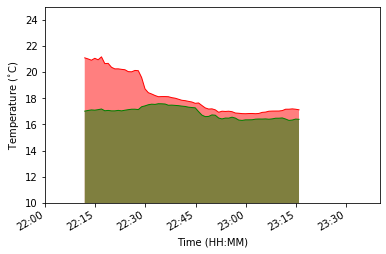

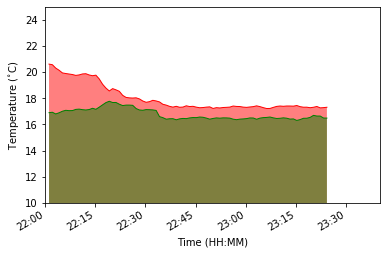

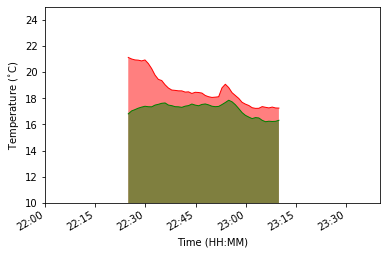

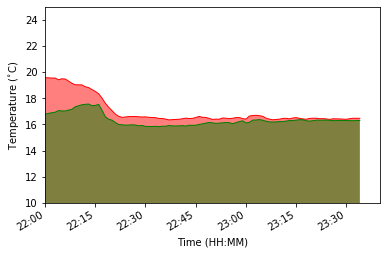

In [192]:
meteogram_dir = os.path.join(plotdir, 'meteograms')

dateformat = '%H:%M' 
formatter = dates.DateFormatter(dateformat)
locator = dates.MinuteLocator(byminute=[0, 15, 30, 45])
minorlocator = None
timelabel = 'Time (HH:MM)'
xaxislimits = [dates.date2num(datetime_range[0]), dates.date2num(datetime_range[-1])]
meteo_T_Td_range = [10., 25.]

for i, dis_name in enumerate(dis_names):
    conv_rs_df = conv_rs_df_dict[dis_name]
    datetimes_PIPS_conv = conv_rs_df.index.to_pydatetime()
    plottimes = dates.date2num(datetimes_PIPS_conv)
    T_PIPS = conv_rs_df['fasttemp']
    Td_PIPS = conv_rs_df['dewpoint']
   
    fig, ax = plt.subplots()
    fields = [T_PIPS, Td_PIPS]
    fieldparamdicts = [PIPSplot.temp_params, PIPSplot.dewpoint_params]
    ax = PIPSplot.plotmeteogram(ax, [plottimes], fields, fieldparamdicts)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [xaxislimits, meteo_T_Td_range],
                    'axeslabels': [timelabel, r'Temperature ($^{\circ}$C)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
    figfilepath = os.path.join(meteogram_dir, dis_name + '_T_Td.png')
    plt.savefig(figfilepath, dpi=300)

In [193]:
# Plot observed DSD meteograms

# Prepare axis parameters
# We'll use the model times just for the boundaries of the x-axis
timelimits = [datetime_range[0], datetime_range[-1]]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'observed'
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = dates.MinuteLocator(byminute=range(0,60,5))
dateformat = '%H:%M'
formatter = dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

# Ok, now we should have everything ready to go to plot the meteograms.
# Let'er rip!
for i, dis_name in enumerate(dis_names):
    logND = logND_PIPS_dict[dis_name]
    D0 = D0_PIPS_dict[dis_name] * 1000. # Get to mm again
    dBZ = dBZ_PIPS_dict[dis_name]
    PSDstarttimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_edges'])
    PSDmidtimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_centers'])
    disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'D_0': D0, 'dBZ': dBZ}
    
    dis_plot_name = dis_name + '_' + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_dir, axparams, disvars)

In [206]:
# Read in the model fields from previously generated netCDF files

# Choose a member
member = 1
member_dir, member_prefix = get_ARPS_member_dir_and_prefix(member, cycle)
ncfilename = member_prefix + '_fields.nc'
ncdir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/vortexse_enkf_dsd_study/data/nc'
ncfilepath = os.path.join(ncdir, ncfilename)

# Open the Dataset
var_ds = xr.open_dataset(ncfilepath)

In [207]:
# Interpolate the model variables to the PIPS locations
x_coords = [a[0] for a in dis_dict['dmodloclist']]
y_coords = [a[1] for a in dis_dict['dmodloclist']]

x_coords_da = xr.DataArray(x_coords, coords=[dis_names], dims=['PIPS'])
y_coords_da = xr.DataArray(y_coords, coords=[dis_names], dims=['PIPS'])

#var_ds_interp = var_ds.interpolate_na(dim='time')
var_ds_interp = var_ds.interp(xc=x_coords_da, yc=y_coords_da)
#var_ds_interp = var_ds_interp.interpolate_na(dim='time')

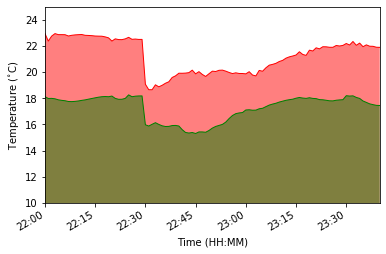

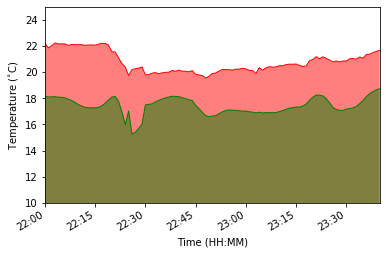

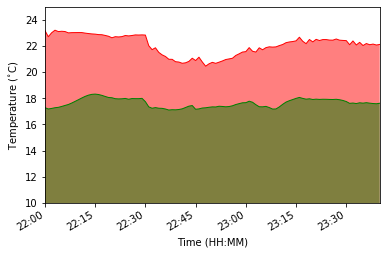

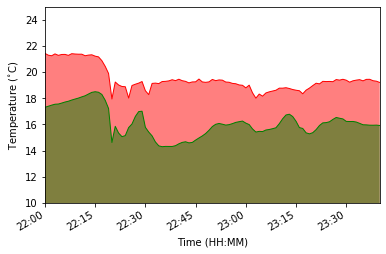

In [208]:
p_interp = var_ds_interp['p']
pt_interp = var_ds_interp['pt']
qv_interp = var_ds_interp['qv']

T_model_PIPS = thermo.calT(p_interp, pt_interp) - 273.15
Td_model_PIPS = thermo.calTd(p_interp, qv_interp) - 273.15


dateformat = '%H:%M' 
formatter = dates.DateFormatter(dateformat)
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = None
timelabel = 'Time (HH:MM)'
plottimes = dates.date2num(datetime_range)
xaxislimits = [plottimes[0], plottimes[-1]]
meteo_T_Td_range = [10., 25.]

for dis_name in dis_names:
    #print i
    fig, ax = plt.subplots()
    T_model_PIPS_plt = T_model_PIPS.sel(PIPS=dis_name)
    Td_model_PIPS_plt = Td_model_PIPS.sel(PIPS=dis_name)
    fields = [T_model_PIPS_plt, Td_model_PIPS_plt]
    fieldparamdicts = [PIPSplot.temp_params, PIPSplot.dewpoint_params]
    ax = PIPSplot.plotmeteogram(ax, [plottimes], fields, fieldparamdicts)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [xaxislimits, meteo_T_Td_range],
                    'axeslabels': [timelabel, r'Temperature ($^{\circ}$C)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
    figfilepath = os.path.join(meteogram_dir, dis_name + '_model_member_{:02d}_T_Td.png'.format(member))
    plt.savefig(figfilepath, dpi=300)


In [209]:
# Save for posterity. The DSD parameters are now computed on the model grid first, and then interpolated to
# the PIPS points: EDIT: brought this back. Computing the parameters *first* seems to have problems. I don't
# yet know why.

# Compute raw model DSD at PIPS locations
rhor = 1000.
cr = np.pi / 6. * rhor

qr_model_PIPS = var_ds_interp['qr']
nr_model_PIPS = var_ds_interp['nr']
zr_model_PIPS = var_ds_interp['zr']
rho_model_PIPS = thermo.calrho(p_interp, pt_interp, qv_interp)

# Shape parameter
# alphar_atPIPS = dualpol.solve_alpha_iter(rhoa_atPIPS, mu, qr_atPIPS, nr_atPIPS, zr_atPIPS, rhor)
alphar_model_PIPS = dsd.solve_alpha(rho_model_PIPS, cr, qr_model_PIPS, nr_model_PIPS, zr_model_PIPS)
# Intercept parameter
N0r_model_PIPS = dsd.calc_N0_gamma(rho_model_PIPS, qr_model_PIPS, nr_model_PIPS, cr, alphar_model_PIPS)
# Slope parameter
lamdar_model_PIPS = dsd.calc_lamda_gamma(rho_model_PIPS, qr_model_PIPS, nr_model_PIPS, cr, alphar_model_PIPS)

/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:419: RuntimeWarning: divide by zero encountered in true_divide
  tmp1 = cx / (rhoa * q)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:420: RuntimeWarning: invalid value encountered in multiply
  g = tmp1 * Z * tmp1 * Ntx
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:139: RuntimeWarning: divide by zero encountered in true_divide
  lamda = ((gamma4alp / gamma1alp) * cx * Ntx / (rhoa * q))**(1.0 / 3.0)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:139: RuntimeWarning: invalid value encountered in true_divide
  lamda = ((gamma4alp / gamma1alp) * cx * Ntx / (rhoa * q))**(1.0 / 3.0)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:139: RuntimeWarning: divide by zero encountered in true_divide
  lamda = ((gamma4alp / gamma1alp) * cx * Ntx / (rhoa * q))**(1.0 / 3.0)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:139: RuntimeWarning: invalid value encountered in true_divide
  lamda = ((gamma4alp / gamma1alp) * cx * Ntx / (rhoa * q))**(

In [210]:
# Save for posterity, now part of var_ds dataset above: EDIT: brought this back

# Temp fix until I get the above functions to work properly with xarray
# convert alphar, N0r, lamdar back to DataArrays

alphar_model_allPIPS_da = xr.DataArray(alphar_model_PIPS,
                                    coords={
                                        'time': qr_model_PIPS['time'],
                                        'PIPS': ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS2B']
                                    },
                                    dims=['time', 'PIPS'])
N0r_model_allPIPS_da = xr.DataArray(N0r_model_PIPS,
                                    coords={
                                        'time': qr_model_PIPS['time'],
                                        'PIPS': ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS2B']
                                    },
                                    dims=['time', 'PIPS'])
lamdar_model_allPIPS_da = xr.DataArray(lamdar_model_PIPS,
                                    coords={
                                        'time': qr_model_PIPS['time'],
                                        'PIPS': ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS2B']
                                    },
                                    dims=['time', 'PIPS'])

print(lamdar_model_allPIPS_da)

<xarray.DataArray (time: 101, PIPS: 4)>
array([[  3387.974902,   5048.098454,   3858.14914 ,   4970.746946],
       [ 12950.247797, 157342.71974 ,   1076.106611,   5740.720351],
       [  2457.706941,   5717.497308,   1758.860972,   4621.640035],
       ...,
       [  2691.847324,   2339.614486,   9281.306994,   2365.033368],
       [  2692.41077 ,   1920.451941,   9576.772396,   2180.644104],
       [  1601.006226,   2191.059586,  12315.544697,   2246.376511]])
Coordinates:
  * time     (time) datetime64[ns] 2016-03-31T22:00:00 ... 2016-03-31T23:40:00
  * PIPS     (PIPS) <U6 'PIPS1A' 'PIPS1B' 'PIPS2A' 'PIPS2B'


In [211]:
# Interpolate the PIPS DSD to the model times

ND_interp_to_model_times_dict = {}
logND_interp_to_model_times_dict = {}

for dis_name in dis_names:
    
    ND = ND_PIPS_dict[dis_name]
    # Rename time dimension to match
    ND = ND.rename({'time_10s': 'time'})
    ND_interp_model = ND.interp_like(var_ds_interp['ND'])
    
    # Now recompute logND from new interpolated ND
    logND_interp_model = np.log10(ND_interp_model)
    logND_interp_model = logND_interp_model.where(logND_interp_model > -np.inf)
    
    ND_interp_to_model_times_dict[dis_name] = ND_interp_model
    logND_interp_to_model_times_dict[dis_name] = logND_interp_model

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [212]:
# Compute some radar and DSD parameters from observed DSD that was just interpolated to model times
dBZ_PIPS_interp_to_model_times_dict = {}
D0_PIPS_interp_to_model_times_dict = {}
for dis_name in dis_names:
    dBZ_PIPS_interp = dsd.calc_dBZ_from_bins(ND_interp_to_model_times_dict[dis_name])
    dBZ_PIPS_interp = dBZ_PIPS_interp.where(dBZ_PIPS_interp > -np.inf)
    dBZ_PIPS_interp_to_model_times_dict[dis_name] = dBZ_PIPS_interp
    D0_PIPS_interp = dsd.calc_D0_bin(ND_interp_to_model_times_dict[dis_name])
    D0_PIPS_interp_to_model_times_dict[dis_name] = D0_PIPS_interp

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [213]:
# Plot observed DSD meteograms interpolated to model times

PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

# Prepare axis parameters
# We'll use the model times for the boundaries of the x-axis
timelimits = [datetime_range[0], datetime_range[-1]]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'observed'
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = dates.MinuteLocator(byminute=range(0,60,5))
dateformat = '%H:%M'
formatter = dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

# Ok, now we should have everything ready to go to plot the meteograms.
# Let'er rip!
for i, dis_name in enumerate(dis_names):
    logND = logND_interp_to_model_times_dict[dis_name]
    D0 = D0_PIPS_interp_to_model_times_dict[dis_name] * 1000. # Get to mm again
    dBZ = dBZ_PIPS_interp_to_model_times_dict[dis_name]
    disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'D_0': D0, 'dBZ': dBZ}
    
    dis_plot_name = dis_name + '_interp_to_model_' + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_dir, axparams, disvars)

In [214]:
# Compute N(D) from the raw model parameters at original model times
import pyPIPS.parsivel_params as pp

ND_model_raw_PIPS_dict = {}
logND_model_raw_PIPS_dict = {}
for i, dis_name in enumerate(dis_names):
    mid_diameters_da = vd_matrix_da_dict[dis_name]['diameter']
    alphar_model_PIPS_da = alphar_model_allPIPS_da.loc[dict(PIPS=dis_name)]
    N0r_model_PIPS_da = N0r_model_allPIPS_da.loc[dict(PIPS=dis_name)]
    lamdar_model_PIPS_da = lamdar_model_allPIPS_da.loc[dict(PIPS=dis_name)]
    # Broadcast DSD parameter DataArrays to get everyone on the same dimensional page
    mid_diameters_da, N0r_model_PIPS_da, lamdar_model_PIPS_da, alphar_model_PIPS_da = \
        xr.broadcast(mid_diameters_da, N0r_model_PIPS_da, lamdar_model_PIPS_da, alphar_model_PIPS_da)
    # Transpose these DataArrays to get time as the first dimension
    mid_diameters_da = mid_diameters_da.T
    N0r_model_PIPS_da = N0r_model_PIPS_da.T
    lamdar_model_PIPS_da = lamdar_model_PIPS_da.T
    alphar_model_PIPS_da = alphar_model_PIPS_da.T
    
    ND_model_raw_PIPS = dsd.calc_binned_DSD_from_params(N0r_model_PIPS_da, lamdar_model_PIPS_da, 
                                                        alphar_model_PIPS_da, mid_diameters_da)
    logND_model_raw_PIPS = np.log10(ND_model_raw_PIPS)
    logND_model_raw_PIPS = logND_model_raw_PIPS.where(logND_model_raw_PIPS > -np.inf)
    
    ND_model_raw_PIPS_dict[dis_name] = ND_model_raw_PIPS
    logND_model_raw_PIPS_dict[dis_name] = logND_model_raw_PIPS

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [215]:
# Compute some radar and DSD parameters from the raw model DSDs (interpolated to PIPS locations but not times)
dBZ_raw_model_dict = {}
D0_raw_model_dict = {}
for dis_name in dis_names:
    dBZ_raw_model = dsd.calc_dBZ_from_bins(ND_model_raw_PIPS_dict[dis_name])
    dBZ_raw_model = dBZ_raw_model.where(dBZ_raw_model > -np.inf)
    dBZ_raw_model_dict[dis_name] = dBZ_raw_model
    D0_raw_model = dsd.calc_D0_bin(ND_model_raw_PIPS_dict[dis_name])
    D0_raw_model_dict[dis_name] = D0_raw_model

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [216]:
# Now plot the raw model DSDs (interpolated to PIPS locations but not the times)

PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

for i, dis_name in enumerate(dis_names):
    logND = logND_model_raw_PIPS_dict[dis_name]
    logND = logND.where(logND > -1.0)
    D0 = D0_raw_model_dict[dis_name] * 1000. # Get to mm again
    dBZ = dBZ_raw_model_dict[dis_name]
    disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'D_0': D0, 'dBZ': dBZ}
    dis_plot_name = dis_name + '_raw_model_member_{:02d}_'.format(member) + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_dir, axparams, disvars)

In [217]:
# Now compute sampled PSDs from the model

# Now plot the sampled model DSD

sampling_interval = 60.
sampling_length = pp.parsivel_parameters['sensor_length_mm'] / 1000. # To m
sampling_width = pp.parsivel_parameters['sensor_width_mm'] / 1000. # To m

Dmax = 9.
Dmax_index = np.searchsorted(mid_diameters, Dmax, side='right')
# print(Dmax_index)
mid_diameters_trunc = np.array(mid_diameters[:Dmax_index+1]) / 1000.
min_diameters_trunc = np.array(min_diameters[:Dmax_index+1]) / 1000.
max_diameters_trunc = np.array(max_diameters[:Dmax_index+1]) / 1000.

PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

for dis_name in dis_names:
    nr_model = var_ds_interp['nr'].loc[dict(PIPS=dis_name)].values
    lamdar_model = var_ds_interp['lamdar'].loc[dict(PIPS=dis_name)].values
    alphar_model = var_ds_interp['alphar'].loc[dict(PIPS=dis_name)].values
    rho_model = var_ds_interp['rho'].loc[dict(PIPS=dis_name)].values

    # print(mid_diameters_trunc.shape)
    Vtr = pips.calc_empirical_fallspeed(mid_diameters_trunc * 1000., correct_rho=True, rho=rho_model)

    Vtr = Vtr.T
#     print(Vtr[0])
#     print(Vtr.shape)
#     print(mid_diameters_trunc.shape)
    ND_samp_series = np.zeros((np.size(PSDmidtimes), np.size(mid_diameters_trunc)))

#     print(ND_samp_series.shape)
#     print(nr_model[0])
    # Nc_bin_tmp2 = np.zeros((np.size(N0r), np.size(D[:Dmax_index+1])))
    # Nc_bin2 = np.zeros((np.size(np.array(sampling_times)), np.size(D[:Dmax_index+1])))

    all_valid = (not np.isnan(lamdar_model[0]) and (not np.isnan(alphar_model[0])) and (not np.isnan(nr_model[0])))
    if all_valid:
        # Special treatment for first sampling time. Just assume DSD valid at that time was constant for the previous 
        # sampling interval
        sample_dict = sim.create_random_gamma_DSD(nr_model[0], lamdar_model[0], 
                                                  alphar_model[0], Vtr[0], sampling_length, 
                                                  sampling_width, min_diameters_trunc, mid_diameters_trunc, 
                                                  max_diameters_trunc, Dmax=Dmax, sampling_interval=sampling_interval,
                                                  remove_margins=True, rhocorrect=True, rho=rho_model[0], verbose=True)


        ND_sample = sample_dict['ND']
        pcount_binned_sample = sample_dict['pcount_binned']
    #     print(ND_sample.shape)
    #     print(ND_samp_series.shape)
        ND_samp_series[0, :] = 1.e-3*ND_sample
        # Nc_bin_tmp2[0, :] = 1.e-3*ND_sample
        # Nc_bin2[0, :] = Nc_bin_tmp2[0, :]

    
    pcount_binned_samples = []
    for index in range(np.size(PSDmidtimes[1:-1])):
        all_valid = (not np.isnan(lamdar_model[index]) 
                     and (not np.isnan(alphar_model[index]))
                     and (not np.isnan(nr_model[index])))
        print('nr = ', nr_model[index], 'lamdar = ', lamdar_model[index], 'alphar = ', alphar_model[index])
        if all_valid:
            sample_dict = sim.create_random_gamma_DSD(nr_model[index], lamdar_model[index], 
                                                      alphar_model[index], Vtr[index], sampling_length, 
                                                      sampling_width, min_diameters_trunc, mid_diameters_trunc, 
                                                      max_diameters_trunc, Dmax=Dmax, sampling_interval=sampling_interval,
                                                      remove_margins=True, rhocorrect=True, rho=rho_model[index], verbose=True)
            ND_sample = sample_dict['ND']
            pcount_binned_samples.append(sample_dict['pcount_binned'])
            ND_samp_series[index, :] = 1.e-3*ND_sample
        else:
            pcount_binned_samples.append(np.zeros_like(sample_dict['pcount_binned']))

    pcount_binned_samples = np.array(pcount_binned_samples)
    
    ND_samp_da = xr.DataArray(ND_samp_series,
                                     coords={'time': PSDmidtimes,
                                             'diameter': ('diameter_bin', mid_diameters_trunc * 1000.),
                                             'max_diameter': ('diameter_bin', max_diameters_trunc * 1000.),
                                             'min_diameter': ('diameter_bin', min_diameters_trunc * 1000.)
                                            },
                                     dims=['time', 'diameter_bin'])
    
    ND_samp_da = ND_samp_da.fillna(0.0)

    # sampling_volumes_D = sim.calc_sampling_volumes_D(Vtr, Dr, Dmax, sampling_interval, sampling_area)
    # for s, sample_index in enumerate(sample_indices[:-1]):
    #     sample_index_end = sample_indices[s+1]
    #     current_sample_indices = slice(sample_index, sample_index_end, None)
    #     pcount_binned = np.sum(pcount_binned_samples[current_sample_indices], axis=0)
    #     Nc_bin2[s+1, :] = 1.e-3*sim.calc_ND(pcount_binned, sampling_volumes_D, Dr, Dl, Dmax)
    # #     Nc_bin2[s+1, :] = np.sum(Nc_bin_tmp2[current_sample_indices, :]*dt[current_sample_indices, None], axis = 0)/sampling_interval
    # #     print "s = ", s
    # #     print "sample time (beginning) = ", sampling_times[s]
    # #     print "sample time (end) = ", sampling_times[s+1]
    # #     print "dt[current_sample_indices] = ", dt[current_sample_indices]
    # #     print "Nc_bin_tmp = ", Nc_bin_tmp[current_sample_indices, :], dt[current_sample_indices]
    # #     print "Nc_bin = ", Nc_bin[s+1, :]

    logND_samp_da = np.log10(ND_samp_da)
    logND_samp_da = logND_samp_da.where(logND_samp_da > -1.0)

    # Compute dBZ and D0 from the sampled DSD
    dBZ_samp_model = dsd.calc_dBZ_from_bins(ND_samp_da)
    dBZ_samp_model = dBZ_samp_model.where(dBZ_samp_model > -np.inf)
    D0_samp_model = dsd.calc_D0_bin(ND_samp_da) * 1000. # Get to mm again
    
    disvars = {'min_diameter': min_diameters[:Dmax_index+1], 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND_samp_da.T, 'D_0': D0_samp_model, 
               'dBZ': dBZ_samp_model}
    dis_plot_name = dis_name + '_sampled_model_member_{:02d}_'.format(member) + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_dir, axparams, disvars)

Dmax_index =  24
sampling height =  590.4171783382274
sampling volume =  3.1882527630264272
number concentration =  14.523874884018191
number of particles in sampling volume =  46
minimum, maximum diameter in sample =  0.01129924146821072 0.028589287960280152
maximum allowed diameter =  0.009
number of particles less than Dmax =  0
number of particles above the lowest two bins =  46
number of particles within allowable diameter range =  0
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  14.523874884018191 lamdar =  1244.5057134816118 alphar =  21.508526844326386
Dmax_index =  24
sampling height =  590.4171783382274
sampling volume =  3.1882527630264272
number concentration =  14.523874884018191
number of particles in sampling volume =  46
minimum, maximum diameter in sample =  0.011503995975633962 0.02650718573095226
maximum allowed diameter =  0.009
number of particles less than Dmax =  0
number 

number of particles less than Dmax =  0
number of particles above the lowest two bins =  0
number of particles within allowable diameter range =  0
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  0.040738478548925774 lamdar =  6246.977189858623 alphar =  0.040848387455947356
Dmax_index =  24
sampling height =  590.3317667124459
sampling volume =  3.1877915402472072
number concentration =  0.040738478548925774
number of particles in sampling volume =  0
number of particles less than Dmax =  0
number of particles above the lowest two bins =  0
number of particles within allowable diameter range =  0
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  0.0170172252732887 lamdar =  21121.062781071774 alphar =  3.2621041980390695
Dmax_index =  24
sampling height =  590.3882594824162
sampling volume =  3.1880966012050

number of particles that fall through sampling area =  134
number of these that are margin fallers =  4
Removing margin fallers!
(26,)
nr =  231.89422773436823 lamdar =  nan alphar =  5.469586689260976
nr =  154.55096970824482 lamdar =  nan alphar =  23.96057896480896
nr =  96.27958358873312 lamdar =  2464.369721519777 alphar =  0.008605328509185006
Dmax_index =  24
sampling height =  587.1534569846139
sampling volume =  3.1706286677169144
number concentration =  96.27958358873312
number of particles in sampling volume =  305
minimum, maximum diameter in sample =  2.6049329068868862e-06 0.002722938036102901
maximum allowed diameter =  0.009
number of particles less than Dmax =  305
number of particles above the lowest two bins =  166
number of particles within allowable diameter range =  166
minimum, maximum particle diameter in truncated sample =  0.00025170144256887283 0.002722938036102901
number of particles that fall through sampling area =  45
number of these that are margin falle

/Users/dawson29/Projects/pyPIPS/pyPIPS/simulator.py:51: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1. / lamda


 5.447552316914236e-05 0.00016999976997656671
maximum allowed diameter =  0.009
number of particles less than Dmax =  4
number of particles above the lowest two bins =  0
number of particles within allowable diameter range =  0
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  1.2379679047003274 lamdar =  21356.954313417376 alphar =  2.5259509953661867
Dmax_index =  24
sampling height =  588.3159833264206
sampling volume =  3.176906309962671
number concentration =  1.2379679047003274
number of particles in sampling volume =  3
minimum, maximum diameter in sample =  0.00012635514826057632 0.0002026563135930552
maximum allowed diameter =  0.009
number of particles less than Dmax =  3
number of particles above the lowest two bins =  0
number of particles within allowable diameter range =  0
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing m

number of particles less than Dmax =  6
number of particles above the lowest two bins =  3
number of particles within allowable diameter range =  3
minimum, maximum particle diameter in truncated sample =  0.00031940532773565674 0.00046962962427481874
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  1.6859684375423685 lamdar =  13430.281673973159 alphar =  1.8188787897866214
Dmax_index =  24
sampling height =  589.3732510651835
sampling volume =  3.1826155557519904
number concentration =  1.6859684375423685
number of particles in sampling volume =  5
minimum, maximum diameter in sample =  6.74100697465259e-05 0.0008948545758264505
maximum allowed diameter =  0.009
number of particles less than Dmax =  5
number of particles above the lowest two bins =  2
number of particles within allowable diameter range =  2
minimum, maximum particle diameter in truncated sample =  0.00027245785804932174 0.000894

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


nr =  47.541210255844504 lamdar =  nan alphar =  6.826132744430136
nr =  25.48518163242715 lamdar =  nan alphar =  31.575837249677466
nr =  1.5852428378032024 lamdar =  14758.652128936656 alphar =  0.17463941762645854
Dmax_index =  24
sampling height =  590.9894656186872
sampling volume =  3.1913431143409103
number concentration =  1.5852428378032024
number of particles in sampling volume =  5
minimum, maximum diameter in sample =  8.494219183775308e-07 0.00012856801283118674
maximum allowed diameter =  0.009
number of particles less than Dmax =  5
number of particles above the lowest two bins =  0
number of particles within allowable diameter range =  0
number of particles that fall through sampling area =  0
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  13.780737103586006 lamdar =  3427.4971066620055 alphar =  0.4766483293605238
Dmax_index =  24
sampling height =  590.58072878402
sampling volume =  3.1891359354337077
number concentration =  13.7807

nr =  13.204221588051201 lamdar =  14318.787226094337 alphar =  3.7669459355087027
Dmax_index =  24
sampling height =  588.4164986008536
sampling volume =  3.177449092444609
number concentration =  13.204221588051201
number of particles in sampling volume =  41
minimum, maximum diameter in sample =  7.470544478893492e-05 0.0012549076334284995
maximum allowed diameter =  0.009
number of particles less than Dmax =  41
number of particles above the lowest two bins =  27
number of particles within allowable diameter range =  27
minimum, maximum particle diameter in truncated sample =  0.0002533037382498054 0.0012549076334284995
number of particles that fall through sampling area =  6
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  12.253479355871518 lamdar =  14170.650263230526 alphar =  3.742093261055102
Dmax_index =  24
sampling height =  588.4236342629899
sampling volume =  3.177487625020145
number concentration =  12.253479355871518
number of particles

nr =  17.01267363593277 lamdar =  1700.6004666255076 alphar =  0.0
Dmax_index =  24
sampling height =  589.5670228719415
sampling volume =  3.1836619235084838
number concentration =  17.01267363593277
number of particles in sampling volume =  54
minimum, maximum diameter in sample =  2.0401073325928967e-05 0.0039052961730650644
maximum allowed diameter =  0.009
number of particles less than Dmax =  54
number of particles above the lowest two bins =  32
number of particles within allowable diameter range =  32
minimum, maximum particle diameter in truncated sample =  0.0002824338243422525 0.0039052961730650644
number of particles that fall through sampling area =  15
number of these that are margin fallers =  1
Removing margin fallers!
(26,)
nr =  18.600590555277556 lamdar =  2194.9720646277683 alphar =  0.03540127597096382
Dmax_index =  24
sampling height =  589.7911973103986
sampling volume =  3.184872465476152
number concentration =  18.600590555277556
number of particles in sampling

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Dmax_index =  24
sampling height =  590.4089209447968
sampling volume =  3.1882081731019025
number concentration =  6.016647612647885
number of particles in sampling volume =  19
minimum, maximum diameter in sample =  0.00042672687644801117 0.0016093423270755758
maximum allowed diameter =  0.009
number of particles less than Dmax =  19
number of particles above the lowest two bins =  19
number of particles within allowable diameter range =  19
minimum, maximum particle diameter in truncated sample =  0.00042672687644801117 0.0016093423270755758
number of particles that fall through sampling area =  6
number of these that are margin fallers =  1
Removing margin fallers!
(26,)
nr =  6.016647612647885 lamdar =  3777.7261872779663 alphar =  2.3020567990843785
Dmax_index =  24
sampling height =  590.4089209447968
sampling volume =  3.1882081731019025
number concentration =  6.016647612647885
number of particles in sampling volume =  19
minimum, maximum diameter in sample =  0.00029420491442

/Users/dawson29/Projects/pyPIPS/pyPIPS/simulator.py:51: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1. / lamda


0.1362062597138216
Dmax_index =  24
sampling height =  588.4210386516509
sampling volume =  3.1774736087189144
number concentration =  48.579398785182946
number of particles in sampling volume =  154
minimum, maximum diameter in sample =  2.429239554858769e-06 0.0018428183092209767
maximum allowed diameter =  0.009
number of particles less than Dmax =  154
number of particles above the lowest two bins =  70
number of particles within allowable diameter range =  70
minimum, maximum particle diameter in truncated sample =  0.00025000928435260525 0.0018428183092209767
number of particles that fall through sampling area =  16
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  112.20920039942422 lamdar =  nan alphar =  1.349667380412373
nr =  178.26602644402755 lamdar =  2649.317111755574 alphar =  0.21149903083712507
Dmax_index =  24
sampling height =  588.4004806773601
sampling volume =  3.177362595657744
number concentration =  178.26602644402755
number of 

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


nr =  18.659267489560406 lamdar =  nan alphar =  7.125379832127995
nr =  42.832704703126076 lamdar =  6152.039459824832 alphar =  0.3125962304768529
Dmax_index =  24
sampling height =  591.287448254692
sampling volume =  3.1929522205753362
number concentration =  42.832704703126076
number of particles in sampling volume =  136
minimum, maximum diameter in sample =  1.6184617909245658e-06 0.000891924455580812
maximum allowed diameter =  0.009
number of particles less than Dmax =  136
number of particles above the lowest two bins =  48
number of particles within allowable diameter range =  48
minimum, maximum particle diameter in truncated sample =  0.0002529853463069944 0.000891924455580812
number of particles that fall through sampling area =  10
number of these that are margin fallers =  0
Removing margin fallers!
(26,)
nr =  58.05893973999248 lamdar =  4832.12383292013 alphar =  0.9014555930284557
Dmax_index =  24
sampling height =  591.3964775251765
sampling volume =  3.193540978635

minimum, maximum diameter in sample =  2.5116696379230507e-06 0.0034347599369602935
maximum allowed diameter =  0.009
number of particles less than Dmax =  2214
number of particles above the lowest two bins =  1705
number of particles within allowable diameter range =  1705
minimum, maximum particle diameter in truncated sample =  0.00025045349312739535 0.0034347599369602935
number of particles that fall through sampling area =  550
number of these that are margin fallers =  20
Removing margin fallers!
(26,)
nr =  668.5769109184239 lamdar =  3953.8354414550085 alphar =  1.2204553966562455
Dmax_index =  24
sampling height =  588.7422484074876
sampling volume =  3.1792081414004327
number concentration =  668.5769109184239
number of particles in sampling volume =  2125
minimum, maximum diameter in sample =  9.512840344657871e-06 0.0028027285786452324
maximum allowed diameter =  0.009
number of particles less than Dmax =  2125
number of particles above the lowest two bins =  1683
number of

/Users/dawson29/Projects/pyPIPS/pyPIPS/simulator.py:51: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1. / lamda


number of particles that fall through sampling area =  1112
number of these that are margin fallers =  44
Removing margin fallers!
(26,)
nr =  1569.0543276146586 lamdar =  2333.992487615402 alphar =  0.28039402729537816
Dmax_index =  24
sampling height =  588.3189770082935
sampling volume =  3.1769224758447843
number concentration =  1569.0543276146586
number of particles in sampling volume =  4984
minimum, maximum diameter in sample =  1.0933021641073352e-06 0.004474491324950854
maximum allowed diameter =  0.009
number of particles less than Dmax =  4984
number of particles above the lowest two bins =  3360
number of particles within allowable diameter range =  3360
minimum, maximum particle diameter in truncated sample =  0.0002503453358625803 0.004474491324950854
number of particles that fall through sampling area =  1042
number of these that are margin fallers =  28
Removing margin fallers!
(26,)
nr =  1784.2807103732027 lamdar =  2023.0246509115677 alphar =  0.13599986215194976
Dm

minimum, maximum diameter in sample =  7.298248778631701e-07 0.0036410291911778982
maximum allowed diameter =  0.009
number of particles less than Dmax =  4996
number of particles above the lowest two bins =  3683
number of particles within allowable diameter range =  3683
minimum, maximum particle diameter in truncated sample =  0.000250405304352045 0.0036410291911778982
number of particles that fall through sampling area =  1126
number of these that are margin fallers =  32
Removing margin fallers!
(26,)


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [164]:
print(model_vars_PIPS_dict['PIPS1B']['nr'].loc['2016-03-31T22:25':'2016-03-31T22:30'])
print(model_gamma_DSD_params_PIPS_dict['PIPS1B']['lamdar'].loc['2016-03-31T22:25':'2016-03-31T22:30'])
print(model_gamma_DSD_params_PIPS_dict['PIPS1B']['alphar'].loc['2016-03-31T22:25':'2016-03-31T22:30'])
print(model_gamma_DSD_params_PIPS_modeltimes_dict['PIPS1B']['alphar'].loc['2016-03-31T22:25':'2016-03-31T22:30'])

<xarray.DataArray 'nr' (time: 6)>
array([1042.782764,  867.52426 ,  616.272706,  460.170706,  479.193363,
        487.177792])
Coordinates:
    xc       float64 2.229e+05
    yc       float64 2.581e+05
    PIPS     <U6 'PIPS1B'
  * time     (time) datetime64[ns] 2016-03-31T22:25:13 ... 2016-03-31T22:30:13
<xarray.DataArray (time: 6)>
array([1170.148135, 1351.311015, 1722.224639, 1882.598612, 1489.646776,
       1234.139262])
Coordinates:
    PIPS     <U6 'PIPS1B'
  * time     (time) datetime64[ns] 2016-03-31T22:25:13 ... 2016-03-31T22:30:13
<xarray.DataArray (time: 6)>
array([ 0.362619,  0.200877,  0.325569,  0.259049,  3.25    , 11.753452])
Coordinates:
    PIPS     <U6 'PIPS1B'
  * time     (time) datetime64[ns] 2016-03-31T22:25:13 ... 2016-03-31T22:30:13
<xarray.DataArray (time: 6)>
array([ 0.416787,  0.166781,  0.324149,  0.3307  ,  0.      , 15.      ])
Coordinates:
  * time     (time) datetime64[ns] 2016-03-31T22:25:00 ... 2016-03-31T22:30:00
    PIPS     <U6 'PIPS1B'


# Old Cells Below!

In [ ]:
# Make a plot of the disdrometer transects through the storm, 
# choosing a representative sweeptime as the backdrop
plotdir = '/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/plots/'+casedate
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
# If there is no reference sweeptime in the dictionary, just use the first one
sweeptimeref = radar_dict[casedate]['sweeptime_ref']
ustorm, vstorm = radar_dict[casedate]['feature_motion']
sweepindex = np.searchsorted(sweeptimelist, sweeptimeref)
sweepdtrel = [(sweeptime - sweeptimeref).total_seconds() for sweeptime in sweeptimelist]
deployed = dis_dict_at_radar[casedate]['convdata_at_sweeptimes']['deployed']
# dxsr = [[dx - ustorm * dt if d else np.nan for dt, d in zip(sweepdtrel, dp)] for dx, dp in zip(dxlist, deployed)]
# dysr = [[dy - vstorm * dt if d else np.nan for dt, d in zip(sweepdtrel, dp)] for dy, dp in zip(dylist, deployed)]
dxsr = [[dx - ustorm * dt for dt in sweepdtrel] for dx in dxlist]
dysr = [[dy - vstorm * dt for dt in sweepdtrel] for dy in dylist]

# Split up disdrometer storm relative locations by whether the disdrometer was actually deployed at a given time
dxsr_d = [[x for x, d in zip(dx, dp) if d] for dx, dp in zip(dxsr, deployed)]
dxsr_nd = [[x for x, d in zip(dx, dp) if not d] for dx, dp in zip(dxsr, deployed)]
dysr_d = [[y for y, d in zip(dy, dp) if d] for dy, dp in zip(dysr, deployed)]
dysr_nd = [[y for y, d in zip(dy, dp) if not d] for dy, dp in zip(dysr, deployed)]

print sweeptimelist
print sweepindex
print deployed[0]
print dxsr[0]
print dxsr_d[0]
print dxsr_nd[0]

# Set plotting limits to center on the disdrometer locations 
Dxmin = np.nanmin(np.array(dxsr))
Dxmax = np.nanmax(np.array(dxsr))
Dymin = np.nanmin(np.array(dysr))
Dymax = np.nanmax(np.array(dysr))
plotlims = [Dxmin - 5000., Dxmax + 10000., Dymin - 10000., Dymax + 10000.]
# plotlims = [15000., 45000., -15000., 0.]

figlist, gridlist = radar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[sweepindex], ovrmap, 
                                              ovrdis, dis_name_list, dxy_list, fields_D_list)
ax = gridlist[0][0]

dis_names = dis_dict_at_radar[casedate]['dis_names']

for j, dx, dy, dx_d, dy_d, dx_nd, dy_nd, dp, dname in zip(xrange(len(dxlist)), dxsr, dysr, dxsr_d, dysr_d, 
                                                          dxsr_nd, dysr_nd, deployed, dis_names):
    ax.plot(dx_d, dy_d, ls='-', c='k')
    ax.plot(dx, dy, ls='--', c='k')
    if dp[sweepindex]:
        marker = 'o'
    else:
        marker = 'x'
    ax.plot(dx[sweepindex], dy[sweepindex], marker=marker, ms=10, c='k')
    ax.annotate(dname, (dx[sweepindex] + 1000., dy[sweepindex] - 2000.), clip_on=True)

gridlist[0].cbar_axes[0].set_ylabel('Z (dBZ)')
ax.set_xlabel('km')
ax.set_ylabel('km')
    
figlist[0].canvas.draw()
figlist[0].set_size_inches(10., 10., forward = True)

figpath = os.path.join(plotdir, casedate+'_transects_radar.eps', bbox_inches='tight')
plt.savefig(figpath, dpi=300)

In [ ]:
# Set up stuff for time composites
# Initial grid limits (m)
gridlims = [0., 100000., 0., 100000.]

# Width of composite box in m
compositewidthx = 60000.
compositewidthy = 60000.

# Width of search box for extremum in m
searchboxwidthx = 12000.
searchboxwidthy = 12000.

# Name of variable for whose extrema to track for compositing (that's an awkward phrasing)
tracking_varname = 'vortz'
# level (height in m) at which to track the extrema
tracking_level = 0.0 # 0.0 for 5 June, 3000.0 for 7 June, 3000.0 for 9 June 
# Type of extremum (max or min)
tracking_extremum = 'max'
# Threshold magnitude of extremum below which to throw out a time from the composite
tracking_thresh = 0.01

compositedict = {'gridlims': gridlims,
                 'compositewidth': (compositewidthx, compositewidthy), 
                 'searchboxwidth': (searchboxwidthx, searchboxwidthy),
                 'tracking_varname': tracking_varname,
                 'tracking_extremum': tracking_extremum, 
                 'tracking_level': tracking_level, 
                 'tracking_thresh': tracking_thresh}

# Read in the model information for the case we want
model_dict = sim.set_dh(casedate, init_model_dict, radar_dict)
dh = model_dict[casedate]['DataHandler']
modeltime_ref = model_dict[casedate]['modeltime_ref']

# Read in the model grid info
grid_dict = sim.read_model_grid(dh)
# Initialize composite parameters
if model_dict[casedate]['composite']:
    compositedict = sim.init_composite(compositedict, grid_dict)

# dp_data, consts = dh.loadMicrophysics()
# # Extract the lowest model level and store in dp_data_2D
# dp_data_2D = {}
# for key, dat in dp_data.iteritems():
#     dp_data_2D[key] = dat[:,:,0]
# dp_data_plot = {}
# for key, dat in dp_data_2D.iteritems():
#     dp_data_plot[key] = dat.swapaxes(0, 1).squeeze()
# dp_data_plot_list.append(dp_data_plot)

if model_dict[casedate]['composite']:
    print "Building composite!"
    varcompdict = sim.build_composite(casedate, model_dict, compositedict, dh)
    Zmod = varcompdict['DBZ']
    Zmodplot = Zmod
else:    
    Zmod = dh.loadModelReflectivity()
    Zmodplot = Zmod[:, :, 0].T
# Zmodplot_list.append(Zmodplot)

In [ ]:
# Quick plot of the reflectivity composite for testing
runname = model_dict[casedate]['runname']
model_times = model_dict[casedate]['model_times']
xckm_comp, yckm_comp = compositedict['ccoords']
uccomp = varcompdict['UC']
vccomp = varcompdict['VC']
wind_pltscale = 2.0 # Scale of wind vectors
windintv = 4        # Interval in grid points to plot wind vectors

clevels = np.arange(0., 85., 5.)
cintv = clevels[1] - clevels[0]
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5., 5.)
cbarlevels = ticker.MultipleLocator(base=cintv)
clabel = 'Z (dBZ)'
# qrplot = varcompdict['qg']*1000.
# clevels = np.arange(0., 5.05, 0.05)
# cintv = clevels[1] - clevels[0]
# norm = None
# cmap = cm.Blues
# cbarlevels = np.arange(0., 5.5, 0.5) # ticker.MultipleLocator(base=1.0)
# clabel = 'qg (g/kg)'

compfig = plt.figure(figsize=(8,8))
compax = compfig.add_subplot(111)
plt.title(model_dict[casedate]['runname'])
dBZplt = compax.contourf(xckm_comp, yckm_comp, Zmodplot, levels=clevels, cmap=cmap)
# compax.contour(xskm_comp,yskm_comp,dBZ.T,levels=np.arange(30.,90.,10.),colors='k')
windplt = compax.quiver(xckm_comp[::windintv], yckm_comp[::windintv], uccomp[::windintv, ::windintv],
    vccomp[::windintv, ::windintv], pivot='middle', units='width', scale_units='width', 
    scale=1200.0/float(wind_pltscale), width=0.001*float(wind_pltscale), headwidth=5, headlength=5, color='k')

compax.set_aspect('equal')
divider = make_axes_locatable(compax)
cax = divider.append_axes("right", size="5%", pad = 0.05)
clabels = cbarlevels
clvllocator = ticker.FixedLocator(clabels)
plt.colorbar(dBZplt, ticks=clvllocator, cax=cax)
cax.set_ylabel('Z (dBZ)')
#cax.set_ylabel('qg (g/kg)')

compax.set_xlabel('km')
compax.set_ylabel('km')

compfig.savefig(runname+'_dBZ_comp_{:06d}_{:06d}.pdf'.format(int(model_times[0]),int(model_times[-1])),dpi=200)

In [ ]:
# Make a plot of the disdrometer transects through the *simulated* storm, 
# choosing a representative *model time* as the backdrop

# First we need to set up a list of x and y coordinates within the model for each disdrometer. We'll use the
# coordinates computed relative to the radar above, but shifted so that they are in the same relative position
# to the model storm (necessarily subjective) as they are for the observed storm.
# For example, we'll use P2's coordinates near the tip of the hook for 5 June 2009.

if model_dict[casedate]['composite']:
    xref_model, yref_model = model_dict[casedate]['ref_coords_comp']
    # Some coordinate array shenanigans
    composite_grid_dict = sim.get_composite_grid(grid_dict, compositedict)
    xcplot = composite_grid_dict['xcplot']
    ycplot = composite_grid_dict['ycplot']
    xeplot = composite_grid_dict['xeplot']
    yeplot = composite_grid_dict['yeplot']
    xcorplot = composite_grid_dict['xcorplot']
    ycorplot = composite_grid_dict['ycorplot']
else:
    xref_model, yref_model = model_dict[casedate]['ref_coords']
    xcplot = grid_dict['xcplot']
    ycplot = grid_dict['ycplot']
    xeplot = grid_dict['xeplot']
    yeplot = grid_dict['yeplot']
    xcorplot = grid_dict['xcorplot']
    ycorplot = grid_dict['ycorplot']

xref_rad = dxlist[-1]
yref_rad = dylist[-1]

xshift = xref_model - xref_rad
yshift = yref_model - yref_rad

dxmodlist = [dx + xshift for dx in dxlist]
dymodlist = [dy + yshift for dy in dylist]

# Using sweeptimelist here to facilitate matching with the disdrometer locations on the radar plot.
sweepdtrel = [(sweeptime - modeltime_ref).total_seconds() for sweeptime in sweeptimelist]
dxsrm = [[dx - ustorm * dt for dt in sweepdtrel] for dx in dxmodlist]
dysrm = [[dy - vstorm * dt for dt in sweepdtrel] for dy in dymodlist]

# Split up disdrometer storm relative locations by whether the disdrometer was actually deployed at a given time
dxsrm_d = [[x for x, d in zip(dx, dp) if d] for dx, dp in zip(dxsrm, deployed)]
dxsrm_nd = [[x for x, d in zip(dx, dp) if not d] for dx, dp in zip(dxsrm, deployed)]
dysrm_d = [[y for y, d in zip(dy, dp) if d] for dy, dp in zip(dysrm, deployed)]
dysrm_nd = [[y for y, d in zip(dy, dp) if not d] for dy, dp in zip(dysrm, deployed)]

# Get the index where the relative time is zero. Use this below to put the probes
# at the proper location along the transect corresponding to the reference time.
modelindex_ref = np.searchsorted(sweepdtrel, 0.)

# Set plotting limits to center on the disdrometer locations 
Dxmin = np.array(dxsrm).min()
Dxmax = np.array(dxsrm).max()
Dymin = np.array(dysrm).min()
Dymax = np.array(dysrm).max()
plotlims = [Dxmin - 5000., Dxmax + 10000., Dymin - 10000., Dymax + 10000.]

fig = None
ax = None
ptype = 2
xlim = [plotlims[0], plotlims[1]]
ylim = [plotlims[2], plotlims[3]]
clevels = np.arange(0., 85., 5.)
cintv = clevels[1] - clevels[0]
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5., 5.)
cbarlevels = ticker.MultipleLocator(base=cintv)
clabel = 'Z (dBZ)'
cformat = None
ovrmap = False
gis_info = None
numovr = 0
axesticks = [10000., 10000.]

fig, ax = pm.plotsingle(fig, ax, ptype, xcplot, ycplot, xcorplot, ycorplot, xlim, ylim, Zmodplot, clevels, cmap, norm,
                            cbarlevels, clabel, cformat, ovrmap, gis_info, numovr, None, None, None, None, None,
                            axesticks)

for j, dx, dy, dx_d, dy_d, dx_nd, dy_nd, dp, dname in zip(xrange(len(dxmodlist)), dxsrm, dysrm, dxsrm_d, dysrm_d, 
                                                          dxsrm_nd, dysrm_nd, deployed, dis_names):
    ax.plot(dx, dy, ls='--', c='k')
    ax.plot(dx_d, dy_d, ls='-', c='k')
    if dp[modelindex_ref]:
        marker = 'o'
    else:
        marker = 'x'
    ax.plot(dx[sweepindex], dy[sweepindex], marker=marker, ms=10, c='k')
    ax.annotate(dname, (dx[sweepindex] + 1000., dy[sweepindex] - 2000.), clip_on=True)
    
fig.canvas.draw()
fig.set_size_inches(10., 10., forward = True)
figpath = os.path.join(plotdir, casedate+'_transects_model.eps', bbox_inches='tight')
plt.savefig(figpath, dpi=300)

In [ ]:
# Read in time series and add to dis_dict
dis_dict = sim.read_probe_time_series(casedate, dis_dict, radar_dict)


In [ ]:
if not model_dict[casedate]['composite']:
    varlists = ['DBZ', 'TH', 'QV', 'P']
    varlistv = ['U', 'V']
    varlist_derived = ['PTE', 'UC', 'VC']

    vardictlist = sim.read_vardict(casedate, model_dict, varlists, varlistv, varlist_derived)

    vardict = vardictlist[0]
    grid_dict_in = grid_dict
else:
    vardict = varcompdict
    grid_dict_in = composite_grid_dict

# Find grid intersections
dis_ts_model_dict = sim.find_transect_grid_intersections(casedate, grid_dict_in, dis_dict, model_dict, radar_dict, 
                                     vardict, plot_locations=False, debug=False)

In [ ]:
print dis_dict[casedate].keys()
print dis_ts_model_dict.keys()
print varcompdict['rhoa']
dis_ts_vars_points = dis_ts_model_dict['dis_ts_vars_points']
print len(dis_ts_vars_points)
dis_names = dis_dict[casedate]['dis_names']
print len(dis_names)

In [ ]:
print dis_dict[casedate]['timeseries'].keys()

In [ ]:
# Calculate and plot observed DSD transects
transect_DSD_obs_dict = sim.calc_obs_transect(casedate, dis_dict, dis_ts_model_dict, Dmax=9.0, plot_transects=True)

In [ ]:
# Calculate and plot model DSD transects
transect_DSD_dict = sim.interp_model_to_transect(casedate, dis_dict, model_dict, dis_ts_model_dict,
                                                 sampling_interval=60., add_hail=False, 
                                                 use_bins_for_interp=True, use_Parsivel_simulator=True, 
                                                 Dmax=9.0, plot_transects=True)

In [ ]:
# Make some one-to-one plots of D0 (model) vs. D0 (disdrometer)

yvals = sim.D*1000.
xvals = sim.D*1000.
color_list = ['r', 'orange', 'g', 'b']

D0r_mod = transect_DSD_dict['D0r']
D0r_mod_sampled = transect_DSD_dict['D0r_ps']

D0r_obs = transect_DSD_obs_dict['D0r_obs']
D0r_obs_gam = transect_DSD_obs_dict['D0r_gam']

for d, dis_name in enumerate(dis_dict[casedate]['dis_names']):
    obs = D0r_obs_gam[d]*1000.
    mod = D0r_mod[d]*1000.
    mod_sampled = D0r_mod_sampled[d]*1000.
    bias_mod = ((np.nansum(mod-obs))/np.nansum(obs))
    bias_mod_sampled = ((np.nansum(mod_sampled-obs))/np.nansum(obs))
    cc_mod = pd.DataFrame({'obs': obs, 'mod': mod}).corr().iloc[0, 1]
    cc_mod_sampled = pd.DataFrame({'obs': obs, 'mod': mod_sampled}).corr().iloc[0, 1]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.scatter(obs, mod, c=color_list[d], marker='*', label=dis_name+'_gamma')
    plt.scatter(obs, mod_sampled, c=color_list[d], marker='+', alpha=0.75, label=dis_name+'_sampled')
    ax.plot(xvals, yvals, lw=2, color='k')
    ax.set_xlim(0.0, 8.0)
    ax.set_ylim(0.0, 8.0)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Model')
    ax.text(0.6, 0.20, 'Bias (model): {:2.2f}'.format(bias_mod), transform=ax.transAxes)
    ax.text(0.6, 0.15, 'Cor. Coef. (model) {:2.3f}'.format(cc_mod), transform=ax.transAxes)
    ax.text(0.6, 0.10, 'Bias (model sampled): {:2.2f}'.format(bias_mod_sampled), transform=ax.transAxes)
    ax.text(0.6, 0.05, 'Cor. Coef. (model sampled) {:2.3f}'.format(cc_mod_sampled), transform=ax.transAxes)
    plt.legend(loc='upper left')

In [ ]:
# Calculate dual-pol variables for both the model and observations and make scatterplots of Z vs. ZDR
# Z, ZDR relation from Cao et al. (2008)
Zh_Cao = np.arange(10, 61, 0.1)
Zdr_Cao = 10**((-2.6857 * 10**-4 * Zh_Cao**2) + 0.04892 * Zh_Cao - 1.4287)

scattfile = '../tmatrix/S-band/SCTT_RAIN_fw100.dat'
wavelength = 10.7 # mm
Dmax = 9.0
Dmax_index = sim.get_Dmax_index(Dmax)
color_list = ['r', 'orange', 'g', 'b']
ND_mod = transect_DSD_dict['ND']
ND_obs = transect_DSD_obs_dict['ND']



for d, dis_name in enumerate(dis_dict[casedate]['dis_names']):
    dualpol_mod = dis.calpolrain(wavelength, scattfile, ND_mod[d].T, dis.bin_width[:Dmax_index])
    dualpol_obs = dis.calpolrain(wavelength, scattfile, ND_obs[d].T, dis.bin_width[:Dmax_index])
    sample_xlocs = np.array([xylocs[0] for xylocs in dis_ts_model_dict['dis_ts_xyslocs'][d]])
    print sample_xlocs
    sample_ylocs = np.array([xylocs[1] for xylocs in dis_ts_model_dict['dis_ts_xyslocs'][d]])
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    sc = plt.scatter(dualpol_mod['dBZ'], dualpol_mod['ZDR'], c=sample_xlocs, marker='*', label=dis_name+'_mod',
                     vmin=-15000., vmax=15000.)
    plt.scatter(dualpol_obs['dBZ'], dualpol_obs['ZDR'], c=sample_xlocs, marker='o', label=dis_name+'_obs', vmin=-15000., vmax=15000.)
    plt.plot(Zh_Cao, Zdr_Cao, c='k', ls='-', lw=1.0)
    plt.colorbar(sc)
    ax.set_xlabel('dBZ')
    ax.set_ylabel(r'Z$_DR$')
    ax.set_xlim(10.0, 60.0)
    ax.set_ylim(-2.0, 6.0)
    plt.legend(loc='upper left')